CIBER stacking procedure notes: https://docs.google.com/presentation/d/1ji4JgDxm4zp_AnsC_NIpZkusBhD5DtUV4iU9gj9i_Z4/edit#slide=id.g6021744a7c_1_163

# Maps

In [227]:
from reduction import *
from utils import *

data_maps = {1: image_reduction(1), 2: image_reduction(2)}

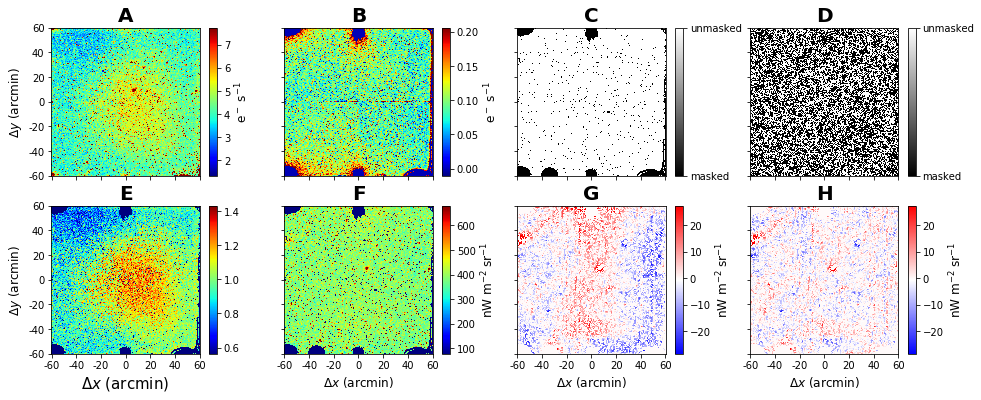

In [228]:
pixticks = np.linspace(0,1023,7)
pixtick_labels = ['-60', '-40', '-20', '0', '20', '40', '60']

for ifield in [4,5,6,7,8]:
    for inst in [1,2]:
        filt_order = filt_order_dict[inst]
        apf2eps = cal_factor_dict['apf2eps'][inst]
        apf2nWpm2psr = cal_factor_dict['apf2nWpm2psr'][inst][ifield]
        rawmap, DCmap, mask_inst, mapin, cbmap, strmask, FF\
        = load_processed_images(data_maps, [(inst,ifield,'rawmap'),
                                            (inst,ifield,'DCmap'),
                                           (inst,ifield,'mask_inst'),
                                           (inst,ifield,'map'),
                                           (inst,ifield,'cbmap'),
                                           (inst,ifield,'strmask'),
                                           (inst,ifield,'FF')],
                               rotate_TM2=True)
        plt.close()
        fig, ax = plt.subplots(2, 4, figsize = (16,6))
        axi = ax[0][0]
        p = imageclip(rawmap*apf2eps, ax=axi, return_objects=True)
        p['cbar'].ax.set_ylabel(r'e$^-$ s$^{-1}$', rotation=90, fontsize=12)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(['']*len(pixticks), fontsize=10)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=10)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=12)
        axi.set_title('A', fontsize=20, weight='bold')
#         axi.text(100,823,'A',fontsize=20, color='white', weight='bold')
        
        axi = ax[0][1]
        p = imageclip(DCmap*apf2eps, ax=axi, return_objects=True)
        p['cbar'].ax.set_ylabel(r'e$^-$ s$^{-1}$', rotation=90, fontsize=12)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(['']*len(pixticks), fontsize=10)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(['']*len(pixticks), fontsize=10)
        axi.set_title('B', fontsize=20, weight='bold')
#         axi.text(100,823,'B',fontsize=20, color='white', weight='bold')
        
        axi = ax[0][2]
        p = imageclip(mask_inst, ax=axi, return_objects=True, cmap='gist_gray', cbar=False)
        cbar = plt.colorbar(p['p'], ticks=[0,1], ax=ax[0][2])
        cbar.ax.set_yticklabels(['masked', 'unmasked'])
        axi.set_xticks(pixticks)
        axi.set_xticklabels(['']*len(pixticks), fontsize=10)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(['']*len(pixticks), fontsize=10)
        axi.set_title('C', fontsize=20, weight='bold')
#         axi.text(100,823,'C',fontsize=20, color='yellowgreen', weight='bold')
        
        axi = ax[0][3]
        p = imageclip(strmask, ax=axi, return_objects=True, cmap='gist_gray', cbar=False)
        cbar = plt.colorbar(p['p'], ticks=[0,1], ax=ax[0][3])
        cbar.ax.set_yticklabels(['masked', 'unmasked'])
        axi.set_xticks(pixticks)
        axi.set_xticklabels(['']*len(pixticks), fontsize=10)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(['']*len(pixticks), fontsize=10)
        axi.set_title('D', fontsize=20, weight='bold')
#         axi.text(100,823,'D',fontsize=20, color='yellowgreen', weight='bold')
        
        axi = ax[1][0]
        p = imageclip(FF, ax=axi, return_objects=True)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=10)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=10)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=12)
        axi.set_title('E', fontsize=20, weight='bold')
#         axi.text(100,823,'E',fontsize=20, color='white', weight='bold')
        
        axi = ax[1][2]
        unfilt_sm = image_smooth_gauss(cbmap*mask_inst*strmask)
        p = imageclip(unfilt_sm, ax=axi, return_objects=True, cmap='bwr')
        p['cbar'].ax.set_ylabel(r'nW m$^{-2}$ sr$^{-1}$', rotation=90, fontsize=12)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=10)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=12)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(['']*len(pixticks), fontsize=10)
        axi.set_title('G', fontsize=20, weight='bold')
#         axi.text(100,823,'G',fontsize=20, color='yellowgreen', weight='bold')
        
        axi = ax[1][3]
        filtmap = image_poly_filter(cbmap, strmask*mask_inst, degree=filt_order)
        filt_sm = image_smooth_gauss(filtmap*mask_inst*strmask)
        p = imageclip(filt_sm, ax=axi, 
                      vmin=p['vmin'], vmax=p['vmax'],return_objects=True, cmap='bwr')
        p['cbar'].ax.set_ylabel(r'nW m$^{-2}$ sr$^{-1}$', rotation=90, fontsize=12)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=10)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=12)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(['']*len(pixticks), fontsize=10)
        axi.set_title('H', fontsize=20, weight='bold')
#         axi.text(100,823,'H',fontsize=20, color='yellowgreen', weight='bold')
        
        axi = ax[1][1]
        meanmap = np.mean(mapin[mask_inst*strmask==1])*apf2nWpm2psr
        p = imageclip(cbmap*mask_inst*strmask, ax=axi, return_objects=True,cbar=False)
        p = imageclip(mapin*mask_inst*apf2nWpm2psr, ax=axi,
                      vmin=3*p['vmin']+meanmap, vmax=3*p['vmax']+meanmap,return_objects=True)
        p['cbar'].ax.set_ylabel(r'nW m$^{-2}$ sr$^{-1}$', rotation=90, fontsize=12)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=10)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=12)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(['']*len(pixticks), fontsize=10)
        axi.set_title('F', fontsize=20, weight='bold')
#         axi.text(100,823,'F',fontsize=20, color='white', weight='bold')
        
        plt.savefig('plots/paperfig/maps_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
                    dpi = 100, bbox_inches='tight')

# stacking & excess profile

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in true_divide
/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils_plotting.py:108: RuntimeWarning: invalid value encountered in greater_equal
  spp = np.where(y>=0)[0]
/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils_plotting.py:109: RuntimeWarning: invalid value encountered in less
  spn = np.where(y<0)[0]
No handles with labels found to put in legend.


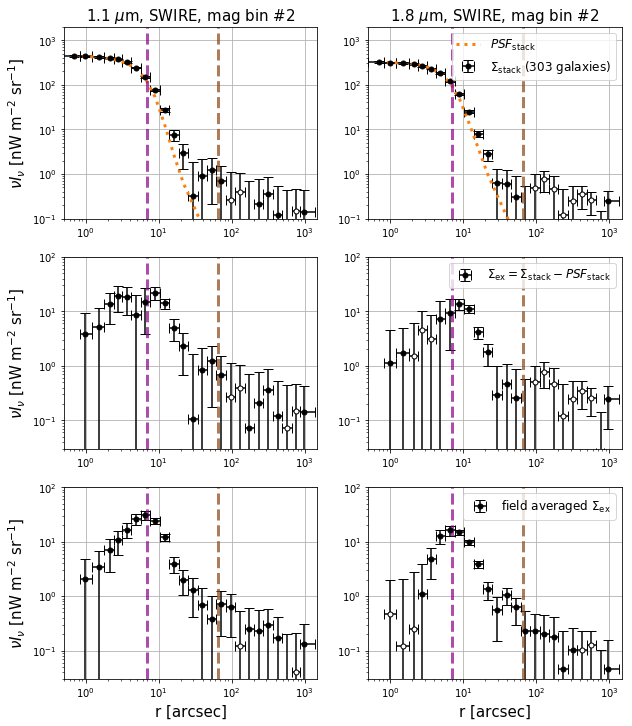

In [229]:
from stack import *

im = 1
m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
ifield = 8

fig, ax = plt.subplots(3,2, figsize = (10,12))
for inst in [1,2]:
    stackdat = stacking(inst, ifield, m_min, m_max,
            load_from_file=True, BGsub=False).stackdat
    plot_err_log(stackdat['rbins'], 
                 stackdat['profcb'],
                 np.sqrt(np.diag(stackdat['cov']['profcb'])),
                 ax=ax[0][inst-1], color='k',
                 label= r'$\Sigma_{\rm stack}$ (%d galaxies)'% stackdat['Nsrc'])
    ax[0][inst-1].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                  'C1:', lw=3, label=r'$PSF_{\rm stack}$')
    ax[0][inst-1].set_ylim([1e-1,2e3])
    ax[0][inst-1].set_xlim([5e-1,1.5e3])
    ax[0][inst-1].grid()    
    ax[0][0].set_ylabel(r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
    ax[0][0].set_title('1.1 $\mu$m, %s, '%fieldnamedict[ifield] \
                       + 'mag bin #2', fontsize=15)
    ax[0][1].set_title('1.8 $\mu$m, %s, '%fieldnamedict[ifield] \
                       + 'mag bin #2', fontsize=15)
    ax[0][1].legend(fontsize=12)
    ax[0][inst-1].axvline(66, c='saddlebrown', lw=3, alpha=0.7,ls='--')
    ax[0][inst-1].axvline(7, c='darkmagenta',lw=3, alpha=0.7,ls='--')

    plot_err_log(stackdat['rbins'], 
                 stackdat['ex']['profcb'],
                 np.sqrt(np.diag(stackdat['excov']['profcb'])),
                 ax=ax[1][inst-1], color='k',
                 label=r'$\Sigma_{\rm ex}=\Sigma_{\rm stack} - PSF_{\rm stack}$')
    ax[1][inst-1].set_ylim([3e-2,1e2])
    ax[1][inst-1].set_xlim([5e-1,1.5e3])
    ax[1][0].set_ylabel(r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
    ax[1][inst-1].grid()    
    ax[1][1].legend(fontsize=12)
    ax[1][inst-1].axvline(66, c='saddlebrown', lw=3, alpha=0.7,ls='--')
    ax[1][inst-1].axvline(7, c='darkmagenta',lw=3, alpha=0.7,ls='--')
    
    profd_arr, profd_err = 0, 0
    for ifield in [4,5,6,7,8]:
        stackdat = stacking(inst, ifield, m_min, m_max,
                            load_from_file=True, BGsub=False).stackdat

        profd_arri = stackdat['ex']['profcb']
        profd_erri = np.sqrt(np.diag(stackdat['excov']['profcb']))
        profd_arr += profd_arri / profd_erri**2
        profd_err += 1 / profd_erri**2
    profd_arr /= profd_err
    profd_err = np.sqrt(1 / profd_err)
    plot_err_log(stackdat['rbins'], 
                 profd_arr,
                 profd_err,
                 ax=ax[2][inst-1], color='k',label=r'field averaged $\Sigma_{\rm ex}$')
    ax[2][inst-1].set_ylim([3e-2,1e2])
    ax[2][inst-1].set_xlim([5e-1,1.5e3])
    ax[2][inst-1].grid()   
    ax[2][0].set_ylabel(r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
    ax[2][inst-1].set_xlabel('r [arcsec]', fontsize=15)
    ax[2][1].legend(fontsize=12)
    ax[2][inst-1].axvline(66, c='saddlebrown', lw=3, alpha=0.7,ls='--')
    ax[2][inst-1].axvline(7, c='darkmagenta',lw=3, alpha=0.7,ls='--')
    
plt.savefig('plots/paperfig/stack_profile.pdf', dpi = 150, bbox_inches='tight')

# z, M*, Mh, R200 distribution

#### MRR catalog
From MZ, SED fitting In SWIRE

AEGIS: 
https://aegis.ucolick.org/tech_overview.html#derived_data<br>
https://arxiv.org/pdf/astro-ph/0607355.pdf<br>
Not overlap with CIBER

In [231]:
# print fraction of stacked sources is central
from micecat import *

df = get_micecat_df(1, add_Rvir=True)
DM = 5 * np.log10((cosmo.luminosity_distance(df['z_cgal']) / (10 * u.pc)).decompose()).value
df['M_I'] = df['I'] - DM + (2.5 * np.log10(1+df['z_cgal']))

for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    dfi = df.loc[(df['I']>=m_min) & (df['I']<m_max)]
    print('mag bin %d, fcen = %.2f'%(im, np.sum(dfi['flag_central']==0)/len(dfi)))
dfi = df.loc[(df['I']>=17) & (df['I']<20)]
print('mag bin all, fcen = %.2f'%(np.sum(dfi['flag_central']==0)/len(dfi)))
    
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    dfi = df.loc[(df['I']>=m_min) & (df['I']<m_max) & (df['M_I']>=M_min) & (df['M_I']<M_max)]
    print('m+M bin %d, fcen = %.2f'%(i, np.sum(dfi['flag_central']==0)/len(dfi)))

MICECAT field 1, 2 < ra < 4, 0 < dec < 2
mag bin 0, fcen = 0.65
mag bin 1, fcen = 0.67
mag bin 2, fcen = 0.62
mag bin 3, fcen = 0.63
mag bin all, fcen = 0.63
m+M bin 0, fcen = 0.66
m+M bin 1, fcen = 0.62
m+M bin 2, fcen = 0.66
m+M bin 3, fcen = 0.57
m+M bin 4, fcen = 0.58


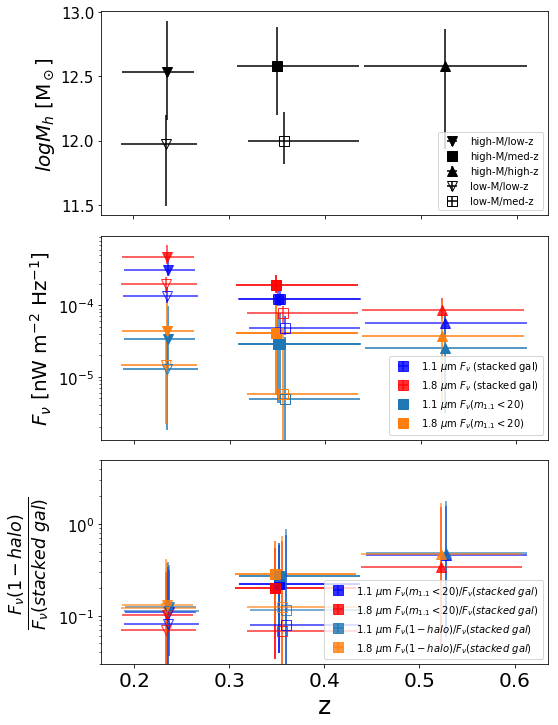

In [232]:
from micecat import *
from srcmap import *
from mask import * 

# df = get_micecat_df(1, add_Rvir=True)
# make_srcmap_class1 = make_srcmap(1)
# make_srcmap_class2 = make_srcmap(2)

fig, ax = plt.subplots(3,1, figsize=(8,12))
for i,(im,M_min,M_max,name,fmt,mfc,) in enumerate(zip([1,2,3,2,3],
                                                      [-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21],
                                       ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'],
                                        ['v','s','^','v','s'],[None, None, None, 'none', 'none'])): 
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    dfm = df.loc[(df['I']>=m_min) & (df['I']<m_max) & (df['M_I']>=M_min) & (df['M_I']<M_max)]
    fcent = np.sum(dfm['flag_central']==0)/len(dfm)
    galids = np.array(dfm.index)
    haloids = dfm['unique_halo_id'].values
    shuffle_idx = np.random.permutation(len(dfm))
    galids, haloids = galids[shuffle_idx], haloids[shuffle_idx]
    flagc_arr = []
    z_arr = []
    Mh_arr = []
    Ngal_arr = []
    Ftot_arr1 = []
    Fgal_arr1 = []
    Ffaint_arr1 = []
    Fbright_arr1 = []
    Fbrightm_arr1 = []
    Ftot_arr2 = []
    Fgal_arr2 = []
    Ffaint_arr2 = []
    Fbright_arr2 = []
    Fbrightm_arr2 = []
    for igal, (haloid, galid) in enumerate(zip(haloids, galids)):
        if igal > 500:
            break
        if igal%50==0:
            print(i,igal)
        dfi = df[df['unique_halo_id']==haloid].copy()
        dfi['stack_gal_id'] = galid
        Rvi = np.mean(dfi['Rv_arcsec'].values)
        Mh = 10**np.mean(dfi['lmhalo'].values)
        if (Rvi > 0) and (Mh > 1e14):
            continue
        Fnu_arr1 = 3631 * 10**(-dfi['I'].values/2.5)
        Fnu_arr2 = 3631 * 10**(-dfi['H'].values/2.5)
        flagc_arr.append(float(dfi[dfi.index==galid]['flag_central']))
        z_arr.append(float(dfi[dfi.index==galid]['z_cgal']))
        Mh_arr.append(float(dfi[dfi.index==galid]['lmhalo']))
        Ngal_arr.append(len(dfi))
        Ftot_arr1.append(np.sum(Fnu_arr1))
        Ftot_arr2.append(np.sum(Fnu_arr2))
        Fgal_arr1.append(float(Fnu_arr1[dfi.index==galid]))
        Fgal_arr2.append(float(Fnu_arr2[dfi.index==galid]))
        Ffaint_arr1.append(np.sum(Fnu_arr1[dfi['I']>20]))
        Ffaint_arr2.append(np.sum(Fnu_arr2[dfi['I']>20]))
        
        spb = np.where((dfi['I']<=20) & (dfi.index!=galid))[0]
        if len(spb)!=0:
            dfib = dfi.iloc[spb]
            Fbright_arr1.append(np.sum(Fnu_arr1[spb]))
            Fbright_arr2.append(np.sum(Fnu_arr2[spb]))
            x_arr = dfib['x'].values
            x_arr = x_arr - int(x_arr[0]) + 512
            y_arr = dfib['y'].values
            y_arr = y_arr - int(y_arr[0]) + 512
            mI_arr, mH_arr = dfib['I'].values, dfib['H'].values
            make_srcmap_class1.xls = np.array(x_arr)
            make_srcmap_class1.yls = np.array(y_arr)
            make_srcmap_class1.ms = np.array(mI_arr)
            make_srcmap_class1.ms_inband = np.array(mI_arr)
            make_srcmap_class2.xls = np.array(x_arr)
            make_srcmap_class2.yls = np.array(y_arr)
            make_srcmap_class2.ms = np.array(mI_arr)
            make_srcmap_class2.ms_inband = np.array(mH_arr)

            srcmap1 = make_srcmap_class1.run_srcmap(ptsrc=True, verbose=False)
            srcmap2 = make_srcmap_class2.run_srcmap(ptsrc=True, verbose=False)
            mask = Ith_mask_mock(x_arr,y_arr, mI_arr, verbose=False)[0]
            Fbrightm_arr1.append(np.sum(srcmap1*mask)/np.sum(srcmap1) * Fbright_arr1[-1])
            Fbrightm_arr2.append(np.sum(srcmap2*mask)/np.sum(srcmap2) * Fbright_arr2[-1])
        else:
            Fbright_arr1.append(0.)
            Fbright_arr2.append(0.)
            Fbrightm_arr1.append(0.)
            Fbrightm_arr2.append(0.)
            
    flagc_arr = np.array(flagc_arr)
    z_arr = np.array(z_arr)
    Mh_arr = np.array(Mh_arr)
    Ngal_arr = np.array(Ngal_arr)
    Ftot_arr1 = np.array(Ftot_arr1)
    Fgal_arr1 = np.array(Fgal_arr1)
    Ffaint_arr1 = np.array(Ffaint_arr1)
    Fbright_arr1 = np.array(Fbright_arr1)
    Fbrightm_arr1 = np.array(Fbrightm_arr1)
    Ftot_arr2 = np.array(Ftot_arr2)
    Fgal_arr2 = np.array(Fgal_arr2)
    Ffaint_arr2 = np.array(Ffaint_arr2)
    Fbright_arr2 = np.array(Fbright_arr2)
    Fbrightm_arr2 = np.array(Fbrightm_arr2)
    
    z = np.median(z_arr)
    z_low = np.percentile(z_arr, 16)
    z_high = np.percentile(z_arr, 84)
    
    Mh = np.median(Mh_arr)
    Mh_low = np.percentile(Mh_arr,16)
    Mh_high = np.percentile(Mh_arr,84)
    
    Ftot1 = np.median(Ftot_arr1-Fgal_arr1)
    Ftot_low1 = np.percentile(Ftot_arr1-Fgal_arr1,16)
    Fto_high1 = np.percentile(Ftot_arr1-Fgal_arr1,84)

    Fgal1 = np.median(Fgal_arr1)
    Fgal_low1 = np.percentile(Fgal_arr1,16)
    Fgal_high1 = np.percentile(Fgal_arr1,84)
    
    Ffaint1 = np.median(Ffaint_arr1)
    Ffaint_low1 = np.percentile(Ffaint_arr1,16)
    Ffaint_high1 = np.percentile(Ffaint_arr1,84)
    
    Fbright1 = np.median(Fbrightm_arr1)
    Fbright_low1 = np.percentile(Fbrightm_arr1,16)
    Fbright_high1 = np.percentile(Fbrightm_arr1,84)
    
    rf1 = np.median(Ffaint_arr1/Fgal_arr1)
    rf_low1 = np.percentile(Ffaint_arr1/Fgal_arr1,16)
    rf_high1 = np.percentile(Ffaint_arr1/Fgal_arr1,84)

    rt1 = np.median(Ftot_arr1/Fgal_arr1)
    rt_low1 = np.percentile(Ftot_arr1/Fgal_arr1,16)
    rt_high1 = np.percentile(Ftot_arr1/Fgal_arr1,84)

    rbf1 = np.median((Ffaint_arr1+Fbrightm_arr1)/Fgal_arr1)
    rbf_low1 = np.percentile((Ffaint_arr1+Fbrightm_arr1)/Fgal_arr1,16)
    rbf_high1 = np.percentile((Ffaint_arr1+Fbrightm_arr1)/Fgal_arr1,84)

    Ftot2 = np.median(Ftot_arr2-Fgal_arr2)
    Ftot_low2 = np.percentile(Ftot_arr2-Fgal_arr2,16)
    Ftot_high2 = np.percentile(Ftot_arr2-Fgal_arr2,84)

    Fgal2 = np.median(Fgal_arr2)
    Fgal_low2 = np.percentile(Fgal_arr2,16)
    Fgal_high2 = np.percentile(Fgal_arr2,84)
    
    Ffaint2 = np.median(Ffaint_arr2)
    Ffaint_low2 = np.percentile(Ffaint_arr2,16)
    Ffaint_high2 = np.percentile(Ffaint_arr2,84)

    Fbright2 = np.median(Fbrightm_arr2)
    Fbright_low2 = np.percentile(Fbrightm_arr2,16)
    Fbright_high2 = np.percentile(Fbrightm_arr2,84)

    rt2 = np.median(Ftot_arr2/Fgal_arr2)
    rt_low2 = np.percentile(Ftot_arr2/Fgal_arr2,16)
    rt_high2 = np.percentile(Ftot_arr2/Fgal_arr2,84)
    
    rf2 = np.median(Ffaint_arr2/Fgal_arr2)
    rf_low2 = np.percentile(Ffaint_arr2/Fgal_arr2,16)
    rf_high2 = np.percentile(Ffaint_arr2/Fgal_arr2,84)
    
    rbf2 = np.median((Ffaint_arr2+Fbrightm_arr2)/Fgal_arr2)
    rbf_low2 = np.percentile((Ffaint_arr2+Fbrightm_arr2)/Fgal_arr2,16)
    rbf_high2 = np.percentile((Ffaint_arr2+Fbrightm_arr2)/Fgal_arr2,84)
    
    ax[0].errorbar([z], [Mh], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[Mh_high - Mh],[Mh - Mh_low]], alpha=1,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='k', label = name)
    ax[1].errorbar([z*1.001], [Fgal1], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[Fgal1-Fgal_low1],[Fgal_high1-Fgal1]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b')
    ax[1].errorbar([z*0.995], [Fgal2], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[Fgal2-Fgal_low2],[Fgal_high2-Fgal2]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
    ax[1].errorbar([z*1.001], [Ffaint1], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[Ffaint1-Ffaint_low1],[Ffaint_high1-Ffaint1]],
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C0')
    ax[1].errorbar([z*0.995], [Ffaint2], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[Ffaint2-Ffaint_low2],[Ffaint_high2-Ffaint2]],
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C1')
    if i==1:
        ax[1].errorbar([z*1.005], [Fgal1], xerr=[[z-z_low],[z_high-z]],
                       yerr=[[Fgal1-Fgal_low1],[Fgal_high1-Fgal1]], alpha=0.8,
                        fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b',
                       label = r'1.1 $\mu$m $F_{\nu}$ (stacked gal)')
        ax[1].errorbar([z*0.995], [Fgal2], xerr=[[z-z_low],[z_high-z]],
                       yerr=[[Fgal2-Fgal_low2],[Fgal_high2-Fgal2]], alpha=0.8,
                        fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r',
                       label = r'1.8 $\mu$m $F_{\nu}$ (stacked gal)')
        ax[1].errorbar([z*1.005], [Ffaint1], xerr=[[z-z_low],[z_high-z]],
                       yerr=[[Ffaint1-Ffaint_low1],[Ffaint_high1-Ffaint1]], alpha=1,
                        fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C0', 
                       label = r'1.1 $\mu$m $F_{\nu}(m_{\rm 1.1}<20)$')
        ax[1].errorbar([z*0.995], [Ffaint2], xerr=[[z-z_low],[z_high-z]],
                       yerr=[[Ffaint2-Ffaint_low2],[Ffaint_high2-Ffaint2]], alpha=1,
                        fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C1',
                       label = r'1.8 $\mu$m $F_{\nu}(m_{\rm 1.1}<20)$')

        ax[2].errorbar([z*1.005], [rf1], xerr=[[z-z_low],[z_high-z]],
                       yerr=[[rf1-rf_low1],[rf_high1-rf1]], alpha=0.8,
                        fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                       label = r'1.1 $\mu$m $F_{\nu}(m_{\rm 1.1}<20)/F_{\nu}(stacked\,\,gal)$')

        ax[2].errorbar([z*0.995], [rf2], xerr=[[z-z_low],[z_high-z]],
                       yerr=[[rf2-rf_low2],[rf_high2-rf2]], alpha=0.8,
                        fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r', 
                       label=r'1.8 $\mu$m $F_{\nu}(m_{\rm 1.1}<20)/F_{\nu}(stacked\,\,gal)$')

        ax[2].errorbar([z*1.005], [rbf1], xerr=[[z-z_low],[z_high-z]],
                       yerr=[[rbf1-rbf_low1],[rbf_high1-rbf1]], alpha=0.8,
                        fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C0',
                       label=r'1.1 $\mu$m $F_{\nu} (1-halo)$/$F_{\nu}(stacked\,\,gal)$')
        ax[2].errorbar([z*0.995], [rbf2], xerr=[[z-z_low],[z_high-z]],
                       yerr=[[rbf2-rbf_low2],[rbf_high2-rbf2]], alpha=0.8,
                        fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C1',
                       label=r'1.8 $\mu$m $F_{\nu} (1-halo)$/$F_{\nu}(stacked\,\,gal)$')

    ax[2].errorbar([z*1.005], [rf1], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[rf1-rf_low1],[rf_high1-rf1]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b')
    
    ax[2].errorbar([z*0.995], [rf2], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[rf2-rf_low2],[rf_high2-rf2]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
    
    ax[2].errorbar([z*1.005], [rbf1], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[rbf1-rbf_low1],[rbf_high1-rbf1]], alpha=0.8,
                   fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C0')
    ax[2].errorbar([z*0.995], [rbf2], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[rbf2-rbf_low2],[rbf_high2-rbf2]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C1')
    
ax[0].legend(loc=4)
ax[1].legend(loc=4)
ax[2].legend(loc=4,)
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('z', fontsize=25)
ax[2].set_ylim([3e-2,5e0])
ax[0].set_ylabel(r'$logM_h$ [M$_\odot$]', fontsize=20)
ax[1].set_ylabel(r'$F_{\nu}$ [nW m$^{-2}$ Hz$^{-1}$]', fontsize=20)
ax[2].set_ylabel(r'$\frac{F_{\nu}(1-halo)}{F_{\nu}(stacked\,\,gal)}$', fontsize=25)
ax[2].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='x',labelbottom=False)
ax[1].tick_params(axis='x',labelbottom=False)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)
plt.subplots_adjust(hspace=0.1)
# plt.savefig('plots/paperfig/micecat_f1h.pdf', dpi = 100, bbox_inches='tight')
clear_output()

MICECAT field 1, 2 < ra < 4, 0 < dec < 2
m+M bin 0, fcen = 0.66
m+M bin 1, fcen = 0.62
m+M bin 2, fcen = 0.66
m+M bin 3, fcen = 0.57
m+M bin 4, fcen = 0.58


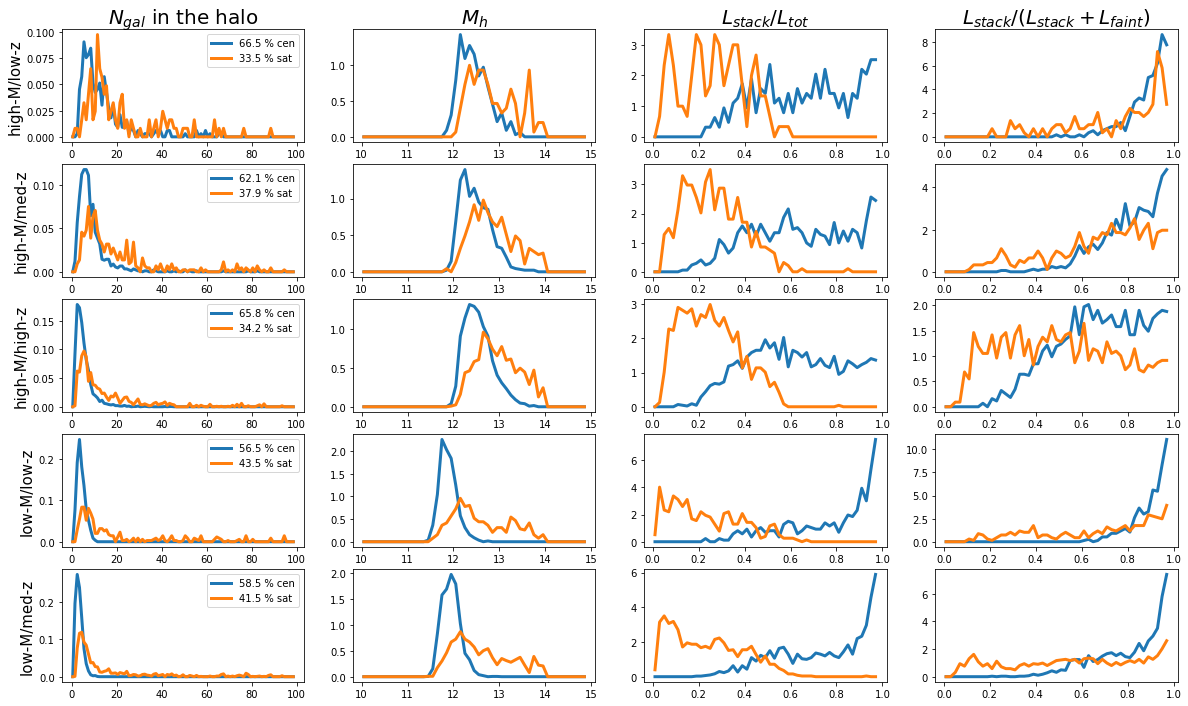

In [233]:
from micecat import *

df = get_micecat_df(1, add_Rvir=True)
fig, ax = plt.subplots(5,4, figsize=(20,12))
for i,(im,M_min,M_max,name) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21],
                                       ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    dfm = df.loc[(df['I']>=m_min) & (df['I']<m_max) & (df['M_I']>=M_min) & (df['M_I']<M_max)]
    fcent = np.sum(dfm['flag_central']==0)/len(dfm)
    print('m+M bin %d, fcen = %.2f'%(i, fcent))
    galids = np.array(dfm.index)
    haloids = dfm['unique_halo_id'].values
    shuffle_idx = np.random.permutation(len(dfm))
    galids, haloids = galids[shuffle_idx], haloids[shuffle_idx]
    flagc_arr = []
    z_arr = []
    Mh_arr = []
    Ngal_arr = []
    Ftot_arr = []
    Fgal_arr = []
    Ffaint_arr = []
    for _, (haloid, galid) in enumerate(zip(haloids, galids)):
        dfi = df[df['unique_halo_id']==haloid].copy()
        dfi['stack_gal_id'] = galid
        Rvi = np.mean(dfi['Rv_arcsec'].values)
        Mh = 10**np.mean(dfi['lmhalo'].values)
        if (Rvi > 0) and (Mh > 1e14):
            continue
            
        Fnu_arr = 3631 * 10**(-dfi['I']/2.5)
        flagc_arr.append(float(dfi[dfi.index==galid]['flag_central']))
        z_arr.append(float(dfi[dfi.index==galid]['z_cgal']))
        Mh_arr.append(float(dfi[dfi.index==galid]['lmhalo']))
        Ngal_arr.append(len(dfi))
        Ftot_arr.append(np.sum(Fnu_arr))
        Fgal_arr.append(float(Fnu_arr[dfi.index==galid]))
        Ffaint_arr.append(np.sum(Fnu_arr[dfi['I']>20]))
    flagc_arr = np.array(flagc_arr)
    z_arr = np.array(z_arr)
    Mh_arr = np.array(Mh_arr)
    Ngal_arr = np.array(Ngal_arr)
    Ftot_arr = np.array(Ftot_arr)
    Fgal_arr = np.array(Fgal_arr)
    Ffaint_arr = np.array(Ffaint_arr)
    
    binedges = np.arange(0,100,1)
    bins = (binedges[1:]+binedges[:-1])/2
    h = np.histogram(Ngal_arr[flagc_arr==0], bins=binedges)[0]
    ax[i][0].plot(bins, h/np.sum(h)/np.diff(bins)[0], lw=3,  c='C0', label='%.1f %% cen'%(fcent*100))
    h = np.histogram(Ngal_arr[flagc_arr==1], bins=binedges)[0]
    ax[i][0].plot(bins, h/np.sum(h)/np.diff(bins)[0], lw=3,  c='C1', label='%.1f %% sat'%(100-fcent*100))
    ax[0][0].set_title(r'$N_{gal}$ in the halo', fontsize=20)
    ax[i][0].set_ylabel(name,fontsize=15)
    
    binedges = np.arange(10,15,0.1)
    bins = (binedges[1:]+binedges[:-1])/2
    h = np.histogram(Mh_arr[flagc_arr==0], bins=binedges)[0]
    ax[i][1].plot(bins, h/np.sum(h)/np.diff(bins)[0], lw=3,  c='C0')
    h = np.histogram(Mh_arr[flagc_arr==1], bins=binedges)[0]
    ax[i][1].plot(bins, h/np.sum(h)/np.diff(bins)[0], lw=3,  c='C1')
    ax[0][1].set_title(r'$M_{h}$', fontsize=20)

    binedges = np.arange(0,1,0.02)
    bins = (binedges[1:]+binedges[:-1])/2
    h = np.histogram(Fgal_arr[flagc_arr==0]/Ftot_arr[flagc_arr==0], bins=binedges)[0]
    ax[i][2].plot(bins, h/np.sum(h)/np.diff(bins)[0], lw=3,  c='C0', label='cen')
    h = np.histogram(Fgal_arr[flagc_arr==1]/Ftot_arr[flagc_arr==1], bins=binedges)[0]
    ax[i][2].plot(bins, h/np.sum(h)/np.diff(bins)[0], lw=3,  c='C1', label='sat')
    ax[0][2].set_title(r'$L_{stack}/L_{tot}$', fontsize=20)
    
    binedges = np.arange(0,1,0.02)
    bins = (binedges[1:]+binedges[:-1])/2
    h = np.histogram(Fgal_arr[flagc_arr==0]/(Fgal_arr[flagc_arr==0]+Ffaint_arr[flagc_arr==0]),
                     bins=binedges)[0]
    ax[i][3].plot(bins, h/np.sum(h)/np.diff(bins)[0], lw=3,  c='C0', label='cen')
    h = np.histogram(Fgal_arr[flagc_arr==1]/(Fgal_arr[flagc_arr==1]+Ffaint_arr[flagc_arr==1]),
                     bins=binedges)[0]
    ax[i][3].plot(bins, h/np.sum(h)/np.diff(bins)[0], lw=3,  c='C1', label='sat')
    ax[0][3].set_title(r'$L_{stack}/(L_{stack}+L_{faint})$', fontsize=20)
    ax[i][0].legend()

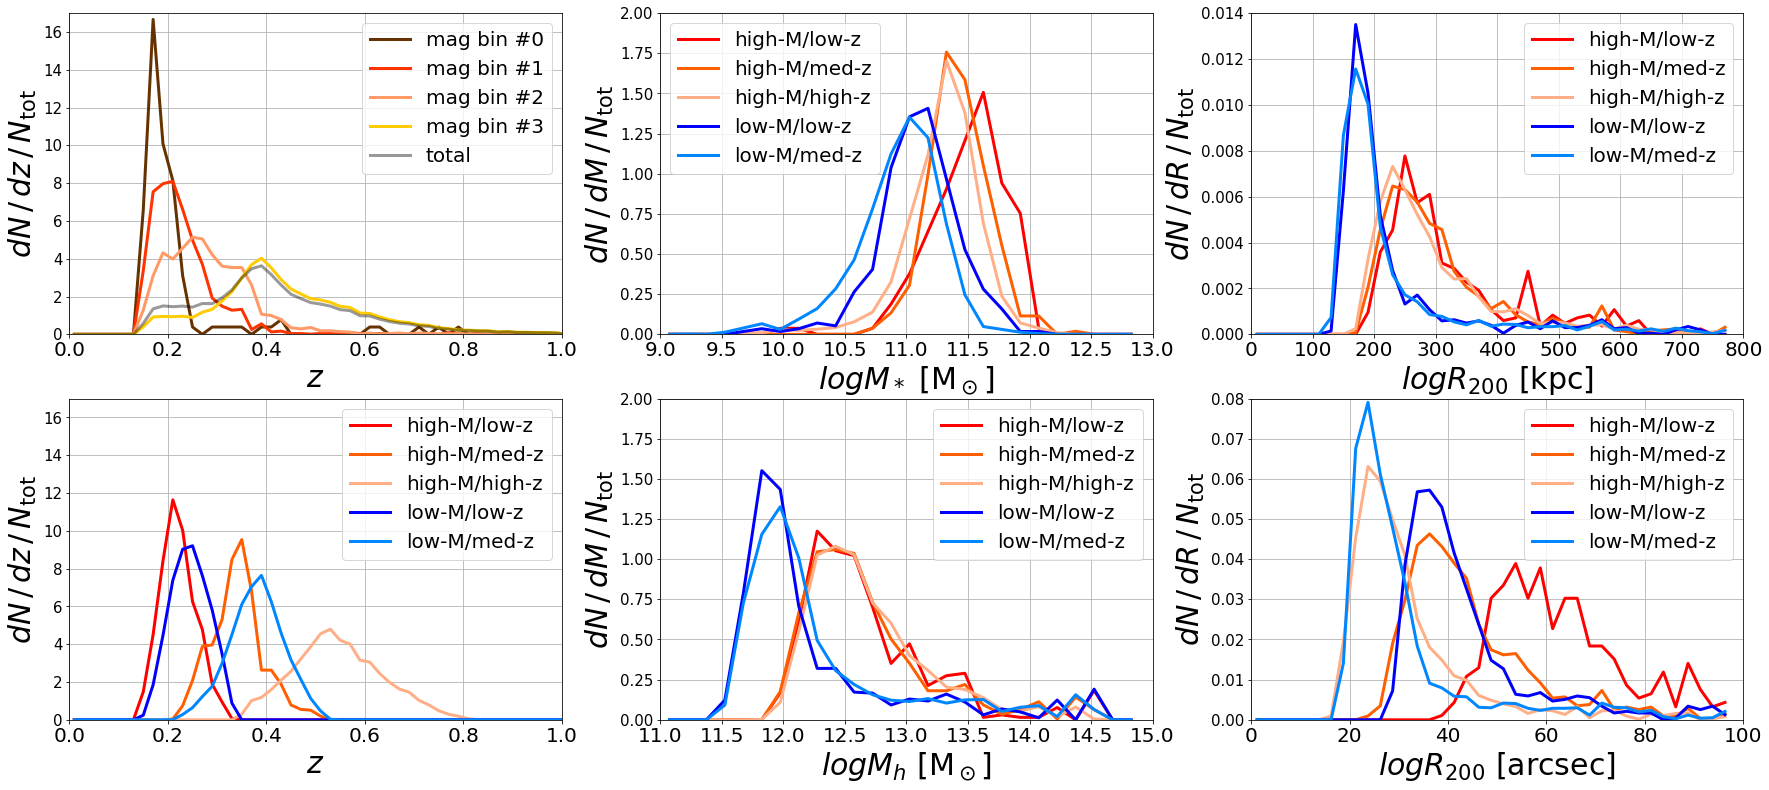

In [234]:
from stack_ancillary import *
from micecat import *
from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

df = get_micecat_df(0, add_Rvir=True)
DM = 5 * np.log10((cosmo.luminosity_distance(df['z_cgal']) / (10 * u.pc)).decompose()).value
df['M_I'] = df['I'] - DM + (2.5 * np.log10(1+df['z_cgal']))

mrrdata = loadmat(mypaths['ciberdir']+'doc/20170617_Stacking/maps/mrrcats/mrr_cat_SWIRE.mat')
dfmrr = pd.DataFrame()
column_names = ['ra','dec','zm','zme','mst','z','av','ze','npts','mass'] # data['cat'][0].dtype
for i,name in enumerate(column_names):
    dfmrr[name] = mrrdata['cat'][0,0][i].flatten()
dfmrr = dfmrr.loc[dfmrr['mst']>0]
dfmrr = dfmrr.loc[dfmrr['mass']!=0]

data = {}
# mag bins
data['mag'] = {}
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    print(im)
    data['mag'][im] = {}
    zs = np.array([])
    for i,ifield in enumerate([4,5,6,7,8]):
        mask_inst1, mask_inst2 = \
        load_processed_images(data_maps, 
                              return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
        field = fieldnamedict[ifield]
        srcdat = ps_src_select(1, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], sample_type='all')
        z = np.array(srcdat['zg_arr'])
        zs = np.concatenate((zs,z))
       
    dfps = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[8] + '.csv')
    dfps = dfps.iloc[srcdat['idxg_arr']]
    dfps, dfmrr1 = match_catalog_by_coord(dfps,dfmrr)
    dfps['mass'] = dfmrr1['mass'].values
    data['mag'][im]['logMstr'] = dfps['mass'].values
    
    data['mag'][im]['z'] = zs
    dfi = df.loc[(df['I']>=m_min) & (df['I']<m_max)]
    data['mag'][im]['logMh'] = dfi['lmhalo'].values
    data['mag'][im]['Rv_kpc'] = dfi['Rv_Mpc'].values * 1e3
    data['mag'][im]['Rv_arcsec'] = dfi['Rv_arcsec'].values

data['mag']['all'] = {}
data['mag']['all']['z'] = np.concatenate((data['mag'][1]['z'],
                                          data['mag'][2]['z'],data['mag'][3]['z']))
data['mag']['all']['logMh'] = np.concatenate((data['mag'][1]['logMh'],
                                          data['mag'][2]['logMh'],data['mag'][3]['logMh']))
data['mag']['all']['logMstr'] = np.concatenate((data['mag'][1]['logMstr'],
                                          data['mag'][2]['logMstr'],data['mag'][3]['logMstr']))
data['mag']['all']['Rv_kpc'] = np.concatenate((data['mag'][1]['Rv_kpc'],
                                          data['mag'][2]['Rv_kpc'],data['mag'][3]['Rv_kpc']))
data['mag']['all']['Rv_arcsec'] = np.concatenate((data['mag'][1]['Rv_arcsec'],
                                          data['mag'][2]['Rv_arcsec'],data['mag'][3]['Rv_arcsec']))


# mag + Mag bins
data['Mag'] = {}
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    data['Mag'][i] = {}
    zs = np.array([])
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    for ifield in [4,5,6,7,8]:
        mask_inst1, mask_inst2 = \
        load_processed_images(data_maps, 
                              return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
        field = fieldnamedict[ifield]
        srcdat = ps_src_select(1, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], Mabs_min=M_min, Mabs_max=M_max,sample_type='all')
        z = np.array(srcdat['zg_arr'])
        zs = np.concatenate((zs,z))

    dfps = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[8] + '.csv')
    dfps = dfps.iloc[srcdat['idxg_arr']]
    dfps, dfmrr1 = match_catalog_by_coord(dfps,dfmrr)
    dfps['mass'] = dfmrr1['mass'].values
    data['Mag'][i]['logMstr'] = dfps['mass'].values
    
    data['Mag'][i]['z'] = zs
    dfi = df.loc[(df['I']>=m_min) & (df['I']<m_max) & (df['M_I']>=M_min) & (df['M_I']<M_max)]
    data['Mag'][i]['logMh'] = dfi['lmhalo'].values
    data['Mag'][i]['Rv_kpc'] = dfi['Rv_Mpc'].values * 1e3
    data['Mag'][i]['Rv_arcsec'] = dfi['Rv_arcsec'].values

dz = 0.02
zbinedges = np.arange(0,1.1,dz)
zbins = (zbinedges[1:] + zbinedges[:-1]) / 2
logMhbinedges = np.arange(11,15,0.15)
logMhbins = (logMhbinedges[1:] + logMhbinedges[:-1]) / 2
logMstrbinedges = np.arange(9,13,0.15)
logMstrbins = (logMstrbinedges[1:] + logMstrbinedges[:-1]) / 2
Rvkpcbinedges = np.arange(0,800,20)
Rvkpcbins = (Rvkpcbinedges[1:] + Rvkpcbinedges[:-1]) / 2
Rvarcsecbinedges = np.arange(0,100,2.5)
Rvarcsecbins = (Rvarcsecbinedges[1:] + Rvarcsecbinedges[:-1]) / 2

fig, ax = plt.subplots(2, 3, figsize = (30, 13))
for im,(m_min,m_max,c) in enumerate(zip(magbindict['m_min'],magbindict['m_max'],
                                       ['#663300','#ff3300','#ff9966','#ffcc00'])):
    print('mag bin %d, Nsrc = %d'%(im, len(data['mag'][im]['z'])))
    print('mag bin %d, z = %.2f + %.2f - %.2f'%(im, np.median(data['mag'][im]['z']),
            np.percentile(data['mag'][im]['z'],16),np.percentile(data['mag'][im]['z'],84)))
    print('mag bin %d, M* = %.1f + %.1f - %.1f'%(im, np.median(data['mag'][im]['logMstr']),
            np.percentile(data['mag'][im]['logMstr'],16),np.percentile(data['mag'][im]['logMstr'],84)))
    print('mag bin %d, Mh = %.1f + %.1f - %.1f'%(im, np.median(data['mag'][im]['logMh']),
            np.percentile(data['mag'][im]['logMh'],16),np.percentile(data['mag'][im]['logMh'],84)))
    print('mag bin %d, Rv(kpc) = %.1f + %.1f - %.1f'%(im, np.median(data['mag'][im]['Rv_kpc']),
            np.percentile(data['mag'][im]['Rv_kpc'],16),np.percentile(data['mag'][im]['Rv_kpc'],84)))
    print('mag bin %d, Rv(arcsec) = %.1f + %.1f - %.1f'%(im, np.median(data['mag'][im]['Rv_arcsec']),
            np.percentile(data['mag'][im]['Rv_arcsec'],16),np.percentile(data['mag'][im]['Rv_arcsec'],84)))
    print('=========================')
    h = np.histogram(data['mag'][im]['z'], bins=zbinedges)[0]
    ax[0][0].plot(zbins, h/np.sum(h)/dz, lw=3,  c=c,
        label='mag bin #%d'%im)
    
im,m_min, m_max = 'all',17,20
print('mag bin tot, Nsrc = %d'%(len(data['mag'][im]['z'])))
print('mag bin tot, z = %.2f + %.2f - %.2f'%(np.median(data['mag'][im]['z']),
        np.percentile(data['mag'][im]['z'],16),np.percentile(data['mag'][im]['z'],84)))
print('mag bin tot, M* = %.1f + %.1f - %.1f'%(np.median(data['mag'][im]['logMstr']),
        np.percentile(data['mag'][im]['logMstr'],16),np.percentile(data['mag'][im]['logMstr'],84)))
print('mag bin tot, Mh = %.1f + %.1f - %.1f'%(np.median(data['mag'][im]['logMh']),
        np.percentile(data['mag'][im]['logMh'],16),np.percentile(data['mag'][im]['logMh'],84)))
print('mag bin tot, Rv(kpc) = %.1f + %.1f - %.1f'%(np.median(data['mag'][im]['Rv_kpc']),
        np.percentile(data['mag'][im]['Rv_kpc'],16),np.percentile(data['mag'][im]['Rv_kpc'],84)))
print('mag bin tot, Rv(arcsec) = %.1f + %.1f - %.1f'%(np.median(data['mag'][im]['Rv_arcsec']),
        np.percentile(data['mag'][im]['Rv_arcsec'],16),np.percentile(data['mag'][im]['Rv_arcsec'],84)))
print('=========================')
h = np.histogram(data['mag'][im]['z'], bins=zbinedges)[0]
ax[0][0].plot(zbins, h/np.sum(h)/dz, lw=3,  c='k', alpha=0.4,
    label='total')

for i,(im,M_min,M_max,c,name) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21],
                                         ['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    print('mag bin %d, Nsrc = %d'%(i,len(data['Mag'][i]['z'])))
    print('Mag bin %d, z = %.2f + %.2f - %.2f'%(i, np.median(data['Mag'][i]['z']),
            np.percentile(data['Mag'][i]['z'],16),np.percentile(data['Mag'][i]['z'],84)))
    print('Mag bin %d, M* = %.1f + %.3f - %.1f'%(i, np.median(data['Mag'][i]['logMstr']),
            np.percentile(data['Mag'][i]['logMstr'],16),np.percentile(data['Mag'][i]['logMstr'],84)))
    print('Mag bin %d, Mh = %.1f + %.3f - %.1f'%(i, np.median(data['Mag'][i]['logMh']),
            np.percentile(data['Mag'][i]['logMh'],16),np.percentile(data['Mag'][i]['logMh'],84)))
    print('Mag bin %d, Rv(kpc) = %.1f + %.3f - %.1f'%(i, np.median(data['Mag'][i]['Rv_kpc']),
            np.percentile(data['Mag'][i]['Rv_kpc'],16),np.percentile(data['Mag'][i]['Rv_kpc'],84)))
    print('Mag bin %d, Rv(arcsec) = %.1f + %.3f - %.1f'%(i, np.median(data['Mag'][i]['Rv_arcsec']),
            np.percentile(data['Mag'][i]['Rv_arcsec'],16),np.percentile(data['Mag'][i]['Rv_arcsec'],84)))
    print('=========================')

    h = np.histogram(data['Mag'][i]['z'], bins=zbinedges)[0]
    ax[1][0].plot(zbins, h/np.sum(h)/dz, lw=3,  c=c, label=name)
    
    h = np.histogram(data['Mag'][i]['logMstr'], bins=logMstrbinedges)[0]
    ax[0][1].plot(logMstrbins, h/np.sum(h)/np.diff(logMstrbins)[0], lw=3,  c=c, label=name)
    h = np.histogram(data['Mag'][i]['logMh'], bins=logMhbinedges)[0]
    ax[1][1].plot(logMhbins, h/np.sum(h)/np.diff(logMhbins)[0], lw=3,  c=c, label=name)

    h = np.histogram(data['Mag'][i]['Rv_kpc'], bins=Rvkpcbinedges)[0]
    ax[0][2].plot(Rvkpcbins, h/np.sum(h)/np.diff(Rvkpcbins)[0], lw=3,  c=c, label=name)
    h = np.histogram(data['Mag'][i]['Rv_arcsec'], bins=Rvarcsecbinedges)[0]
    ax[1][2].plot(Rvarcsecbins, h/np.sum(h)/np.diff(Rvarcsecbins)[0], lw=3,  c=c, label=name)

ax[0][0].set_xlabel('$z$', fontsize=30)
ax[0][0].set_ylabel(r'$dN\,/\,dz\,/\,N_{\rm tot}$', fontsize=30)
ax[0][0].tick_params(axis='x', labelsize=20)
ax[0][0].tick_params(axis='y', labelsize=15)
ax[0][0].legend(fontsize=20)
ax[0][0].set_ylim([0,17])
ax[0][0].set_xlim([0,1])
ax[0][0].grid()

ax[1][0].set_xlabel('$z$', fontsize=30)
ax[1][0].set_ylabel(r'$dN\,/\,dz\,/\,N_{\rm tot}$', fontsize=30)
ax[1][0].tick_params(axis='x', labelsize=20)
ax[1][0].tick_params(axis='y', labelsize=15)
ax[1][0].legend(fontsize=20)
ax[1][0].set_ylim([0,17])
ax[1][0].set_xlim([0,1])
ax[1][0].grid()

ax[0][1].set_xlabel('$logM_*$ [M$_\odot$]', fontsize=30)
ax[0][1].set_ylabel(r'$dN\,/\,dM\,/\,N_{\rm tot}$', fontsize=30)
ax[0][1].tick_params(axis='x', labelsize=20)
ax[0][1].tick_params(axis='y', labelsize=15)
ax[0][1].legend(fontsize=20)
ax[0][1].set_ylim([0,2])
ax[0][1].set_xlim([9,13])
ax[0][1].grid()

ax[1][1].set_xlabel('$logM_h$ [M$_\odot$]', fontsize=30)
ax[1][1].set_ylabel(r'$dN\,/\,dM\,/\,N_{\rm tot}$', fontsize=30)
ax[1][1].tick_params(axis='x', labelsize=20)
ax[1][1].tick_params(axis='y', labelsize=15)
ax[1][1].legend(fontsize=20)
ax[1][1].set_ylim([0,2])
ax[1][1].set_xlim([11,15])
ax[1][1].grid()

ax[0][2].set_xlabel('$logR_{200}$ [kpc]', fontsize=30)
ax[0][2].set_ylabel(r'$dN\,/\,dR\,/\,N_{\rm tot}$', fontsize=30)
ax[0][2].tick_params(axis='x', labelsize=20)
ax[0][2].tick_params(axis='y', labelsize=15)
ax[0][2].legend(fontsize=20)
ax[0][2].set_ylim([0,0.014])
ax[0][2].set_xlim([0,800])
ax[0][2].grid()

ax[1][2].set_xlabel('$logR_{200}$ [arcsec]', fontsize=30)
ax[1][2].set_ylabel(r'$dN\,/\,dR\,/\,N_{\rm tot}$', fontsize=30)
ax[1][2].tick_params(axis='x', labelsize=20)
ax[1][2].tick_params(axis='y', labelsize=15)
ax[1][2].legend(fontsize=20)
ax[1][2].set_ylim([0,0.08])
ax[1][2].set_xlim([0,100])
ax[1][2].grid()

clear_output()
# plt.savefig('plots/paperfig/bins_hist.pdf', dpi = 100, bbox_inches='tight')

# PSF

In [235]:
# Check consistency of slopes
m_min, m_max = 4,9
fname = mypaths['alldat'] + 'TM'+ str(inst) + \
'/psfdata_synth_2m_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
with open(fname, "rb") as f:
    profdat = pickle.load(f)

xs = np.log10(profdat['rbins'][11:15])
ys = np.log10(profdat['profcb'][11:15])
es = np.log10(profdat['profcb_err'][11:15])
varslope = np.sum((1/es)**2) / (np.sum((xs/es)**2) * np.sum((1/es)**2) - np.sum(xs/es**2)**2)
eslope_out = np.sqrt(varslope)
slope_out = np.polyfit(np.log10(profdat['rbins'][11:15]),
                    np.log10(profdat['profcb'][11:15]),1)[0]

m_min, m_max = 9,10
fname = mypaths['alldat'] + 'TM'+ str(inst) +\
 '/psfdata_synth_2m_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
with open(fname, "rb") as f:
    profdat = pickle.load(f)

xs = np.log10(profdat['rbins'][11:15])
ys = np.log10(profdat['profcb'][11:15])
es = np.log10(profdat['profcb_err'][11:15])
varslope = np.sum((1/es)**2) / (np.sum((xs/es)**2) * np.sum((1/es)**2) - np.sum(xs/es**2)**2)
eslope_mid = np.sqrt(varslope)
slope_mid = np.polyfit(np.log10(profdat['rbins'][11:15]),
                    np.log10(profdat['profcb'][11:15]),1)[0]

m_min, m_max = 13, 14
fname = mypaths['alldat'] + 'TM'+ str(inst) + \
'/psfdata_synth_ps_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
with open(fname, "rb") as f:
    profdat = pickle.load(f)

xs = np.log10(profdat['rbins'][11:15])
ys = np.log10(profdat['profcb'][11:15])
es = np.log10(profdat['profcb_err'][11:15])
varslope = np.sum((1/es)**2) / (np.sum((xs/es)**2) * np.sum((1/es)**2) - np.sum(xs/es**2)**2)
eslope_in = np.sqrt(varslope)
slope_in = np.polyfit(np.log10(profdat['rbins'][11:15]),
                    np.log10(profdat['profcb'][11:15]),1)[0]
print(slope_out,eslope_out)
print(slope_mid,eslope_mid)
print(slope_in,eslope_in)

-3.199355417600557 6.05151776444475
-3.624767428311885 2.3248229851842854
-3.526083762619149 0.47534979766345564


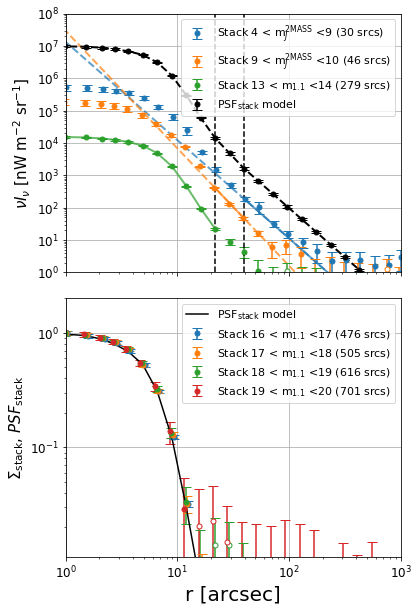

In [269]:
from psfsynth import *
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=[6,10])
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1])
ax0= plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0)
inst = 1
ifield = 8

m_min, m_max = 4,9
fname = mypaths['alldat'] + 'TM'+ str(inst) + \
'/psfdata_synth_2m_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
with open(fname, "rb") as f:
    profdat = pickle.load(f)
plot_err_log(profdat['rbins']*1.02,
             profdat['profcb'],
             profdat['profcb_err'], plot_xerr=False,
             ax=ax0, color='C0',
             label=r'Stack %d < m$_J^{\rm 2MASS}$ <%d (%d srcs)'\
             %(m_min, m_max, profdat['Nsrc']))       
slope_out = np.polyfit(np.log10(profdat['rbins'][11:17]),
                   np.log10(profdat['profcb'][11:17]),1)[0]
proffit = 10 ** (slope_out * np.log10(profdat['rbins']))
proffit = proffit/proffit[13]*profdat['profcb'][13]
ax0.plot(profdat['rbins'], proffit, color='C0', ls='--', lw=2, alpha=0.7)
ax0.plot(profdat['rbins'][13:], proffit[13:], color='C0', lw=2, alpha=0.7)

m_min, m_max = 9,10
fname = mypaths['alldat'] + 'TM'+ str(inst) +\
 '/psfdata_synth_2m_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
with open(fname, "rb") as f:
    profdat = pickle.load(f)
plot_err_log(profdat['rbins']*0.98,
             profdat['profcb'],
             profdat['profcb_err'], plot_xerr=False,
             ax=ax0, color='C1',
             label=r'Stack %d < m$_J^{\rm 2MASS}$ <%d (%d srcs)'%(m_min, m_max, profdat['Nsrc']))
slope_mid = np.polyfit(np.log10(profdat['rbins'][11:15]),
                    np.log10(profdat['profcb'][11:15]),1)[0]
proffit = 10 ** (slope_mid * np.log10(profdat['rbins']))
proffit = proffit/proffit[13]*profdat['profcb'][13]
ax0.plot(profdat['rbins'], proffit, color='C1', ls='--',lw=2, alpha=0.7)
ax0.plot(profdat['rbins'][11:14], proffit[11:14], color='C1', lw=2, alpha=0.7)

m_min, m_max = 13, 14
fname = mypaths['alldat'] + 'TM'+ str(inst) + \
'/psfdata_synth_ps_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
with open(fname, "rb") as f:
    profdat = pickle.load(f)
plot_err_log(profdat['rbins'],
             profdat['profcb'],
             profdat['profcb_err'], plot_xerr=False,
             ax=ax0, color='C2',
             label=r'Stack %d < m$_{\rm 1.1}$ <%d (%d srcs)'%(m_min, m_max, profdat['Nsrc']))
ax0.plot(profdat['rbins'][:12], profdat['profcb'][:12], color='C2', lw=2, alpha=0.7)
fname = mypaths['alldat'] + 'TM'+ str(inst) +\
 '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
with open(fname,"rb") as f:
    profdat = pickle.load(f)
plot_err_log(profdat['rbins'],
             profdat[0]['comb']['profcb']*1e7,
             profdat[0]['comb']['profcb_err']*1e7, plot_xerr=False,
             ax=ax0, color='k',label=r'PSF$_{\rm stack}$ model')
ax0.loglog(profdat['rbins'], profdat[0]['comb']['profcb']*1e7,'k--', lw=2)
ax0.axvline(profdat['rbins'][11],c='k',ls='--')
ax0.axvline(profdat['rbins'][13],c='k',ls='--')

profdat = run_psf_combine(inst, ifield, savedata=False)
psf = profdat[0]['comb']['profcb']
psf_err = profdat[0]['comb']['profcb_err']
for im,(m_min, m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    Nsubbin_head = 14 if im==0 else 6           
    subsub = True if im==0 else False
    stackdat = stacking(inst, ifield, m_min, m_max, 
                load_from_file=True, BGsub=False, subsub=subsub).stackdat
    r_arr = stackdat['rsubbins']

    psf, psfcov, psfsub, psfcovsub = profile_cov_normalize(profdat[0]['comb']['profcb'],
                                                           profdat[0]['comb']['cov'],
                                                           profdat[0]['comb']['hit'],
                                                          Nsubbin_head=Nsubbin_head)
    fname = mypaths['alldat'] + 'TM'+ str(inst) +\
     '/psfdata_synth_ps_%s_%d_%d_gaia_match_svm.pkl'%(fieldnamedict[ifield],m_min, m_max)
    with open(fname, "rb") as f:
        profdatg = pickle.load(f)
    plot_err_log(profdatg['rbins']*(1.045-im*0.03),#*(0.94+im*0.04),
                 profdatg['profcb']/profdatg['profcb'][0],
                 profdatg['profcb_err']/profdatg['profcb'][0],
                 ax=ax1, color='C'+str(im), plot_xerr=False,
                 label=r'Stack %d < m$_{\rm 1.1}$ <%d (%d srcs)'%(m_min, m_max,profdatg['Nsrc']))

ax0.set_ylabel(r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]',fontsize=15)
ax0.legend(fontsize=11,loc=1)
ax0.set_ylim([1e0,1e8])
ax0.tick_params(labelsize=12)
ax0.grid()

ax1.loglog(profdat['rbins'], psf, 'k-',label=r'PSF$_{\rm stack}$ model')
ax1.grid()
ax1.legend(fontsize=11)
ax1.set_ylim([1.1e-2,2])
ax1.set_xlim([5e-1,40])
ax1.set_xlim([1e0,1e3])
ax1.tick_params(labelsize=12)
ax1.set_ylabel(r'$\Sigma_{\rm stack}$, $PSF_{\rm stack}$', fontsize=15)
ax1.set_xlabel('r [arcsec]', fontsize=20)

ax0.tick_params(axis='x',labelbottom=False)
plt.subplots_adjust(hspace=0.1)
fig.savefig('plots/paperfig/PSF.pdf', dpi = 150, bbox_inches='tight')

Text(0.5, 1.0, '1.8 $\\mu$m')

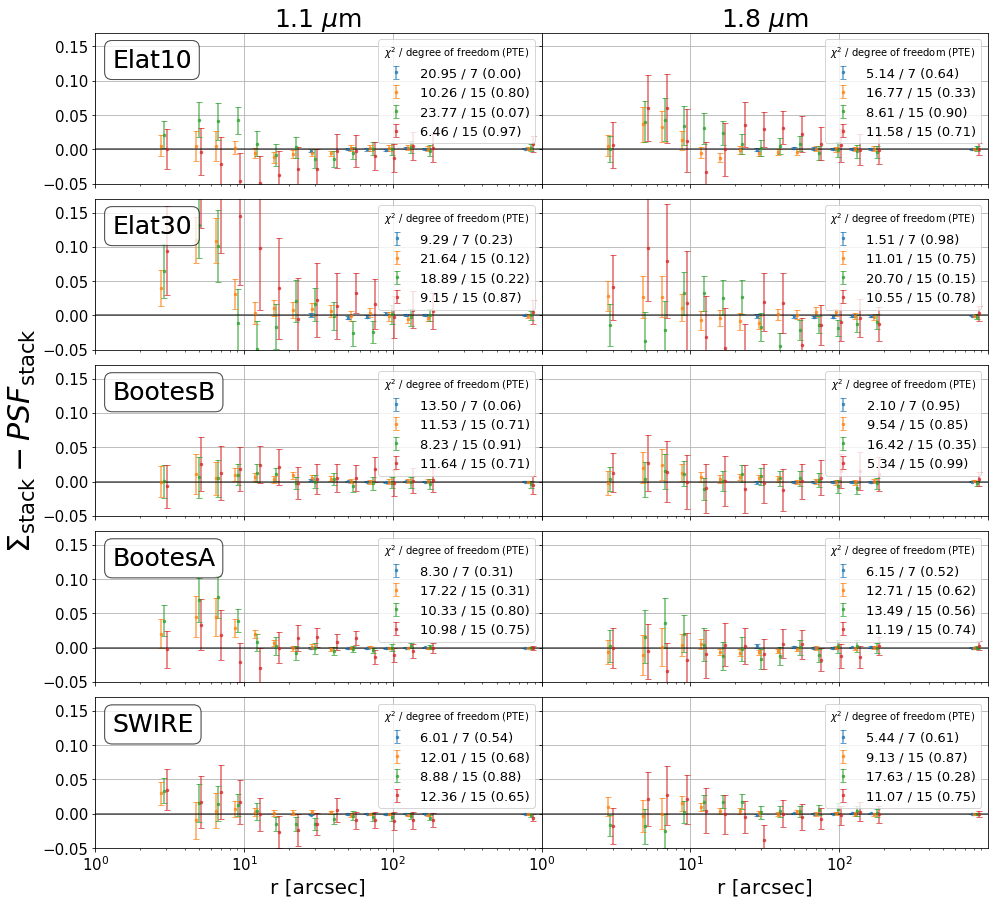

In [237]:
from psfsynth import *
import matplotlib.gridspec as gridspec

fieldnamedict = {4:'Elat10',
                 5:'Elat30',
                 6:'BootesB',
                 7:'BootesA',
                 8:'SWIRE'}

fig,ax = plt.subplots(5,2,figsize=(16,15))
plt.subplots_adjust(hspace=.1,wspace=.0)

for inst in [1,2]:
    for i,ifield in enumerate([4,5,6,7,8]):
        psfdat = run_psf_combine(inst, ifield, savedata=False)
        psf = psfdat[0]['comb']['profcb']
        psf_err = psfdat[0]['comb']['profcb_err']

        for im,(m_min, m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            Nsubbin_head = 14 if im==0 else 6
            subsub = True if im==0 else False
            stackdat = stacking(inst, ifield, m_min, m_max, 
                        load_from_file=True, BGsub=False, subsub=subsub).stackdat
            r_arr = stackdat['rsubbins']
            
            psf, psfcov, psfsub, psfcovsub = profile_cov_normalize(psfdat[0]['comb']['profcb'],
                                                                   psfdat[0]['comb']['cov'],
                                                                   psfdat[0]['comb']['hit'],
                                                                  Nsubbin_head=Nsubbin_head)

            fname = mypaths['alldat'] + 'TM'+ str(inst) +\
             '/psfdata_synth_ps_%s_%d_%d_gaia_match_svm.pkl'%(fieldnamedict[ifield],m_min, m_max)
            with open(fname, "rb") as f:
                profdat = pickle.load(f)
            prof, cov, profsub, covsub = profile_cov_normalize(profdat['profcb'],
                                                               profdat['cov'],
                                                               profdat['profhit'],
                                                              Nsubbin_head=Nsubbin_head)
            rerr = np.sqrt(np.diag(covsub+psfcovsub))
            D = (profsub - psfsub).reshape(1,-1)
            U,s,VT = np.linalg.svd(covsub+psfcovsub)
            Cinv = VT.T@np.diag(1/s)@U.T
            chi2 = (D@Cinv@D.T) * (64 - len(profsub) - 2) / (64 - 1)        
            pte = scipy.stats.distributions.chi2.sf(chi2, len(profsub))
            ax[i][inst-1].errorbar(r_arr*(0.94+im*0.04), profsub - psfsub, rerr,
                               fmt ='.', color='C'+str(im), capsize=3, markersize=5, alpha=0.7,
           label=r'%.2f / %d (%.2f)'%(chi2,len(profsub),pte))        
        ax[i][inst-1].axhline(0,c='k',lw=2,alpha=0.5)
        ax[i][inst-1].set_xscale('log')
        ax[i][inst-1].grid()
        ax[i][inst-1].legend(fontsize=13,loc=1, title=r'$\chi^2$ / degree of freedom (PTE)')
        ax[i][inst-1].set_xlim([1e0,1e3])
        ax[i][inst-1].set_ylim([-0.05,0.17])
        ax[i][inst-1].tick_params(labelsize=10)
        ax[i][0].text(1.3,0.12,'%s'%fieldnamedict[ifield],fontsize=25,
                      bbox={'boxstyle':'round','facecolor': 'white', 'alpha':0.5})
        ax[i][0].tick_params(axis='y',labelbottom=False,labelleft=True)
        ax[i][1].tick_params(axis='y',labelbottom=False,labelleft=False)
        ax[i][0].tick_params(axis='x',labelbottom=False,labelleft=False)
        ax[i][1].tick_params(axis='x',labelbottom=False,labelleft=False)
        ax[i][0].tick_params(labelsize=15)
        ax[i][1].tick_params(labelsize=15)
ax[2][0].set_ylabel(r'$\Sigma_{\rm stack}-PSF_{\rm stack}$', fontsize=30)

ax[-1][0].set_xticks([1e0,1e1,1e2])
ax[-1][0].tick_params(axis='x',labelbottom=True,labelleft=False)
ax[-1][1].set_xticks([1e0,1e1,1e2])
ax[-1][1].tick_params(axis='x',labelbottom=True,labelleft=False)
ax[-1][0].set_xlabel('r [arcsec]', fontsize=20)
ax[-1][1].set_xlabel('r [arcsec]', fontsize=20)
ax[0][0].set_title(r'1.1 $\mu$m',fontsize=25)
ax[0][1].set_title(r'1.8 $\mu$m',fontsize=25)
# fig.savefig('plots/paperfig/PSF_test_all.pdf', dpi = 150, bbox_inches='tight')

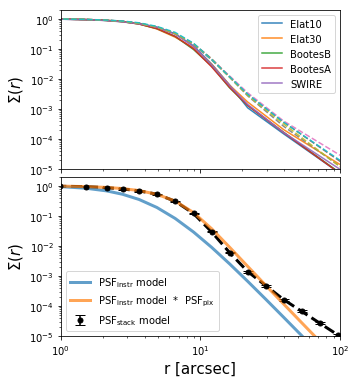

In [238]:
from psfsynth import *
import matplotlib.gridspec as gridspec

fieldnamedict = {4:'Elat10',
                 5:'Elat30',
                 6:'BootesB',
                 7:'BootesA',
                 8:'SWIRE'}

fig, ax = plt.subplots(2,1,figsize=(5,6))

inst = 1
for ifield in [4,5,6,7,8]:
    fname = mypaths['alldat'] + 'TM'+ str(inst) +\
     '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
    with open(fname,"rb") as f:
        profdat = pickle.load(f)
    ax[0].loglog(profdat['rbins'], profdat[0]['comb']['profcb'], 
                 alpha=0.9, lw=1.5, label=fieldnamedict[ifield])
    
ax[0].set_yscale('log')
ax[0].set_xlim([1e0,100])
ax[0].set_ylim([1e-5,2])
ax[0].set_ylabel(r'$\Sigma(r)$', fontsize=15)
ax[0].legend(fontsize=10)
ax[0].tick_params(labelsize=10,labelbottom=False)

inst = 2
for ifield in [4,5,6,7,8]:
    fname = mypaths['alldat'] + 'TM'+ str(inst) +\
     '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
    with open(fname,"rb") as f:
        profdat = pickle.load(f)
    ax[0].loglog(profdat['rbins'], profdat[0]['comb']['profcb'], 
                 alpha=0.9, lw=1.5, label=fieldnamedict[ifield],ls='--')

inst = 1
ifield = 8

fname = mypaths['alldat'] + 'TM'+ str(inst) +\
 '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
with open(fname,"rb") as f:
    profdat = pickle.load(f)

beta, rc, norm = PSF_model_dict[inst][ifield]
def beta_function(r, beta, rc, norm):
    return norm * (1 + (r / rc)**2)**(-3.*beta/2)
psfprofbeta = beta_function(profdat['rbins'], beta, rc, norm)
dx=1200
radmap = make_radius_map(np.zeros([2*dx+1, 2*dx+1]),dx, dx)*0.7
psf_map_beta = beta_function(radmap, beta, rc, norm)
norm = norm / np.sum(psf_map_beta)
pix_map = pix_func_substack()
psf_map_conv = fftconvolve(psf_map_beta, pix_map, 'same')
psfprofconv = radial_prof(psf_map_conv)['prof']

plot_err_log(profdat['rbins'], 
             profdat[0]['comb']['profcb'],
             profdat[0]['comb']['profcb_err'], plot_xerr=False,
             ax=ax[1], color='k',label=r'PSF$_{\rm stack}$ model')
ax[1].loglog(profdat['rbins'], profdat[0]['comb']['profcb'],'k--', lw=3)
ax[1].loglog(profdat['rbins'],psfprofbeta/psfprofbeta[0],
               lw=3,alpha=0.7, c='C0', label=r'PSF$_{\rm instr}$ model')
ax[1].loglog(profdat['rbins'],psfprofconv/psfprofconv[0],
             c='C1',lw=3,alpha=0.7, label=r'PSF$_{\rm instr}$ model  *  PSF$_{\rm pix}$')

ax[1].set_yscale('log')
ax[1].set_xlim([1e0,100])
ax[1].set_ylim([1e-5,2])
ax[1].set_xlabel('r [arcsec]', fontsize=15)
ax[1].set_ylabel(r'$\Sigma(r)$', fontsize=15)
ax[1].legend(fontsize=10)
ax[1].tick_params(labelsize=10)
plt.subplots_adjust(hspace=0.05)
# fig.savefig('plots/paperfig/PSF_RLD.pdf', dpi = 150, bbox_inches='tight')

(mag bin) inst=1, # 0
Re2 < 2.76
A1h < 6.06
A2h < 48.91
(mag bin) inst=1, # 1
Re2=2.25+0.14-0.23
A1h < 4.70
A2h < 24.22
(mag bin) inst=1, # 2
Re2=1.85+0.17-0.28
A1h < 4.18
A2h < 18.94
(mag bin) inst=1, # 3
Re2=1.85+0.25-0.21
A1h < 1.16
A2h < 6.87
(mag bin) inst=1, # None
Re2=1.98+0.17-0.17
A1h < 1.41
A1h=0.54+0.42-0.38
A2h < 7.30
(m+M bin) inst=1, # 0
Re2=2.30+0.16-0.29
A1h < 4.76
A2h < 25.58
(m+M bin) inst=1, # 1
Re2=2.27+0.37-0.32
A1h < 6.42
A2h < 19.53
(m+M bin) inst=1, # 2
Re2=1.98+0.30-0.44
A1h < 1.88
A2h < 9.08
(m+M bin) inst=1, # 3
Re2=1.98+0.18-0.30
A1h < 3.18
A2h < 16.38
(m+M bin) inst=1, # 4
Re2=1.67+0.29-0.36
A1h < 1.30
A2h < 11.30
(mag bin) inst=2, # 0
Re2 < 2.53
A1h < 5.72
A2h < 58.05
(mag bin) inst=2, # 1
Re2=1.94+0.12-0.16
A1h < 3.44
A2h < 24.76
(mag bin) inst=2, # 2
Re2=1.94+0.16-0.16
A1h < 2.96
A2h < 18.03
(mag bin) inst=2, # 3
Re2=1.63+0.21-0.14
A1h=0.77+0.23-0.23
A2h < 6.59
(mag bin) inst=2, # None
Re2=1.85+0.08-0.15
A1h=1.01+0.24-0.24
A2h < 6.86
(m+M bin) inst=2, # 

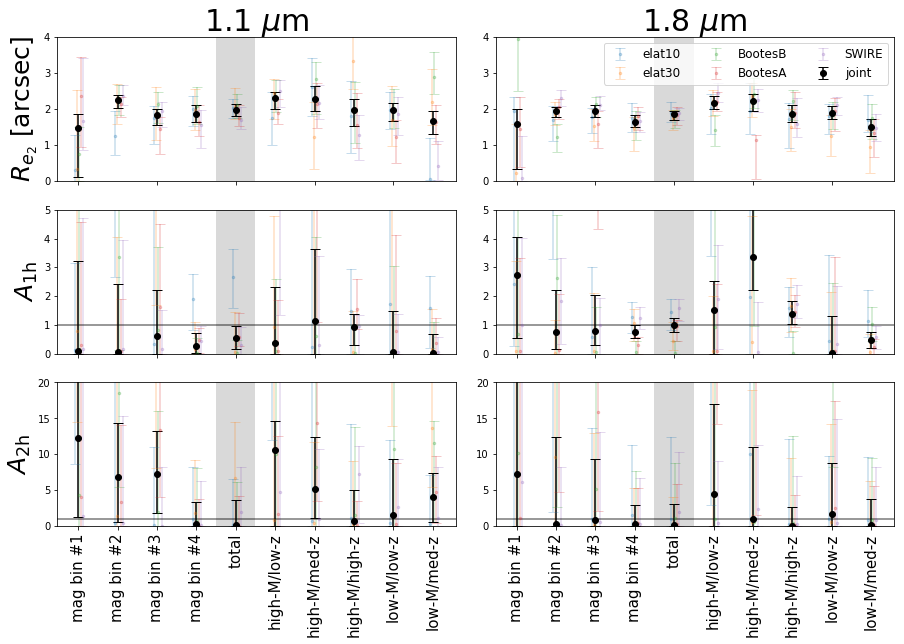

In [239]:
from run_fit import *

ci=68
fig, ax = plt.subplots(3,2, figsize = (15,9))
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
for j,inst in enumerate([1,2]):
    ax[1][j].axhline(1, c='k',lw=2, ls='-',alpha=0.4)
    ax[2][j].axhline(1, c='k',lw=2, ls='-',alpha=0.4)
    for ifield,c in zip([4,5,6,7,8,None],['C0','C1','C2','C3','C4','k']):
        xoff = 0 if ifield is None else (ifield-5.5)*0.05
        alpha = 1 if ifield is None else 0.25
        msize = 12 if ifield is None else 5
        fieldname = 'joint' if ifield is None else fieldnamedict[ifield]
        
        for i,(im,xpos) in enumerate(zip([0,1,2,3,None],[0,1,2,3,4])):
            subsub = True if im==0 else False
            label = fieldname if im is None else None
            
            if im is None:
                m_min ,m_max = 17, 20
                if ifield is None:
                    savename='mcmc_3par_joint_m17_20.npy'
                else:
                    savename='mcmc_3par_%s_m17_20.npy'%(fieldnamedict[ifield])
                fitparamdat = get_mcmc_fit_params_3par(inst, 3, ifield=ifield,savename=savename, ci=ci)
                fitparamdat95 = get_mcmc_fit_params_3par(inst, 3, ifield=ifield,savename=savename, ci=95)

            else:
                m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
                fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield, subsub=subsub, ci=ci)
                fitparamdat95 = get_mcmc_fit_params_3par(inst,im, ifield=ifield, subsub=subsub, ci=95)

            ax[0][j].errorbar([xpos+xoff], [fitparamdat['Re2']],
                              [[fitparamdat['Re2'] - fitparamdat['Re2_low']],
                               [fitparamdat['Re2_high'] - fitparamdat['Re2']]],
                          fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha,label=label)
            ax[1][j].errorbar([xpos+xoff], [fitparamdat['A1h']],
                              [[fitparamdat['A1h'] - fitparamdat['A1h_low']],
                               [fitparamdat['A1h_high'] - fitparamdat['A1h']]],
                          fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha,label=label)
            ax[2][j].errorbar([xpos+xoff], [fitparamdat['A2h']],
                              [[fitparamdat['A2h'] - fitparamdat['A2h_low']],
                               [fitparamdat['A2h_high'] - fitparamdat['A2h']]],
                          fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha,label=label)
            
            if ifield==None:
                print('(mag bin) inst=%d, #'%(inst),im)

                if fitparamdat95['Re2_low']==0:
                    print('Re2 < %.2f'%fitparamdat95['Re2_high'])
                else:
                    print('Re2=%.2f+%.2f-%.2f'%(fitparamdat['Re2'],
                                                fitparamdat['Re2_high']-fitparamdat['Re2'],
                                                fitparamdat['Re2']-fitparamdat['Re2_low']))
                if fitparamdat95['A1h_low']==0:
                    print('A1h < %.2f'%fitparamdat95['A1h_high'])
                    if im is None:
                        print('A1h=%.2f+%.2f-%.2f'%(fitparamdat['A1h'],
                                                    fitparamdat['A1h_high']-fitparamdat['A1h'],
                                                    fitparamdat['A1h']-fitparamdat['A1h_low']))

                else:
                    print('A1h=%.2f+%.2f-%.2f'%(fitparamdat['A1h'],
                                                fitparamdat['A1h_high']-fitparamdat['A1h'],
                                                fitparamdat['A1h']-fitparamdat['A1h_low']))
                if fitparamdat95['A2h_low']==0:
                    print('A2h < %.2f'%fitparamdat95['A2h_high'])
                else:
                    print('A2h=%.2f+%.2f-%.2f'%(fitparamdat['A2h'],
                                                fitparamdat['A2h_high']-fitparamdat['A2h'],
                                                fitparamdat['A2h']-fitparamdat['A2h_low']))
                    
                print('========')

        for i,(im,M_min,M_max,xpos) in enumerate(zip([1,2,3,2,3],
                                                [-23,-23,-23,-22,-22],
                                                [-22,-22,-22,-21,-21],
                                                [5,6,7,8,9])):
            m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
            if ifield is None:
                savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
            else:
                savename='mcmc_3par_%s_m%d_%d_Mabs%d_%d.npy'%(fieldnamedict[ifield],
                                                              m_min,m_max,M_min,M_max)
            fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield,savename=savename, ci=ci)
            fitparamdat95 = get_mcmc_fit_params_3par(inst,im, ifield=ifield,savename=savename, ci=95)
            
            ax[0][j].errorbar([xpos+xoff], [fitparamdat['Re2']],
                              [[fitparamdat['Re2'] - fitparamdat['Re2_low']],
                               [fitparamdat['Re2_high'] - fitparamdat['Re2']]],
                          fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha)
            ax[1][j].errorbar([xpos+xoff], [fitparamdat['A1h']],
                              [[fitparamdat['A1h'] - fitparamdat['A1h_low']],
                               [fitparamdat['A1h_high'] - fitparamdat['A1h']]],
                          fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha)
            ax[2][j].errorbar([xpos+xoff], [fitparamdat['A2h']],
                              [[fitparamdat['A2h'] - fitparamdat['A2h_low']],
                               [fitparamdat['A2h_high'] - fitparamdat['A2h']]],
                          fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha)

            if ifield==None:
                print('(m+M bin) inst=%d, #'%(inst),i)

                if fitparamdat95['Re2_low']==0:
                    print('Re2 < %.2f'%fitparamdat95['Re2_high'])
                else:
                    print('Re2=%.2f+%.2f-%.2f'%(fitparamdat['Re2'],
                                                fitparamdat['Re2_high']-fitparamdat['Re2'],
                                                fitparamdat['Re2']-fitparamdat['Re2_low']))
                if fitparamdat95['A1h_low']==0:
                    print('A1h < %.2f'%fitparamdat95['A1h_high'])
                else:
                    print('A1h=%.2f+%.2f-%.2f'%(fitparamdat['A1h'],
                                                fitparamdat['A1h_high']-fitparamdat['A1h'],
                                                fitparamdat['A1h']-fitparamdat['A1h_low']))
                if fitparamdat95['A2h_low']==0:
                    print('A2h < %.2f'%fitparamdat95['A2h_high'])
                else:
                    print('A2h=%.2f+%.2f-%.2f'%(fitparamdat['A2h'],
                                                fitparamdat['A2h_high']-fitparamdat['A2h'],
                                                fitparamdat['A2h']-fitparamdat['A2h_low']))
                    
                print('========')

    ax[0][j].axvspan(3.5, 4.5, alpha=0.15, facecolor='k')
    ax[1][j].axvspan(3.5, 4.5, alpha=0.15, facecolor='k')
    ax[2][j].axvspan(3.5, 4.5, alpha=0.15, facecolor='k')

    ax[0][j].set_ylim([0,4])
    ax[1][j].set_ylim([0,5])
    ax[2][j].set_ylim([0,2e1])
ax[0][0].set_ylabel(r"$R_{e_2}$ [arcsec]", fontsize=25)
ax[1][0].set_ylabel(r"$A_{\rm 1h}$", fontsize=25)
ax[2][0].set_ylabel(r"$A_{\rm 2h}$", fontsize=25)
ax[0][1].legend(loc=1,fontsize=12,ncol=3)
ax[0][1].set_xticklabels([])
ax[1][1].set_xticklabels([])
ax[2][1].set_xticklabels([])
ax[0][0].set_xticklabels([])
ax[1][0].set_xticklabels([])
ax[2][0].set_xticklabels([])
names = ['mag bin #1', 'mag bin #2', 'mag bin #3', 'mag bin #4', 'total',
        'high-M/low-z', 'high-M/med-z', 'high-M/high-z', 'low-M/low-z', 'low-M/med-z']
ax[-1][0].set_xticks(np.arange(10))
ax[-1][1].set_xticks(np.arange(10))
ax[-1][0].set_xticklabels(names,rotation = 90, fontsize=15)
ax[-1][1].set_xticklabels(names,rotation = 90, fontsize=15)
ax[0][0].set_title(r'1.1 $\mu$m', fontsize=30)
ax[0][1].set_title(r'1.8 $\mu$m', fontsize=30)
plt.subplots_adjust(wspace=0.1)

# plt.savefig('plots/paperfig/params_best%d.pdf'%ci, dpi = 150, bbox_inches='tight')

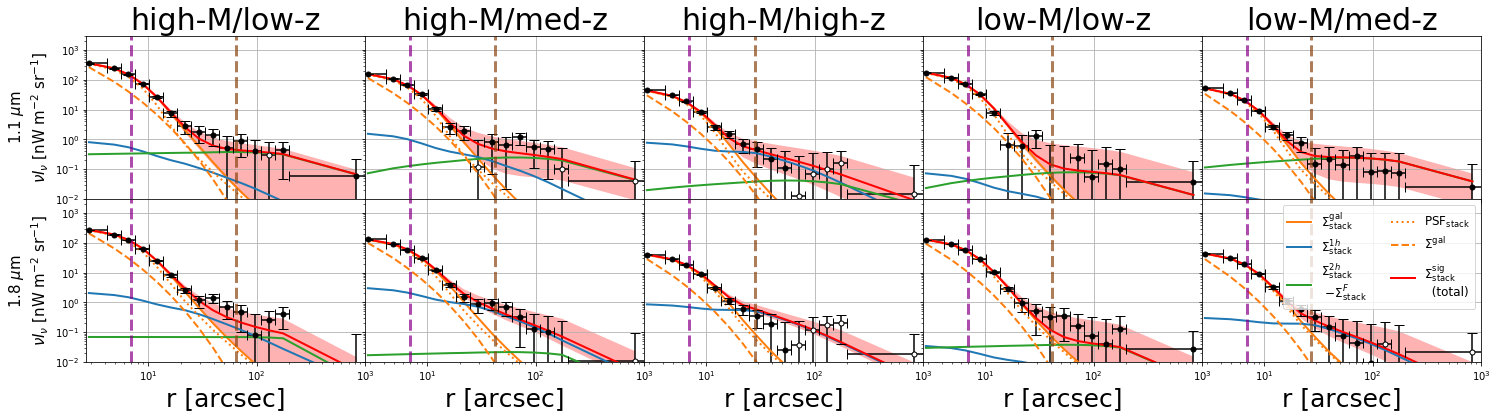

In [274]:
from run_fit import *

fig, ax = plt.subplots(2, 5, figsize = (25,6))

for inst in [1,2]:
    for i,(im,M_min,M_max,R200,name) in enumerate(zip([1,2,3,2,3],
                                            [-23,-23,-23,-22,-22],
                                            [-22,-22,-22,-21,-21],
                                            [64,42,28,41,27],
        ['high-M/low-z','high-M/med-z','high-M/high-z','low-M/low-z','low-M/med-z'])):
        m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=None,savename=savename)
        
        Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h']
        Re2_low, A1h_low, A2h_low \
        = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
        Re2_high, A1h_high, A2h_high \
        = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

        profd_arr, profd_err = 0, 0
        profgalint_arr = 0
        profgal_arr, profgal_arr_low, profgal_arr_high = 0, 0, 0
        profpsf_arr = 0
        profex_arr, profex_arr_low, profex_arr_high = 0, 0, 0
        prof1h_arr, prof1h_arr_low, prof1h_arr_high = 0, 0, 0
        prof2h_arr, prof2h_arr_low, prof2h_arr_high = 0, 0, 0
        for ifield in [4,5,6,7,8]:
            print(inst, i, ifield)
            param_fit = fit_stacking_mcmc(inst, ifield, im, m_min, m_max,
                                          Mabs_min=M_min, Mabs_max=M_max)
            
            profd_arri = param_fit.profcb_sub
            profd_erri = np.sqrt(np.diag(param_fit.covsub))
            profd_arr += profd_arri / profd_erri**2
            profd_err += 1 / profd_erri**2

            modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h, fast=False)
            profgal_arri = modelprof['profgal_sub']
            profex_arri = modelprof['profex_sub']
            prof1h_arri = modelprof['prof1h_sub']
            prof2h_arri = modelprof['prof2h_sub']
            profgal_arr += profgal_arri
            profex_arr += profex_arri
            profpsf_arr += profgal_arri - profex_arri
            prof1h_arr += prof1h_arri
            prof2h_arr += prof2h_arri

            profint = gal_profile_model().Wang19_profile(param_fit.rbins,
                                   param_fit.im, Re2=fitparamdat['Re2'])['I_arr']
            norm = np.sum(modelprof['profgal']*param_fit.rbins) / np.sum(profint*param_fit.rbins)
            profintsub = gal_profile_model().Wang19_profile(param_fit.rsubbins,
                                    param_fit.im, Re2=fitparamdat['Re2'])['I_arr']* norm
            
            profgalint_arr += profintsub            
            
            modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h_low,
                                                       A2h=A2h_low, fast=False)
            profgal_arri = modelprof['profgal_sub']
            profex_arri = modelprof['profex_sub']
            prof1h_arri = modelprof['prof1h_sub']
            prof2h_arri = modelprof['prof2h_sub']
            profgal_arr_low += profgal_arri
            profex_arr_low += profex_arri
            prof1h_arr_low += prof1h_arri
            prof2h_arr_low += prof2h_arri

            modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h_high,
                                                       A2h=A2h_high, fast=False)
            profgal_arri = modelprof['profgal_sub']
            profex_arri = modelprof['profex_sub']
            prof1h_arri = modelprof['prof1h_sub']
            prof2h_arri = modelprof['prof2h_sub']
            profgal_arr_high += profgal_arri
            profex_arr_high += profex_arri
            prof1h_arr_high += prof1h_arri
            prof2h_arr_high += prof2h_arri

        profgal_arr /= 5
        profgal_arr_low /= 5
        profgal_arr_high /= 5
        profpsf_arr /= 5
        profgalint_arr /= 5
        profex_arr /= 5
        profex_arr_low /= 5
        profex_arr_high /= 5
        prof1h_arr /= 5
        prof1h_arr_low /= 5
        prof1h_arr_high /= 5
        prof2h_arr /= 5
        prof2h_arr_low /= 5
        prof2h_arr_high /= 5
        profd_arr /= profd_err
        profd_err = np.sqrt(1 / profd_err)

        r_arr = param_fit.rsubbins
        rbinedges = param_fit.rsubbinedges

        ax[inst-1][i].loglog(r_arr, profgal_arr,'C1', lw=2, 
                             label=r'$\Sigma^{\rm gal}_{\rm stack}$')
        ax[inst-1][i].loglog(r_arr, prof1h_arr,'C0', lw=2, 
                             label=r'$\Sigma^{1h}_{\rm stack}$')
        ax[inst-1][i].loglog(r_arr, prof2h_arr,'C2', lw=2, 
                        label=r'$\Sigma^{2h}_{\rm stack}$'+'\n'+r' $-\Sigma^{F}_{\rm stack}$')
        ax[inst-1][i].loglog(r_arr, profpsf_arr,'C1:', lw=2, 
                             label=r'PSF$_{\rm stack}$')
        ax[inst-1][i].loglog(r_arr, profgalint_arr,'C1--', lw=2, 
                             label=r'$\Sigma^{\rm gal}$')
        ax[inst-1][i].loglog(r_arr, profgal_arr + prof1h_arr + prof2h_arr,
                             'r-', lw=2, label = r'$\Sigma^{\rm sig}_{\rm stack}$' + '\n  (total)')
        ax[inst-1][i].fill_between(r_arr, profgal_arr_low + prof1h_arr_low + prof2h_arr_low,
                           profgal_arr_high + prof1h_arr_high + prof2h_arr_high,
                                   facecolor='r', alpha=0.3)
        plot_err_log(r_arr, 
                     profd_arr,
                     profd_err,
                     xedges = rbinedges,
                     ax=ax[inst-1][i], color='k')

        ax[inst-1][i].set_ylim([1e-2,3e3])
        ax[inst-1][i].set_xlim([2.7,1e3])
        ax[inst-1][i].grid()    
        ax[1][i].set_xlabel('r [arcsec]', fontsize=25)
        ax[0][i].set_title(name, fontsize=30)
        ax[inst-1][i].axvline(R200, c='saddlebrown', lw=3, alpha=0.7,ls='--')
        ax[inst-1][i].axvline(7, c='darkmagenta',lw=3, alpha=0.7,ls='--')

        ax[0][i].tick_params(labelsize=10,labelbottom=False)
        if i!=0:
            ax[inst-1][i].tick_params(labelsize=10,labelleft=False)

ax[0][0].set_ylabel(r'1.1 $\mu$m' + '\n' + r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
ax[1][0].set_ylabel(r'1.8 $\mu$m' + '\n' + r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
ax[1][-1].legend(fontsize=12, ncol=2)

plt.subplots_adjust(hspace=0, wspace=0)

plt.savefig('plots/paperfig/gal_profile_fit.pdf', dpi = 150, bbox_inches='tight')
clear_output()

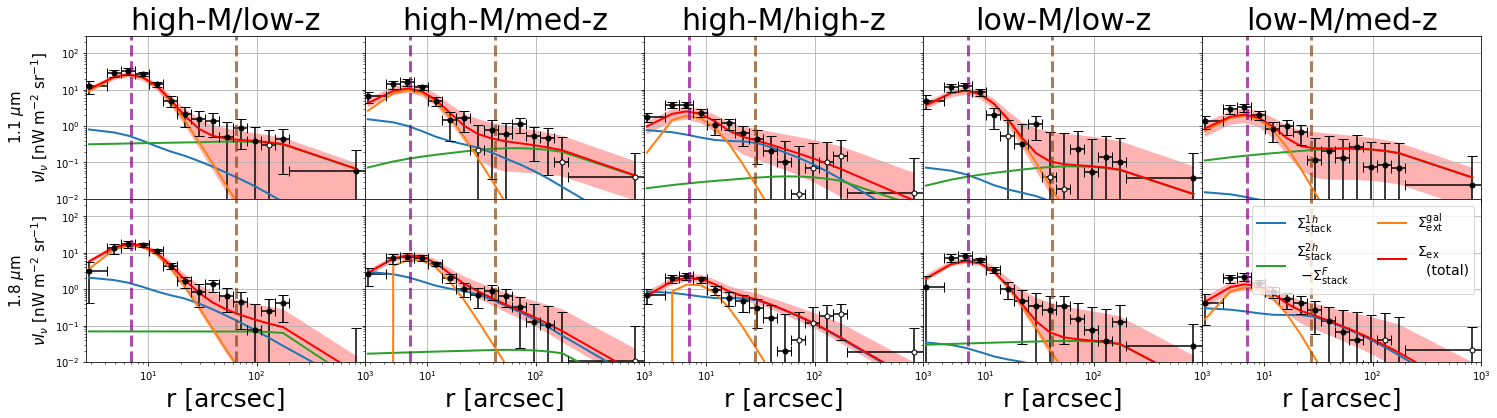

In [275]:
from run_fit import *

fig, ax = plt.subplots(2, 5, figsize = (25,6))

for inst in [1,2]:
    for i,(im,M_min,M_max,R200,name) in enumerate(zip([1,2,3,2,3],
                                            [-23,-23,-23,-22,-22],
                                            [-22,-22,-22,-21,-21],
                                            [64,42,28,41,27],
        ['high-M/low-z','high-M/med-z','high-M/high-z','low-M/low-z','low-M/med-z'])):
        m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=None,savename=savename)
        
        Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h']
        Re2_low, A1h_low, A2h_low \
        = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
        Re2_high, A1h_high, A2h_high \
        = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

        profd_arr, profd_err = 0, 0
        profex_arr, profex_arr_low, profex_arr_high = 0, 0, 0
        prof1h_arr, prof1h_arr_low, prof1h_arr_high = 0, 0, 0
        prof2h_arr, prof2h_arr_low, prof2h_arr_high = 0, 0, 0
        for ifield in [4,5,6,7,8]:
            print(inst, i, ifield)
            param_fit = fit_stacking_mcmc(inst, ifield, im, m_min, m_max,
                                          Mabs_min=M_min, Mabs_max=M_max)

            profd_arri = param_fit.profex_sub
            profd_erri = np.sqrt(np.diag(param_fit.covsub))
            profd_arr += profd_arri / profd_erri**2
            profd_err += 1 / profd_erri**2

            modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h, fast=False)
            profex_arri = modelprof['profex_sub']
            prof1h_arri = modelprof['prof1h_sub']
            prof2h_arri = modelprof['prof2h_sub']
            profex_arr += profex_arri
            prof1h_arr += prof1h_arri
            prof2h_arr += prof2h_arri

            modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h_low,
                                                       A2h=A2h_low, fast=False)
            profex_arri = modelprof['profex_sub']
            prof1h_arri = modelprof['prof1h_sub']
            prof2h_arri = modelprof['prof2h_sub']
            profex_arr_low += profex_arri
            prof1h_arr_low += prof1h_arri
            prof2h_arr_low += prof2h_arri

            modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h_high,
                                                       A2h=A2h_high, fast=False)
            profex_arri = modelprof['profex_sub']
            prof1h_arri = modelprof['prof1h_sub']
            prof2h_arri = modelprof['prof2h_sub']
            profex_arr_high += profex_arri
            prof1h_arr_high += prof1h_arri
            prof2h_arr_high += prof2h_arri

        profex_arr /= 5
        profex_arr_low /= 5
        profex_arr_high /= 5
        prof1h_arr /= 5
        prof1h_arr_low /= 5
        prof1h_arr_high /= 5
        prof2h_arr /= 5
        prof2h_arr_low /= 5
        prof2h_arr_high /= 5
        profd_arr /= profd_err
        profd_err = np.sqrt(1 / profd_err)

        r_arr = param_fit.rsubbins
        rbinedges = param_fit.rsubbinedges

        ax[inst-1][i].loglog(r_arr, prof1h_arr,'C0', lw=2, 
                             label=r'$\Sigma^{1h}_{\rm stack}$')
        ax[inst-1][i].loglog(r_arr, prof2h_arr,'C2', lw=2, 
                        label=r'$\Sigma^{2h}_{\rm stack}$'+'\n'+r' $-\Sigma^{F}_{\rm stack}$')        
        ax[inst-1][i].loglog(r_arr, profex_arr,'C1', lw=2, label=r'$\Sigma^{\rm gal}_{\rm ext}$')
        ax[inst-1][i].loglog(r_arr, profex_arr + prof1h_arr + prof2h_arr,'r-', lw=2, 
                             label = r'$\Sigma_{\rm ex}$'+ '\n  (total)')
        ax[inst-1][i].fill_between(r_arr, profex_arr_low + prof1h_arr_low + prof2h_arr_low,
                           profex_arr_high + prof1h_arr_high + prof2h_arr_high, 
                                   facecolor='r', alpha=0.3)
        plot_err_log(r_arr, 
                     profd_arr,
                     profd_err,
                     xedges = rbinedges,
                     ax=ax[inst-1][i], color='k')

        ax[inst-1][i].set_ylim([1e-2,3e2])
        ax[inst-1][i].set_xlim([2.7,1e3])
        ax[inst-1][i].grid()    
        ax[1][i].set_xlabel('r [arcsec]', fontsize=25)
        ax[0][i].set_title(name, fontsize=30)
        ax[inst-1][i].axvline(R200, c='saddlebrown', lw=3, alpha=0.7,ls='--')
        ax[inst-1][i].axvline(7, c='darkmagenta',lw=3, alpha=0.7,ls='--')

        ax[0][i].tick_params(labelsize=10,labelbottom=False)
        if i!=0:
            ax[inst-1][i].tick_params(labelsize=10,labelleft=False)

ax[0][0].set_ylabel(r'1.1 $\mu$m' + '\n' + r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
ax[1][0].set_ylabel(r'1.8 $\mu$m' + '\n' + r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
ax[1][-1].legend(fontsize=14, ncol=2)

plt.subplots_adjust(hspace=0, wspace=0)

plt.savefig('plots/paperfig/excess_profile_fit.pdf', dpi = 150, bbox_inches='tight')
clear_output()

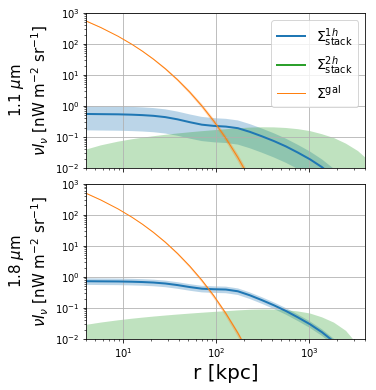

In [242]:
from run_fit import *

im = 3
name = 'total'
savename='mcmc_3par_joint_m17_20.npy'

fig, ax = plt.subplots(2,1,figsize=(5,6))
for inst in [1,2]:
    fitparamdat = get_mcmc_fit_params_3par(inst, 3, ifield=None,savename=savename)

    Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h']
    Re2_low, A1h_low, A2h_low \
    = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
    Re2_high, A1h_high, A2h_high \
    = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

    profgalint_arr, profgalint_arr_low, profgalint_arr_high = 0,0,0
    profgal_arr, profgal_arr_low, profgal_arr_high = 0, 0, 0
    profex_arr, profex_arr_low, profex_arr_high = 0, 0, 0
    prof1h_arr, prof1h_arr_low, prof1h_arr_high = 0, 0, 0
    prof2h_arr, prof2h_arr_low, prof2h_arr_high = 0, 0, 0
    for ifield in [4,5,6,7,8]:
        print(inst, i, ifield)
        param_fit = fit_stacking_mcmc(inst, ifield, 'all')

        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h, fast=False)
        profgal_arri = modelprof['profgal']
        profex_arri = modelprof['profex']
        prof1h_arri = modelprof['prof1h']
        prof2h_arri = modelprof['prof2h']
        profgal_arr += profgal_arri
        profex_arr += profex_arri
        prof1h_arr += prof1h_arri
        prof2h_arr += prof2h_arri

        profint = gal_profile_model().Wang19_profile(param_fit.rbins,
                               param_fit.im, Re2=Re2)['I_arr']
        norm = np.sum(modelprof['profgal']*param_fit.rbins) / np.sum(profint*param_fit.rbins)
        profgalint_arr += profint*norm            

        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h_low,
                                                   A2h=A2h_low, fast=False)
        profgal_arri = modelprof['profgal']
        profex_arri = modelprof['profex']
        prof1h_arri = modelprof['prof1h']
        prof2h_arri = modelprof['prof2h']
        profgal_arr_low += profgal_arri
        profex_arr_low += profex_arri
        prof1h_arr_low += prof1h_arri
        prof2h_arr_low += prof2h_arri

        profint = gal_profile_model().Wang19_profile(param_fit.rbins,
                               param_fit.im, Re2=Re2_low)['I_arr']
        norm = np.sum(modelprof['profgal']*param_fit.rbins) / np.sum(profint*param_fit.rbins)
        profgalint_arr_low += profint * norm           

        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h_high,
                                                   A2h=A2h_high, fast=False)
        profgal_arri = modelprof['profgal']
        profex_arri = modelprof['profex']
        prof1h_arri = modelprof['prof1h']
        prof2h_arri = modelprof['prof2h']
        profgal_arr_high += profgal_arri
        profex_arr_high += profex_arri
        prof1h_arr_high += prof1h_arri
        prof2h_arr_high += prof2h_arri

        profint = gal_profile_model().Wang19_profile(param_fit.rbins,
                               param_fit.im, Re2=Re2_high)['I_arr']
        norm = np.sum(modelprof['profgal']*param_fit.rbins) / np.sum(profint*param_fit.rbins)
        profgalint_arr_high += profint*norm         

    profgal_arr /= 5
    profgal_arr_low /= 5
    profgal_arr_high /= 5
    profpsf_arr /= 5
    profgalint_arr /= 5
    profgalint_arr_low /= 5
    profgalint_arr_high /= 5
    profex_arr /= 5
    profex_arr_low /= 5
    profex_arr_high /= 5
    prof1h_arr /= 5
    prof1h_arr_low /= 5
    prof1h_arr_high /= 5
    prof2h_arr /= 5
    prof2h_arr_low /= 5
    prof2h_arr_high /= 5

    r_arr = param_fit.rbins * 232/40
    ax[inst-1].loglog(r_arr, prof1h_arr,'C0', lw=2, label=r'$\Sigma^{1h}_{\rm stack}$')
    ax[inst-1].fill_between(r_arr, prof1h_arr_low, prof1h_arr_high, facecolor='C0', alpha=0.3)
    ax[inst-1].loglog(r_arr, prof2h_arr,'C2', lw=2, label=r'$\Sigma^{2h}_{\rm stack}$')
    ax[inst-1].fill_between(r_arr, prof2h_arr_low, prof2h_arr_high, facecolor='C2', alpha=0.3)
    ax[inst-1].loglog(r_arr, profgalint_arr,'C1', lw=1, label=r'$\Sigma^{\rm gal}$')
    ax[inst-1].fill_between(r_arr, profgalint_arr_low, profgalint_arr_high,
                            facecolor='C1', alpha=0.3)

    ax[inst-1].set_ylim([1e-2,1e3])
    ax[inst-1].set_xlim([4,4e3])
    ax[inst-1].grid()    
    ax[1].set_xlabel('r [kpc]', fontsize=20)

    ax[0].tick_params(labelsize=10,labelbottom=False)
    ax[0].set_ylabel(r'1.1 $\mu$m' + '\n' + r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
    ax[1].set_ylabel(r'1.8 $\mu$m' + '\n' + r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
    ax[0].legend(fontsize=14)
plt.subplots_adjust(hspace=0.1)
# plt.savefig('plots/paperfig/gal_profint_fit.pdf', dpi = 150, bbox_inches='tight')
clear_output()

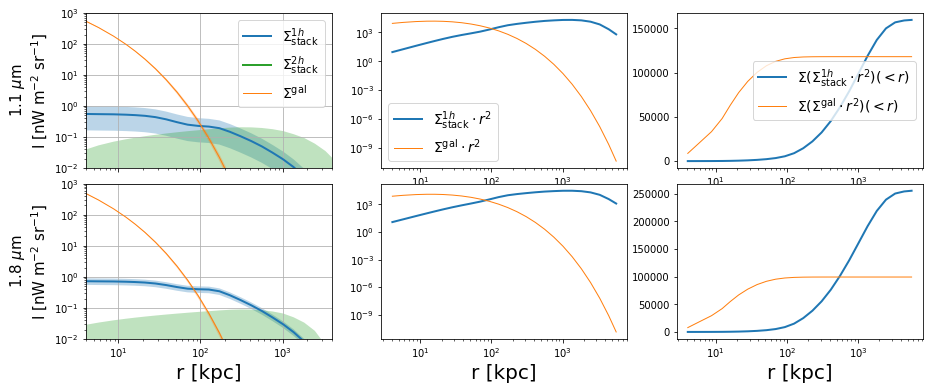

In [243]:
from run_fit import *

im = 3
name = 'total'
savename='mcmc_3par_joint_m17_20.npy'

fig, ax = plt.subplots(2,3,figsize=(15,6))
for inst in [1,2]:
    fitparamdat = get_mcmc_fit_params_3par(inst, 3, ifield=None,savename=savename)

    Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h']
    Re2_low, A1h_low, A2h_low \
    = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
    Re2_high, A1h_high, A2h_high \
    = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

    profgalint_arr, profgalint_arr_low, profgalint_arr_high = 0,0,0
    profgal_arr, profgal_arr_low, profgal_arr_high = 0, 0, 0
    profex_arr, profex_arr_low, profex_arr_high = 0, 0, 0
    prof1h_arr, prof1h_arr_low, prof1h_arr_high = 0, 0, 0
    prof2h_arr, prof2h_arr_low, prof2h_arr_high = 0, 0, 0
    for ifield in [4,5,6,7,8]:
        print(inst, i, ifield)
        param_fit = fit_stacking_mcmc(inst, ifield, 'all')

        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h, fast=False)
        profgal_arri = modelprof['profgal']
        profex_arri = modelprof['profex']
        prof1h_arri = modelprof['prof1h']
        prof2h_arri = modelprof['prof2h']
        profgal_arr += profgal_arri
        profex_arr += profex_arri
        prof1h_arr += prof1h_arri
        prof2h_arr += prof2h_arri

        profint = gal_profile_model().Wang19_profile(param_fit.rbins,
                               param_fit.im, Re2=Re2)['I_arr']
        norm = np.sum(modelprof['profgal']*param_fit.rbins) / np.sum(profint*param_fit.rbins)
        profgalint_arr += profint*norm            

        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h_low,
                                                   A2h=A2h_low, fast=False)
        profgal_arri = modelprof['profgal']
        profex_arri = modelprof['profex']
        prof1h_arri = modelprof['prof1h']
        prof2h_arri = modelprof['prof2h']
        profgal_arr_low += profgal_arri
        profex_arr_low += profex_arri
        prof1h_arr_low += prof1h_arri
        prof2h_arr_low += prof2h_arri

        profint = gal_profile_model().Wang19_profile(param_fit.rbins,
                               param_fit.im, Re2=Re2_low)['I_arr']
        norm = np.sum(modelprof['profgal']*param_fit.rbins) / np.sum(profint*param_fit.rbins)
        profgalint_arr_low += profint * norm           

        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h_high,
                                                   A2h=A2h_high, fast=False)
        profgal_arri = modelprof['profgal']
        profex_arri = modelprof['profex']
        prof1h_arri = modelprof['prof1h']
        prof2h_arri = modelprof['prof2h']
        profgal_arr_high += profgal_arri
        profex_arr_high += profex_arri
        prof1h_arr_high += prof1h_arri
        prof2h_arr_high += prof2h_arri

        profint = gal_profile_model().Wang19_profile(param_fit.rbins,
                               param_fit.im, Re2=Re2_high)['I_arr']
        norm = np.sum(modelprof['profgal']*param_fit.rbins) / np.sum(profint*param_fit.rbins)
        profgalint_arr_high += profint*norm         

    profgal_arr /= 5
    profgal_arr_low /= 5
    profgal_arr_high /= 5
    profpsf_arr /= 5
    profgalint_arr /= 5
    profgalint_arr_low /= 5
    profgalint_arr_high /= 5
    profex_arr /= 5
    profex_arr_low /= 5
    profex_arr_high /= 5
    prof1h_arr /= 5
    prof1h_arr_low /= 5
    prof1h_arr_high /= 5
    prof2h_arr /= 5
    prof2h_arr_low /= 5
    prof2h_arr_high /= 5

    r_arr = param_fit.rbins * 232/40
    ax[inst-1][0].loglog(r_arr, prof1h_arr,'C0', lw=2, label=r'$\Sigma^{1h}_{\rm stack}$')
    ax[inst-1][0].fill_between(r_arr, prof1h_arr_low, prof1h_arr_high, facecolor='C0', alpha=0.3)
    ax[inst-1][0].loglog(r_arr, prof2h_arr,'C2', lw=2, label=r'$\Sigma^{2h}_{\rm stack}$')
    ax[inst-1][0].fill_between(r_arr, prof2h_arr_low, prof2h_arr_high, facecolor='C2', alpha=0.3)
    ax[inst-1][0].loglog(r_arr, profgalint_arr,'C1', lw=1, label=r'$\Sigma^{\rm gal}$')
    ax[inst-1][0].fill_between(r_arr, profgalint_arr_low, profgalint_arr_high,
                            facecolor='C1', alpha=0.3)
    ax[inst-1][0].set_ylim([1e-2,1e3])
    ax[inst-1][0].set_xlim([4,4e3])
    ax[inst-1][0].grid() 
    
    ax[inst-1][1].loglog(r_arr, prof1h_arr*r_arr**2,'C0', lw=2, 
                         label=r'$\Sigma^{1h}_{\rm stack}\cdot r^2$')
    ax[inst-1][1].loglog(r_arr, profgalint_arr*r_arr**2,'C1', lw=1, 
                         label=r'$\Sigma^{\rm gal}\cdot r^2$')
    ax[inst-1][2].semilogx(r_arr, np.cumsum(prof1h_arr*r_arr**2),'C0', lw=2, 
                         label=r'$\Sigma(\Sigma^{1h}_{\rm stack}\cdot r^2) (<r)$')
    ax[inst-1][2].semilogx(r_arr, np.cumsum(profgalint_arr*r_arr**2),'C1', lw=1, 
                         label=r'$\Sigma(\Sigma^{\rm gal}\cdot r^2) (<r)$')
    
ax[1][0].set_xlabel('r [kpc]', fontsize=20)
ax[1][1].set_xlabel('r [kpc]', fontsize=20)
ax[1][2].set_xlabel('r [kpc]', fontsize=20)

ax[0][0].tick_params(labelsize=10,labelbottom=False)
ax[0][0].set_ylabel(r'1.1 $\mu$m' + '\n' + r'I [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
ax[1][0].set_ylabel(r'1.8 $\mu$m' + '\n' + r'I [nW m$^{-2}$ sr$^{-1}$]', fontsize=15)
ax[0][0].legend(fontsize=14)
ax[0][1].legend(fontsize=14)
ax[0][2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.1)
clear_output()

***
# Data interpretations

In [ ]:
from micecat import *
from run_fit import *
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

srcinfo = {}
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
dfmc = get_micecat_df(0, add_Rvir=True)

mrrdata = loadmat(mypaths['ciberdir']+'doc/20170617_Stacking/maps/mrrcats/mrr_cat_SWIRE.mat')
dfmrr = pd.DataFrame()
column_names = ['ra','dec','zm','zme','mst','z','av','ze','npts','mass'] # data['cat'][0].dtype
for i,name in enumerate(column_names):
    dfmrr[name] = mrrdata['cat'][0,0][i].flatten()
dfmrr = dfmrr.loc[dfmrr['mst']>0]
dfmrr = dfmrr.loc[dfmrr['mass']!=0]

for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    srcinfo[i] = {'im':im, 'm_min':m_min, 'm_max':m_max, 'M_min':M_min, 'M_max':M_max}
    
    dfi = dfmc.loc[(dfmc['I']>=m_min) & (dfmc['I']<m_max) \
                   & (dfmc['M_I']>=M_min) & (dfmc['M_I']<M_max)]
    srcinfo[i]['R200_mc'] = 1e3 * dfi['Rv_Mpc'].values # [kpc]
    srcinfo[i]['logMh'] = dfi['lmhalo'].values
    srcinfo[i]['z'] = np.array([])
    for ifield in [4,5,6,7,8]:
        print(i,ifield)
        mask_inst1, mask_inst2 = load_processed_images(data_maps,
                              return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
        field = fieldnamedict[ifield]
        srcdat = ps_src_select(1, ifield, m_min, m_max, [mask_inst1, mask_inst2],
                               Mabs_min=M_min, Mabs_max=M_max, sample_type='all')
        srcinfo[i]['z'] = np.concatenate((srcinfo[i]['z'],np.array(srcdat['zg_arr'])))        
    DA_Mpc = cosmo.angular_diameter_distance(srcinfo[i]['z']).value
    srcinfo[i]['kpc_per_arcsec'] = DA_Mpc * (u.Mpc/u.rad).to(u.kpc/u.arcsec)
    
    # get Mstr from MRR cat
    srcdat = ps_src_select(1, 8, m_min, m_max, 
        [mask_inst1, mask_inst2], sample_type='all')
    dfps = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[8] + '.csv')
    dfps = dfps.iloc[srcdat['idxg_arr']]
    dfps, dfmrr1 = match_catalog_by_coord(dfps,dfmrr)
    dfps['mass'] = dfmrr1['mass'].values
    DM = 5 * np.log10((cosmo.luminosity_distance(dfps['Photz']) / (10 * u.pc)).decompose()).value
    Ms = dfps['I_comb'] - DM + (2.5 * np.log10(1+dfps['Photz']))
    dfps['Mabs'] = Ms
    sp = np.where((dfps['Mabs']>=M_min) & (dfps['Mabs']<M_max))[0]
    logMstr = dfps['mass'].iloc[sp].values
    srcinfo[i]['logMstr'] = logMstr
    
    for inst in [1,2]:
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat,flatsamps = get_mcmc_fit_params_3par(inst,im, ifield=ifield,savename=savename,
                                              return_samples=True)
        Re2_samps = (flatsamps[:,0] * fitparamdat['R200'])[::5].reshape(-1,1)
        kpc_per_arcsec = srcinfo[i]['kpc_per_arcsec'].reshape(1,-1)
        Re2_kpc_samps = (Re2_samps@kpc_per_arcsec).flatten()
        srcinfo[i]['Re2_'+str(inst)] = np.median(Re2_kpc_samps)
        srcinfo[i]['Re2_low_'+str(inst)] = np.percentile(Re2_kpc_samps,16)
        srcinfo[i]['Re2_high_'+str(inst)] = np.percentile(Re2_kpc_samps,84)
        srcinfo[i]['Re2_'+str(inst)+'_arcsec'] = fitparamdat['Re2']
        srcinfo[i]['Re2_low_'+str(inst)+'_arcsec'] = fitparamdat['Re2_low']
        srcinfo[i]['Re2_high_'+str(inst)+'_arcsec'] = fitparamdat['Re2_high']
        srcinfo[i]['A1h_'+str(inst)] = fitparamdat['A1h']
        srcinfo[i]['A1h_low_'+str(inst)] = fitparamdat['A1h_low']
        srcinfo[i]['A1h_high_'+str(inst)] = fitparamdat['A1h_high']
        srcinfo[i]['A2h_'+str(inst)] = fitparamdat['A2h']
        srcinfo[i]['A2h_low_'+str(inst)] = fitparamdat['A2h_low']
        srcinfo[i]['A2h_high_'+str(inst)] = fitparamdat['A2h_high']
        
        rbins, mc_avg, mc_std, _ = get_micecat_sim_1h(inst, im, Mhcut=1e14, R200cut=0, zcut=0.15)
        srcinfo[i]['MC1h_rbins'+str(inst)] = rbins
        srcinfo[i]['MC1h_avg'+str(inst)] = mc_avg
        srcinfo[i]['MC1h_std'+str(inst)] = mc_std
        rbins, _, mc_avg_fit, _, _, _ = micecat_profile_fit(inst,im, return_full=True)
        srcinfo[i]['MC2h_rbins'+str(inst)] = rbins
        srcinfo[i]['MC2h_avg'+str(inst)] = mc_avg_fit

# get R50
# for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
#     m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
#     srcinfo[i]['dfpetro'] = pd.DataFrame()
#     for ifield in [4,5,6,7,8]:
#         print('get petro mag bin #%d, ifield%d'%(i, ifield))
#         dfpetro = pd.read_csv('/Volumes/Drive/ciber/data/SDSScats/%s_petro.csv'\
#                       %fieldnamedict[ifield],skiprows=1, low_memory=False)
#         mask_inst1, mask_inst2 = load_processed_images(data_maps,
#                               return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
#         field = fieldnamedict[ifield]
#         srcdat = ps_src_select(1, ifield, m_min, m_max, 
#             [mask_inst1, mask_inst2], Mabs_min=M_min, Mabs_max=M_max, sample_type='all')
#         dfpsi = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[ifield] + '.csv')
#         dfpsi = dfpsi.iloc[srcdat['idxg_arr']]
#         dfpsi, dfpetroi = match_catalog_by_coord(dfpsi,dfpetro)
#         dfpsi=dfpsi.reset_index(drop=True)
#         dfpetroi=dfpetroi.reset_index(drop=True)
#         dfpsi = dfpsi.join(dfpetroi,lsuffix='_ps', rsuffix='_petro')
#         srcinfo[i]['dfpetro'] = pd.concat([srcinfo[i]['dfpetro'], 
#                 dfpsi[['petroR50_u','petroR50_g','petroR50_r','petroR50_i','petroR50_z']]])

clear_output()

f_Re1 = 4.37e-03, f_Re2 = 9.96e-01, f_Re1(10-100) = 2.30e-10, f_Re2(10-100) = 4.39e-01
f_Re1 = 1.05e-03, f_Re2 = 9.99e-01, f_Re1(10-100) = 1.59e-13, f_Re2(10-100) = 5.32e-01
f_Re1 = 4.24e-04, f_Re2 = 1.00e+00, f_Re1(10-100) = 1.01e-16, f_Re2(10-100) = 5.53e-01
f_Re1 = 2.26e-03, f_Re2 = 9.98e-01, f_Re1(10-100) = 3.44e-13, f_Re2(10-100) = 4.12e-01
f_Re1 = 8.67e-04, f_Re2 = 9.99e-01, f_Re1(10-100) = 2.07e-16, f_Re2(10-100) = 4.45e-01
HSC:
f_Re1 = 1.25e-01, f_Re2 = 8.75e-01, f_Re1(10-100) = 1.18e-04, f_Re2(10-100) = 2.03e-01


(1e-10, 1.0)

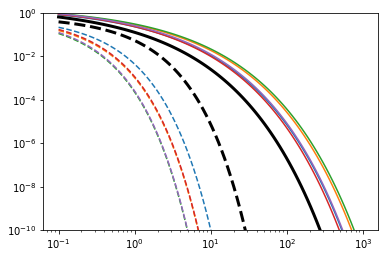

In [245]:
r_arr = np.logspace(-1,3,100)
sp = np.where((r_arr > 10) & (r_arr<100))[0]
inst = 1
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']
    Re2 = srcinfo[i]['Re2_'+str(inst)] 
    galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
    p = galprofdat['I_arr']
    p_Re1 = galprofdat['I1_arr']
    p_Re2 = galprofdat['I2_arr']
    f_Re1 = np.sum(p_Re1*r_arr**2)/np.sum(p*r_arr**2)
    f_Re2 = np.sum(p_Re2*r_arr**2)/np.sum(p*r_arr**2)
    f_Re1_10_100 = np.sum(p_Re1[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
    f_Re2_10_100 = np.sum(p_Re2[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)

    print('f_Re1 = %.2e, f_Re2 = %.2e, f_Re1(10-100) = %.2e, f_Re2(10-100) = %.2e'\
          %(f_Re1, f_Re2, f_Re1_10_100, f_Re2_10_100))
    
    plt.loglog(r_arr, p_Re1/p[0], c='C'+str(i), ls='--')
    plt.loglog(r_arr, p_Re2/p[0], c='C'+str(i), ls='-')
    
    
galprofdat = gal_profile_model().Wang19_profile(r_arr, im, R200=200)
p = galprofdat['I_arr']
p_Re1 = galprofdat['I1_arr']
p_Re2 = galprofdat['I2_arr']
f_Re1 = np.sum(p_Re1*r_arr**2)/np.sum(p*r_arr**2)
f_Re2 = np.sum(p_Re2*r_arr**2)/np.sum(p*r_arr**2)
f_Re1_10_100 = np.sum(p_Re1[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
f_Re2_10_100 = np.sum(p_Re2[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
print('HSC:')
print('f_Re1 = %.2e, f_Re2 = %.2e, f_Re1(10-100) = %.2e, f_Re2(10-100) = %.2e'\
      %(f_Re1, f_Re2, f_Re1_10_100, f_Re2_10_100))
plt.loglog(r_arr, p_Re1/p[0], c='k', ls='--', lw=3)
plt.loglog(r_arr, p_Re2/p[0], c='k', ls='-', lw=3)
    

plt.ylim([1e-10,1e0])

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils.py:187: RuntimeWarning: overflow encountered in power
  I_arr = (10**Ie) * np.exp(-bn*((x_arr/xe)**(1/n)-1))


1.1 um, bin #0, f_10-100 = 0.44 + 0.05 - 0.05
1.6 um, bin #0, f_10-100 = 0.43 + 0.05 - 0.04
1.1 um, bin #1, f_10-100 = 0.53 + 0.05 - 0.04
1.6 um, bin #1, f_10-100 = 0.52 + 0.05 - 0.04
1.1 um, bin #2, f_10-100 = 0.55 + 0.07 - 0.05
1.6 um, bin #2, f_10-100 = 0.55 + 0.05 - 0.04
1.1 um, bin #3, f_10-100 = 0.41 + 0.06 - 0.05
1.6 um, bin #3, f_10-100 = 0.41 + 0.05 - 0.05
1.1 um, bin #4, f_10-100 = 0.45 + 0.08 - 0.06
1.6 um, bin #4, f_10-100 = 0.42 + 0.06 - 0.05
1.1 um, f_10-100 = 0.48 + 0.02 - 0.03
1.6 um, f_10-100 = 0.47 + 0.02 - 0.02


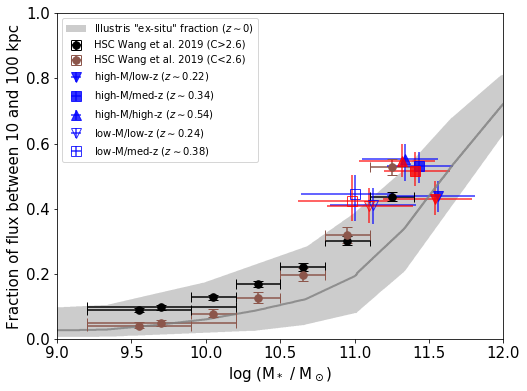

In [244]:
from run_fit import *

r_arr = np.logspace(-1,3,100)
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
sp = np.where((r_arr > 10) & (r_arr<100))[0]

fig, ax = plt.subplots(1,1,figsize=(8,6))

data = np.loadtxt('Illustris_frac/Illustris_fexsitu_med.txt', delimiter=',')
plt.plot(np.log10(data[:,0]),data[:,1],c='grey',lw=2,alpha=0.8)
data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_low.txt', delimiter=',')
plt.fill_between(np.log10(data[:,0]),
                 np.interp(np.log10(data[:,0]),np.log10(data_l[:,0]),data_l[:,1]),
                 np.interp(np.log10(data[:,0]),np.log10(data_h[:,0]),data_h[:,1]),
                         facecolor='k', alpha=0.2, label='Illustris \"ex-situ\" fraction ($z\sim 0$)')

# Wang+19 table 1
for i,(R200,Mstr_low, Mstr_high) in enumerate(zip([459.08,288.16,214.80,173.18,142.85,114.64,120.76],
                                                  [11.1,10.8,10.5,10.2,9.9,9.2,9.2],
                                                  [11.4,11.1,10.8,10.5,10.2,9.9,10.2])):
    Mstr = (Mstr_low + Mstr_high)/2
    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True)
    p_HSC = galprofdat_HSC['I_arr']
    p_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 + 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0.0001 + 0.0019, xe2=0.0231+0.0012)
    p_high_HSC = galprofdat_HSC['I_arr']
    p_high_HSC3 = galprofdat_HSC3['I_arr']

    galprofdat_HSC = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, xe2= 0.0165 - 0.0008)
    galprofdat_HSC3 = gal_profile_model().Wang19_profile(r_arr, im, R200=R200, extendedness=True,
                                                        xe3=0,xe2=0.0231-0.0012)
    p_low_HSC  = galprofdat_HSC['I_arr']
    p_low_HSC3 = galprofdat_HSC3['I_arr']

    fHSC = np.sum(p_HSC[sp]*r_arr[sp]**2)/np.sum(p_HSC*r_arr**2)
    f_low_HSC = np.sum(p_low_HSC[sp]*r_arr[sp]**2)/np.sum(p_low_HSC*r_arr**2)
    f_high_HSC = np.sum(p_high_HSC[sp]*r_arr[sp]**2)/np.sum(p_high_HSC*r_arr**2)
    
    
    fHSC3 = np.sum(p_HSC3[sp]*r_arr[sp]**2)/np.sum(p_HSC3*r_arr**2)
    f_low_HSC3 = np.sum(p_low_HSC3[sp]*r_arr[sp]**2)/np.sum(p_low_HSC3*r_arr**2)
    f_high_HSC3 = np.sum(p_high_HSC3[sp]*r_arr[sp]**2)/np.sum(p_high_HSC3*r_arr**2)
    
    if i == 0:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='k',
                    label = 'HSC Wang et al. 2019 (C>2.6)')
        ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
                        fmt='.', capsize=5, markersize=15, c='C5',
                    label = 'HSC Wang et al. 2019 (C<2.6)')
    else:
        ax.errorbar([Mstr], [fHSC], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC - f_high_HSC],[f_low_HSC - fHSC]],
                        fmt='.', capsize=5, markersize=15, c='k')
        ax.errorbar([Mstr], [fHSC3], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                       yerr=[[fHSC3 - f_high_HSC3],[f_low_HSC3 - fHSC3]],
                        fmt='.', capsize=5, markersize=15, c='C5')

weighted_avg1,weighted_var1,weighted_varh1,weighted_varl1 = 0,0,0,0
weighted_avg2,weighted_var2,weighted_varh2,weighted_varl2 = 0,0,0,0
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mstr = np.median(srcinfo[i]['logMstr'])
    Mstr_low = np.percentile(srcinfo[i]['logMstr'], 16)
    Mstr_high = np.percentile(srcinfo[i]['logMstr'], 84)
    xlabel = '<z> = %.2f, %d < m < %d \n %d < M < %d'\
                      %(np.median(srcinfo[i]['z']),m_min,m_max, M_min, M_max)

    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']        
             
        if inst == 1:
            f1 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
            f1_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
            f1_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            ax.errorbar([Mstr*1.001], [f1], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f1 - f1_high],[f1_low - f1]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' ($z\sim %.2f$)'%np.median(srcinfo[i]['z']))
        else:
            f2 = np.sum(p[sp]*r_arr[sp]**2)/np.sum(p*r_arr**2)
            f2_low = np.sum(p_low[sp]*r_arr[sp]**2)/np.sum(p_low*r_arr**2)
            f2_high = np.sum(p_high[sp]*r_arr[sp]**2)/np.sum(p_high*r_arr**2)
            ax.errorbar([Mstr*0.999], [f2], xerr=[[Mstr-Mstr_low],[Mstr_high-Mstr]],
                           yerr=[[f2 - f1_high],[f2_low - f2]], alpha=0.8,
                        fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
    
    sig1 = (f1_high - f1_low) / 2
    sig2 = (f2_high - f2_low) / 2
    weighted_avg1 += f1 / sig1**2
    weighted_var1 += 1 / sig1**2
    weighted_avg2 += f2 / sig2**2
    weighted_var2 += 1 / sig2**2
    weighted_varh1 += 1 / (f1_high-f1)**2
    weighted_varl1 += 1 / (f1-f1_low)**2
    weighted_varh2 += 1 / (f2_high-f2)**2
    weighted_varl2 += 1 / (f2-f2_low)**2
    print('1.1 um, bin #%d, f_10-100 = %.2f + %.2f - %.2f'%(i,f1,f1-f1_low,f1_high-f1))
    print('1.6 um, bin #%d, f_10-100 = %.2f + %.2f - %.2f'%(i,f2,f2-f2_low,f2_high-f2))

    ax.legend(loc=2, fontsize=10)

weighted_avg1 /= weighted_var1
weighted_var1 = np.sqrt(1 / weighted_var1)
weighted_varh1 = np.sqrt(1 / weighted_varh1)
weighted_varl1 = np.sqrt(1 / weighted_varl1)
weighted_avg2 /= weighted_var2
weighted_var2 = np.sqrt(1 / weighted_var2)
weighted_varh2 = np.sqrt(1 / weighted_varh2)
weighted_varl2 = np.sqrt(1 / weighted_varl2)
print('1.1 um, f_10-100 = %.2f + %.2f - %.2f'%(weighted_avg1, weighted_varh1, weighted_varl1))
print('1.6 um, f_10-100 = %.2f + %.2f - %.2f'%(weighted_avg2, weighted_varh2, weighted_varl2))

    
ax.set_ylim([0,1])
ax.set_xlim([9,12])
ax.set_xlabel('log (M$_*$ / M$_\odot$)', fontsize=15)
ax.set_ylabel("Fraction of flux between 10 and 100 kpc", fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# plt.savefig('plots/paperfig/frac_exsitu.pdf',
#             dpi = 200, bbox_inches='tight')

In [ ]:
from run_fit import *

data_dict = {}
for inst in [1,2]:
    data_dict[inst] = {}
    for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
        m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
        data_dict[inst][i] = {}
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=None,savename=savename)
        Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
        Re2_low, A1h_low, A2h_low \
        = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
        Re2_high, A1h_high, A2h_high \
        = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

        profgal_arr,profpsf_arr,profgalint_arr = 0,0,0
        profgal_arr_low,profpsf_arr_low,profgalint_arr_low = 0,0,0
        profgal_arr_high,profpsf_arr_high,profgalint_arr_high = 0,0,0

        for ifield in [4,5,6,7,8]:
            print(inst, i, ifield)
            param_fit = fit_stacking_mcmc(1, ifield, im, m_min=m_min, m_max=m_max,
                                         Mabs_min=M_min, Mabs_max=M_max)

            modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
            profgal_arr += modelprof['profgal']
            profpsf_arr += modelprof['profpsf']
            norm_int = param_fit.get_gal_profile_norm(Re2=Re2, A1h=A1h, A2h=A2h)
            profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
            profgalint_arr += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

            modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h, A2h=A2h)
            profgal_arr_low += modelprof['profgal']
            profpsf_arr_low += modelprof['profpsf']
            norm_int = param_fit.get_gal_profile_norm(Re2=Re2_low, A1h=A1h, A2h=A2h)
            profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
            profgalint_arr_low += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

            modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h, A2h=A2h)
            profgal_arr_high += modelprof['profgal']
            profpsf_arr_high += modelprof['profpsf']
            norm_int = param_fit.get_gal_profile_norm(Re2=Re2_high, A1h=A1h, A2h=A2h)
            profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
            profgalint_arr_high += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int


        data_dict[inst][i]['profgal_arr'] = profgal_arr / 5
        data_dict[inst][i]['profpsf_arr'] = profpsf_arr / 5
        data_dict[inst][i]['profgalint_arr'] = profgalint_arr / 5

        data_dict[inst][i]['profgal_arr_high'] = profgal_arr_high / 5
        data_dict[inst][i]['profpsf_arr_high'] = profpsf_arr_high / 5
        data_dict[inst][i]['profgalint_arr_high'] = profgalint_arr_high / 5

        data_dict[inst][i]['profgal_arr_low'] = profgal_arr_low / 5
        data_dict[inst][i]['profpsf_arr_low'] = profpsf_arr_low / 5
        data_dict[inst][i]['profgalint_arr_low'] = profgalint_arr_low / 5

        data_dict[inst][i]['profex'] = data_dict[inst][i]['profgal_arr'] - \
                    data_dict[inst][i]['profpsf_arr']
        data_dict[inst][i]['profex_low'] = data_dict[inst][i]['profgal_arr_low'] - \
                    data_dict[inst][i]['profpsf_arr_low']
        data_dict[inst][i]['profex_high'] = data_dict[inst][i]['profgal_arr_high'] - \
                    data_dict[inst][i]['profpsf_arr_high']

        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
        data_dict[inst][i]['prof1h'] = modelprof['prof1h']
        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h_low, A2h=A2h)
        data_dict[inst][i]['prof1h_low'] = modelprof['prof1h']
        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h_high, A2h=A2h)
        data_dict[inst][i]['prof1h_high'] = modelprof['prof1h']

    data_dict['rbins'] = param_fit.rbins
    data_dict['rbinedges'] = param_fit.rbinedges

clear_output()

z=0.22, N=2.77, N(weighted)=2.77
z=0.34, N=2.48, N(weighted)=2.48
z=0.54, N=2.32, N(weighted)=2.32
z=0.24, N=2.82, N(weighted)=2.82
z=0.38, N=2.62, N(weighted)=2.62


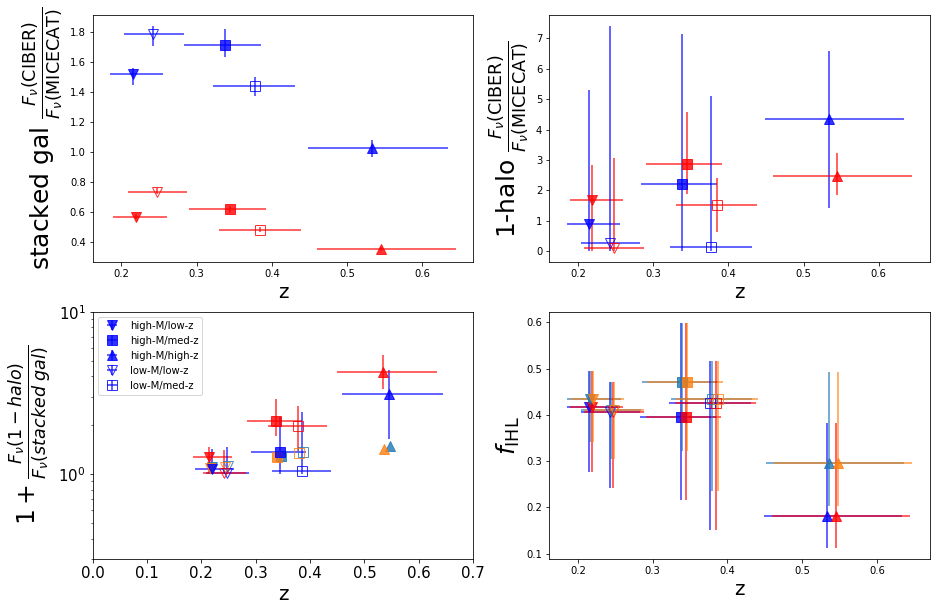

In [173]:
from run_fit import *

fig, ax = plt.subplots(2,2,figsize=(15,10))
# df = get_micecat_df(1, add_Rvir=True)
# make_srcmap_class1 = make_srcmap(1)
# make_srcmap_class2 = make_srcmap(2)

r_arr = data_dict['rbins']
dlnr_arr = np.diff(np.log(data_dict['rbinedges']))
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    
    z = np.median(srcinfo[i]['z'])
    z_low = np.percentile(srcinfo[i]['z'], 16)
    z_high = np.percentile(srcinfo[i]['z'], 84)
    Mh = 10**np.median(srcinfo[i]['logMh'])
    
    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        rkpc_arr = np.logspace(-1,3,100)
        sp = np.where((rkpc_arr > 10))[0]

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']
        
        fext = np.sum(p[sp]*rkpc_arr[sp]**2)/np.sum(p*rkpc_arr**2)
        fext_high = np.sum(p_low[sp]*rkpc_arr[sp]**2)/np.sum(p_low*rkpc_arr**2)
        fext_low = np.sum(p_high[sp]*rkpc_arr[sp]**2)/np.sum(p_high*rkpc_arr**2)
        if fext > fext_high or fext < fext_low:
            fext = (fext_low + fext_high) / 2
        if fext_high<fext_low:
            fext_high, fext_low = fext_low, fext_high
        Lgal = 2*np.pi*np.sum(data_dict[inst][i]['profgal_arr']*r_arr**2*dlnr_arr)
        Lgal_low = 2*np.pi*np.sum(data_dict[inst][i]['profgal_arr_low']*r_arr**2*dlnr_arr)
        Lgal_high = 2*np.pi*np.sum(data_dict[inst][i]['profgal_arr_high']*r_arr**2*dlnr_arr)
        L1h = 2*np.pi*np.sum(data_dict[inst][i]['prof1h']*r_arr**2*dlnr_arr)
        L1h_low = 2*np.pi*np.sum(data_dict[inst][i]['prof1h_low']*r_arr**2*dlnr_arr)
        L1h_high = 2*np.pi*np.sum(data_dict[inst][i]['prof1h_high']*r_arr**2*dlnr_arr)
        
        u_convert = (u.nW/u.m**2/u.sr * u.arcsec**2/u.GHz).to(u.Jy)
        Lgal_Jy = (Lgal / band_info(inst).nu) * u_convert
        Lgal_low_Jy = (Lgal_low / band_info(inst).nu) * u_convert
        Lgal_high_Jy = (Lgal_high / band_info(inst).nu) * u_convert
        L1h_Jy = (L1h / band_info(inst).nu) * u_convert
        L1h_low_Jy = (L1h_low / band_info(inst).nu) * u_convert
        L1h_high_Jy = (L1h_high / band_info(inst).nu) * u_convert
        
        f = L1h / Lgal + 1
        f_low = L1h_low / Lgal_high + 1
        f_high = L1h_high / Lgal_low + 1
        if inst == 1:        
            ax[1][0].errorbar([z*1.01], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name)
            Lgal_Jy1, Lgal_low_Jy1, Lgal_high_Jy1 = Lgal_Jy, Lgal_low_Jy, Lgal_high_Jy
            L1h_Jy1, L1h_low_Jy1, L1h_high_Jy1 = L1h_Jy, L1h_low_Jy, L1h_high_Jy
            f1, f_low1, f_high1 = f, f_low, f_high
            fext1, fext_low1, fext_high1 = fext, fext_low, fext_high
        else:
            ax[1][0].errorbar([z*0.99], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
            Lgal_Jy2, Lgal_low_Jy2, Lgal_high_Jy2 = Lgal_Jy, Lgal_low_Jy, Lgal_high_Jy
            L1h_Jy2, L1h_low_Jy2, L1h_high_Jy2 = L1h_Jy, L1h_low_Jy, L1h_high_Jy
            f2, f_low2, f_high2 = f, f_low, f_high
            fext2, fext_low2, fext_high2 = fext, fext_low, fext_high
            
    dfm = df.loc[(df['I']>=m_min) & (df['I']<m_max) & (df['M_I']>=M_min) & (df['M_I']<M_max)]
    fcent = np.sum(dfm['flag_central']==0)/len(dfm)
    galids = np.array(dfm.index)
    haloids = dfm['unique_halo_id'].values
    shuffle_idx = np.random.permutation(len(dfm))
    galids, haloids = galids[shuffle_idx], haloids[shuffle_idx]
    Nbright_arr = []
    Nall_arr = []
    Fgal_arr1 = []
    Ffaint_arr1 = []
    Fbright_arr1 = []
    Fbrightm_arr1 = []
    Fgal_arr2 = []
    Ffaint_arr2 = []
    Fbright_arr2 = []
    Fbrightm_arr2 = []
    for igal, (haloid, galid) in enumerate(zip(haloids, galids)):
        if igal >50:
            break
#         if igal%50==0:
#             print(i,igal)
        dfi = df[df['unique_halo_id']==haloid].copy()
        dfi['stack_gal_id'] = galid
        Rvi = np.mean(dfi['Rv_arcsec'].values)
        Mh = 10**np.mean(dfi['lmhalo'].values)
        if (Rvi > 0) and (Mh > 1e14):
            continue
        Fnu_arr1 = 3631 * 10**(-dfi['I'].values/2.5)
        Fnu_arr2 = 3631 * 10**(-dfi['H'].values/2.5)
        Fgal_arr1.append(float(Fnu_arr1[dfi.index==galid]))
        Fgal_arr2.append(float(Fnu_arr2[dfi.index==galid]))
        Ffaint_arr1.append(np.sum(Fnu_arr1[dfi['I']>20]))
        Ffaint_arr2.append(np.sum(Fnu_arr2[dfi['I']>20]))
        Nall_arr.append(len(dfi))
        Nbright_arr.append(np.sum(dfi['I']<20)-1)
        
        spb = np.where((dfi['I']<=20) & (dfi.index!=galid))[0]
        if len(spb)!=0:
            dfib = dfi.iloc[spb]
            Fbright_arr1.append(np.sum(Fnu_arr1[spb]))
            Fbright_arr2.append(np.sum(Fnu_arr2[spb]))
#             x_arr = dfib['x'].values
#             x_arr = x_arr - int(x_arr[0]) + 512
#             y_arr = dfib['y'].values
#             y_arr = y_arr - int(y_arr[0]) + 512
#             mI_arr, mH_arr = dfib['I'].values, dfib['H'].values
#             make_srcmap_class1.xls = np.array(x_arr)
#             make_srcmap_class1.yls = np.array(y_arr)
#             make_srcmap_class1.ms = np.array(mI_arr)
#             make_srcmap_class1.ms_inband = np.array(mI_arr)
#             make_srcmap_class2.xls = np.array(x_arr)
#             make_srcmap_class2.yls = np.array(y_arr)
#             make_srcmap_class2.ms = np.array(mI_arr)
#             make_srcmap_class2.ms_inband = np.array(mH_arr)

#             srcmap1 = make_srcmap_class1.run_srcmap(ptsrc=True, verbose=False)
#             srcmap2 = make_srcmap_class2.run_srcmap(ptsrc=True, verbose=False)
#             mask = Ith_mask_mock(x_arr,y_arr, mI_arr, verbose=False)[0]
#             Fbrightm_arr1.append(np.sum(srcmap1*mask)/np.sum(srcmap1) * Fbright_arr1[-1])
#             Fbrightm_arr2.append(np.sum(srcmap2*mask)/np.sum(srcmap2) * Fbright_arr2[-1])
            Fbrightm_arr1.append(0.)###
            Fbrightm_arr2.append(0.)###
        else:
            Fbright_arr1.append(0.)
            Fbright_arr2.append(0.)
            Fbrightm_arr1.append(0.)
            Fbrightm_arr2.append(0.)
            
    Nall_arr = np.array(Nall_arr)
    Nbright_arr = np.array(Nbright_arr)
    Fgal_arr1 = np.array(Fgal_arr1)
    Ffaint_arr1 = np.array(Ffaint_arr1)
    Fbright_arr1 = np.array(Fbright_arr1)
    Fbrightm_arr1 = np.array(Fbrightm_arr1)
    Fgal_arr2 = np.array(Fgal_arr2)
    Ffaint_arr2 = np.array(Ffaint_arr2)
    Fbright_arr2 = np.array(Fbright_arr2)
    Fbrightm_arr2 = np.array(Fbrightm_arr2)
    F1h_arr1, F1h_arr2 = Ffaint_arr1+Fbrightm_arr1, Ffaint_arr2+Fbrightm_arr2
    
    ax[0][0].errorbar([z*0.99], [Lgal_Jy1/np.median(Fgal_arr1)], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[Lgal_Jy1/np.median(Fgal_arr1) - Lgal_low_Jy1/np.median(Fgal_arr1)],
                         [Lgal_high_Jy1/np.median(Fgal_arr1) - Lgal_Jy1/np.median(Fgal_arr1)]],
                   alpha=0.8, fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', label = name)
    ax[0][0].errorbar([z*1.01], [Lgal_Jy2/np.median(Fgal_arr2)], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[Lgal_Jy2/np.median(Fgal_arr2) - Lgal_low_Jy2/np.median(Fgal_arr2)],
                         [Lgal_high_Jy2/np.median(Fgal_arr2) - Lgal_Jy2/np.median(Fgal_arr2)]],
                   alpha=0.8, fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
    ax[0][1].errorbar([z*0.99], [L1h_Jy1/np.median(F1h_arr1)], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[L1h_Jy1/np.median(F1h_arr1) - L1h_low_Jy1/np.median(F1h_arr1)],
                         [L1h_high_Jy1/np.median(F1h_arr1) - L1h_Jy1/np.median(F1h_arr1)]],
                   alpha=0.8, fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', label = name)
    ax[0][1].errorbar([z*1.01], [L1h_Jy2/np.median(F1h_arr2)], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[L1h_Jy2/np.median(F1h_arr2) - L1h_low_Jy2/np.median(F1h_arr2)],
                         [L1h_high_Jy2/np.median(F1h_arr2) - L1h_Jy2/np.median(F1h_arr2)]],
                   alpha=0.8, fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')

    rbf1 = np.median((Ffaint_arr1+Fbrightm_arr1)/Fgal_arr1)
    rbf_low1 = np.percentile((Ffaint_arr1+Fbrightm_arr1)/Fgal_arr1,16)
    rbf_high1 = np.percentile((Ffaint_arr1+Fbrightm_arr1)/Fgal_arr1,84)

    rbf2 = np.median((Ffaint_arr2+Fbrightm_arr2)/Fgal_arr2)
    rbf_low2 = np.percentile((Ffaint_arr2+Fbrightm_arr2)/Fgal_arr2,16)
    rbf_high2 = np.percentile((Ffaint_arr2+Fbrightm_arr2)/Fgal_arr2,84)

    ax[1][0].plot([z*1.015], [1+rbf1], alpha=0.8,
                    marker=fmt,mfc=mfc, markersize=10, c='C0')
    ax[1][0].plot([z*0.995], [1+rbf2], alpha=0.8,
                    marker=fmt,mfc=mfc, markersize=10, c='C1')

#     Lgal_Jy1, Lgal_low_Jy1, Lgal_high_Jy1 = Lgal_Jy, Lgal_low_Jy, Lgal_high_Jy
#     L1h_Jy1, L1h_low_Jy1, L1h_high_Jy1 = L1h_Jy, L1h_low_Jy, L1h_high_Jy
#     Fgal_arr1 = np.array(Fgal_arr1)
#     Ffaint_arr1 = np.array(Ffaint_arr1)
#     Fbright_arr1 = np.array(Fbright_arr1)
    
#     Lihl_corr = (fext*Lgal_Jy1) * (Fgal_arr1+Ffaint_arr1+Fbright_arr1)/Fgal_arr1
#     Lgal_corr = Fgal_arr1
#     L1h_corr = L1h_Jy1 * (Ffaint_arr1+Fbright_arr1)/(Ffaint_arr1+Fbrightm_arr1)
#     fihl1 = Lihl_corr / (Lgal_corr+L1h_corr)
    Neff = 1.
    fihl1 = fext1 / (1 + (L1h_Jy1 / Neff / Lgal_Jy1))
    fihl_low1 = fext_low1 / (1 + (L1h_high_Jy1 / Neff / Lgal_low_Jy1))
    fihl_high1 = fext_high1 / (1 + (L1h_low_Jy1 / Neff / Lgal_high_Jy1))
    fihl2 = fext2 / (1 + (L1h_Jy2) / Neff / Lgal_Jy2)
    fihl_low2 = fext_low2 / (1 + (L1h_high_Jy2 / Neff / Lgal_low_Jy2))
    fihl_high2 = fext_high2 / (1 + (L1h_low_Jy2 / Neff / Lgal_high_Jy2))
    ax[1][1].errorbar([z*0.99], [fihl1], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[fihl1 - fihl_low1],[fihl_high1 - fihl1]],
                   alpha=0.8, fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', label = name)
    ax[1][1].errorbar([z*1.01], [fihl1], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[fihl1 - fihl_low1],[fihl_high1 - fihl1]],
                   alpha=0.8, fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
    
    Neff = np.mean(1+Fbright_arr1/Fgal_arr1)
    fihl1 = fext1 / (1 + (L1h_Jy1 / Neff / Lgal_Jy1))
    fihl_low1 = fext_low1 / (1 + (L1h_high_Jy1 / Neff / Lgal_low_Jy1))
    fihl_high1 = fext_high1 / (1 + (L1h_low_Jy1 / Neff / Lgal_high_Jy1))
    fihl2 = fext2 / (1 + (L1h_Jy2) / Neff / Lgal_Jy2)
    fihl_low2 = fext_low2 / (1 + (L1h_high_Jy2 / Neff / Lgal_low_Jy2))
    fihl_high2 = fext_high2 / (1 + (L1h_low_Jy2 / Neff / Lgal_high_Jy2))
    ax[1][1].errorbar([z*0.995], [fihl1], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[fihl1 - fihl_low1],[fihl_high1 - fihl1]],
                   alpha=0.8, fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C0', label = name)
    ax[1][1].errorbar([z*1.015], [fihl1], xerr=[[z-z_low],[z_high-z]],
                   yerr=[[fihl1 - fihl_low1],[fihl_high1 - fihl1]],
                   alpha=0.8, fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='C1')
    
    Neffn = np.mean(1+Nbright_arr)
    Neffw = np.mean(1+Fbright_arr1/Fgal_arr1)
    print('z=%.2f, N=%.2f, N(weighted)=%.2f'%(z,Neffn,Neffw))
    
ax[0][0].set_xlabel('z', fontsize=20)
ax[0][0].set_ylabel(r'stacked gal $\frac{F_{\nu}({\rm CIBER})}{F_{\nu}({\rm MICECAT})}$', fontsize=25)
ax[0][1].set_xlabel('z', fontsize=20)
ax[0][1].set_ylabel(r'1-halo $\frac{F_{\nu}({\rm CIBER})}{F_{\nu}({\rm MICECAT})}$', fontsize=25)
ax[1][1].set_xlabel('z', fontsize=20)
ax[1][1].set_ylabel(r'$f_{\rm IHL}$', fontsize=25)

ax[1][0].legend(fontsize=10, loc=2)#bbox_to_anchor=(1,1))
ax[1][0].set_yscale('log')
ax[1][0].set_ylim([3e-1,1e1])
ax[1][0].set_xlim([0,0.7])
ax[1][0].set_xlabel('z', fontsize=20)
ax[1][0].set_ylabel(r'$1+\frac{F_{\nu}(1-halo)}{F_{\nu}(stacked\,\,gal)}$', fontsize=25)
ax[1][0].tick_params(axis='x', labelsize=15)
ax[1][0].tick_params(axis='y', labelsize=15)
# clear_output()

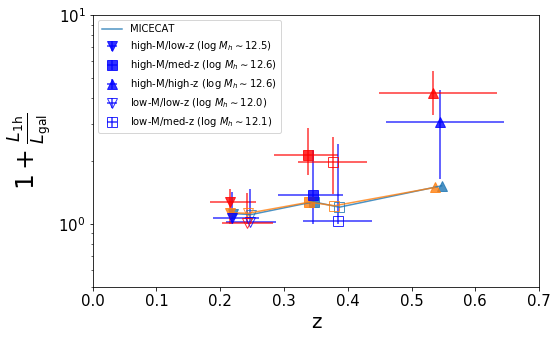

In [203]:
from run_fit import *

fig, ax = plt.subplots(1,1,figsize=(8,5))
# df = get_micecat_df(1, add_Rvir=True)
# make_srcmap_class1 = make_srcmap(1)
# make_srcmap_class2 = make_srcmap(2)

z_all = []
rbf1_all, rbf2_all = [],[]
Neff1_all, Neff2_all = [], []
r_arr = data_dict['rbins']
dlnr_arr = np.diff(np.log(data_dict['rbinedges']))
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    
    z = np.median(srcinfo[i]['z'])
    z_low = np.percentile(srcinfo[i]['z'], 16)
    z_high = np.percentile(srcinfo[i]['z'], 84)
    Mh = 10**np.median(srcinfo[i]['logMh'])
    
    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        rkpc_arr = np.logspace(-1,3,100)
        sp = np.where((rkpc_arr > 10))[0]

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']
        
        fext = np.sum(p[sp]*rkpc_arr[sp]**2)/np.sum(p*rkpc_arr**2)
        fext_high = np.sum(p_low[sp]*rkpc_arr[sp]**2)/np.sum(p_low*rkpc_arr**2)
        fext_low = np.sum(p_high[sp]*rkpc_arr[sp]**2)/np.sum(p_high*rkpc_arr**2)
        if fext > fext_high or fext < fext_low:
            fext = (fext_low + fext_high) / 2
        if fext_high<fext_low:
            fext_high, fext_low = fext_low, fext_high
        Lgal = 2*np.pi*np.sum(data_dict[inst][i]['profgal_arr']*r_arr**2*dlnr_arr)
        Lgal_low = 2*np.pi*np.sum(data_dict[inst][i]['profgal_arr_low']*r_arr**2*dlnr_arr)
        Lgal_high = 2*np.pi*np.sum(data_dict[inst][i]['profgal_arr_high']*r_arr**2*dlnr_arr)
        L1h = 2*np.pi*np.sum(data_dict[inst][i]['prof1h']*r_arr**2*dlnr_arr)
        L1h_low = 2*np.pi*np.sum(data_dict[inst][i]['prof1h_low']*r_arr**2*dlnr_arr)
        L1h_high = 2*np.pi*np.sum(data_dict[inst][i]['prof1h_high']*r_arr**2*dlnr_arr)
        
        f = L1h / Lgal + 1
        f_low = L1h_low / Lgal_high + 1
        f_high = L1h_high / Lgal_low + 1
        if inst == 1:        
            ax.errorbar([z*1.01], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' (log $M_h\sim %.1f$)'%np.log10(Mh))
        else:
            ax.errorbar([z*0.99], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
            
    dfm = df.loc[(df['I']>=m_min) & (df['I']<m_max) & (df['M_I']>=M_min) & (df['M_I']<M_max)]
    fcent = np.sum(dfm['flag_central']==0)/len(dfm)
    galids = np.array(dfm.index)
    haloids = dfm['unique_halo_id'].values
    shuffle_idx = np.random.permutation(len(dfm))
    galids, haloids = galids[shuffle_idx], haloids[shuffle_idx]
    Nbright_arr = []
    Nall_arr = []
    Fgal_arr1 = []
    Ffaint_arr1 = []
    Fbright_arr1 = []
    Fbrightm_arr1 = []
    Fgal_arr2 = []
    Ffaint_arr2 = []
    Fbright_arr2 = []
    Fbrightm_arr2 = []
    for igal, (haloid, galid) in enumerate(zip(haloids, galids)):
        if igal >500:
            break
        if igal%50==0:
            print(i,igal)
        dfi = df[df['unique_halo_id']==haloid].copy()
        dfi['stack_gal_id'] = galid
        Rvi = np.mean(dfi['Rv_arcsec'].values)
        Mh = 10**np.mean(dfi['lmhalo'].values)
        if (Rvi > 0) and (Mh > 1e14):
            continue
        Fnu_arr1 = 3631 * 10**(-dfi['I'].values/2.5)
        Fnu_arr2 = 3631 * 10**(-dfi['H'].values/2.5)
        Fgal_arr1.append(float(Fnu_arr1[dfi.index==galid]))
        Fgal_arr2.append(float(Fnu_arr2[dfi.index==galid]))
        Ffaint_arr1.append(np.sum(Fnu_arr1[dfi['I']>20]))
        Ffaint_arr2.append(np.sum(Fnu_arr2[dfi['I']>20]))
        Nall_arr.append(len(dfi))
        Nbright_arr.append(np.sum(dfi['I']<20)-1)
        
        spb = np.where((dfi['I']<=20) & (dfi.index!=galid))[0]
        if len(spb)!=0:
            dfib = dfi.iloc[spb]
            Fbright_arr1.append(np.sum(Fnu_arr1[spb]))
            Fbright_arr2.append(np.sum(Fnu_arr2[spb]))
            x_arr = dfib['x'].values
            x_arr = x_arr - int(x_arr[0]) + 512
            y_arr = dfib['y'].values
            y_arr = y_arr - int(y_arr[0]) + 512
            mI_arr, mH_arr = dfib['I'].values, dfib['H'].values
            make_srcmap_class1.xls = np.array(x_arr)
            make_srcmap_class1.yls = np.array(y_arr)
            make_srcmap_class1.ms = np.array(mI_arr)
            make_srcmap_class1.ms_inband = np.array(mI_arr)
            make_srcmap_class2.xls = np.array(x_arr)
            make_srcmap_class2.yls = np.array(y_arr)
            make_srcmap_class2.ms = np.array(mI_arr)
            make_srcmap_class2.ms_inband = np.array(mH_arr)

            srcmap1 = make_srcmap_class1.run_srcmap(ptsrc=True, verbose=False)
            srcmap2 = make_srcmap_class2.run_srcmap(ptsrc=True, verbose=False)
            mask = Ith_mask_mock(x_arr,y_arr, mI_arr, verbose=False)[0]
            Fbrightm_arr1.append(np.sum(srcmap1*mask)/np.sum(srcmap1) * Fbright_arr1[-1])
            Fbrightm_arr2.append(np.sum(srcmap2*mask)/np.sum(srcmap2) * Fbright_arr2[-1])
        else:
            Fbright_arr1.append(0.)
            Fbright_arr2.append(0.)
            Fbrightm_arr1.append(0.)
            Fbrightm_arr2.append(0.)
            
    Nall_arr = np.array(Nall_arr)
    Nbright_arr = np.array(Nbright_arr)
    Fgal_arr1 = np.array(Fgal_arr1)
    Ffaint_arr1 = np.array(Ffaint_arr1)
    Fbright_arr1 = np.array(Fbright_arr1)
    Fbrightm_arr1 = np.array(Fbrightm_arr1)
    Fgal_arr2 = np.array(Fgal_arr2)
    Ffaint_arr2 = np.array(Ffaint_arr2)
    Fbright_arr2 = np.array(Fbright_arr2)
    Fbrightm_arr2 = np.array(Fbrightm_arr2)
    F1h_arr1, F1h_arr2 = Ffaint_arr1+Fbrightm_arr1, Ffaint_arr2+Fbrightm_arr2
    
    Neff1_all.append(np.mean(1+Fbright_arr1/Fgal_arr1))
    Neff2_all.append(np.mean(1+Fbright_arr2/Fgal_arr2))
    print(i,np.mean(1+Fbright_arr1/Fgal_arr1), np.mean(1+Fbright_arr2/Fgal_arr2))
    rbf1 = np.median((Ffaint_arr1+Fbrightm_arr1)/Fgal_arr1)
    rbf2 = np.median((Ffaint_arr2+Fbrightm_arr2)/Fgal_arr2)
    ax.plot([z*1.015], [1+rbf1], alpha=0.8,
                    marker=fmt,mfc=mfc, markersize=10, c='C0')
    ax.plot([z*0.995], [1+rbf2], alpha=0.8,
                    marker=fmt,mfc=mfc, markersize=10, c='C1')
    z_all.append(z)
    rbf1_all.append(rbf1)
    rbf2_all.append(rbf2)

Neff1_all = np.array(Neff1_all)
Neff2_all = np.array(Neff2_all)
sp = np.argsort(z_all)
z_all = np.array(z_all)[sp]
rbf1_all, rbf2_all = np.array(rbf1_all)[sp], np.array(rbf2_all)[sp]
ax.plot(z_all*1.015, 1+rbf1_all, alpha=0.8, c='C0', label='MICECAT')
ax.plot(z_all*0.995, 1+rbf2_all, alpha=0.8, c='C1')

ax.legend(fontsize=10, loc=2)#bbox_to_anchor=(1,1))
ax.set_yscale('log')
ax.set_ylim([5e-1,1e1])
ax.set_xlim([0,0.7])
ax.set_xlabel('z', fontsize=20)
ax.set_ylabel(r'$1+\frac{L_{\rm 1h}}{L_{\rm gal}}$', fontsize=25)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.savefig('plots/paperfig/f1h_gal.pdf',
            dpi = 200, bbox_inches='tight')

clear_output()

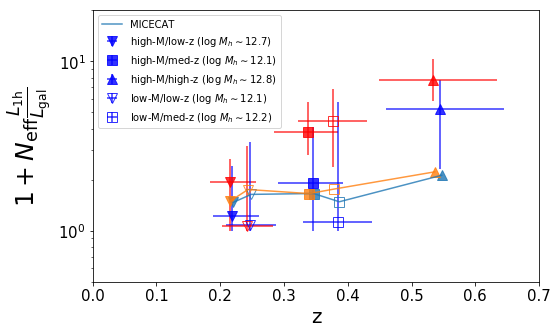

In [226]:
from run_fit import *

fig, ax = plt.subplots(1,1,figsize=(8,5))
# df = get_micecat_df(1, add_Rvir=True)
# make_srcmap_class1 = make_srcmap(1)
# make_srcmap_class2 = make_srcmap(2)

z_all = []
rbf1_all, rbf2_all = [],[]
Neff1_all, Neff2_all = [], []
r_arr = data_dict['rbins']
dlnr_arr = np.diff(np.log(data_dict['rbinedges']))
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    
    z = np.median(srcinfo[i]['z'])
    z_low = np.percentile(srcinfo[i]['z'], 16)
    z_high = np.percentile(srcinfo[i]['z'], 84)
    Mh = 10**np.median(srcinfo[i]['logMh'])
    ####            
    dfm = df.loc[(df['I']>=m_min) & (df['I']<m_max) & (df['M_I']>=M_min) & (df['M_I']<M_max)]
    fcent = np.sum(dfm['flag_central']==0)/len(dfm)
    galids = np.array(dfm.index)
    haloids = dfm['unique_halo_id'].values
    shuffle_idx = np.random.permutation(len(dfm))
    galids, haloids = galids[shuffle_idx], haloids[shuffle_idx]
    Nbright_arr = []
    Nall_arr = []
    Fgal_arr1 = []
    Ffaint_arr1 = []
    Fbright_arr1 = []
    Fbrightm_arr1 = []
    Fgal_arr2 = []
    Ffaint_arr2 = []
    Fbright_arr2 = []
    Fbrightm_arr2 = []
    for igal, (haloid, galid) in enumerate(zip(haloids, galids)):
        if igal >100:
            break
        if igal%50==0:
            print(i,igal)
        dfi = df[df['unique_halo_id']==haloid].copy()
        dfi['stack_gal_id'] = galid
        Rvi = np.mean(dfi['Rv_arcsec'].values)
        Mh = 10**np.mean(dfi['lmhalo'].values)
        if (Rvi > 0) and (Mh > 1e14):
            continue
        Fnu_arr1 = 3631 * 10**(-dfi['I'].values/2.5)
        Fnu_arr2 = 3631 * 10**(-dfi['H'].values/2.5)
        Fgal_arr1.append(float(Fnu_arr1[dfi.index==galid]))
        Fgal_arr2.append(float(Fnu_arr2[dfi.index==galid]))
        Ffaint_arr1.append(np.sum(Fnu_arr1[dfi['I']>20]))
        Ffaint_arr2.append(np.sum(Fnu_arr2[dfi['I']>20]))
        Nall_arr.append(len(dfi))
        Nbright_arr.append(np.sum(dfi['I']<20)-1)
        
        spb = np.where((dfi['I']<=20) & (dfi.index!=galid))[0]
        if len(spb)!=0:
            dfib = dfi.iloc[spb]
            Fbright_arr1.append(np.sum(Fnu_arr1[spb]))
            Fbright_arr2.append(np.sum(Fnu_arr2[spb]))
            x_arr = dfib['x'].values
            x_arr = x_arr - int(x_arr[0]) + 512
            y_arr = dfib['y'].values
            y_arr = y_arr - int(y_arr[0]) + 512
            mI_arr, mH_arr = dfib['I'].values, dfib['H'].values
            make_srcmap_class1.xls = np.array(x_arr)
            make_srcmap_class1.yls = np.array(y_arr)
            make_srcmap_class1.ms = np.array(mI_arr)
            make_srcmap_class1.ms_inband = np.array(mI_arr)
            make_srcmap_class2.xls = np.array(x_arr)
            make_srcmap_class2.yls = np.array(y_arr)
            make_srcmap_class2.ms = np.array(mI_arr)
            make_srcmap_class2.ms_inband = np.array(mH_arr)

            srcmap1 = make_srcmap_class1.run_srcmap(ptsrc=True, verbose=False)
            srcmap2 = make_srcmap_class2.run_srcmap(ptsrc=True, verbose=False)
            mask = Ith_mask_mock(x_arr,y_arr, mI_arr, verbose=False)[0]
            Fbrightm_arr1.append(np.sum(srcmap1*mask)/np.sum(srcmap1) * Fbright_arr1[-1])
            Fbrightm_arr2.append(np.sum(srcmap2*mask)/np.sum(srcmap2) * Fbright_arr2[-1])
        else:
            Fbright_arr1.append(0.)
            Fbright_arr2.append(0.)
            Fbrightm_arr1.append(0.)
            Fbrightm_arr2.append(0.)
            
    Nall_arr = np.array(Nall_arr)
    Nbright_arr = np.array(Nbright_arr)
    Fgal_arr1 = np.array(Fgal_arr1)
    Ffaint_arr1 = np.array(Ffaint_arr1)
    Fbright_arr1 = np.array(Fbright_arr1)
    Fbrightm_arr1 = np.array(Fbrightm_arr1)
    Fgal_arr2 = np.array(Fgal_arr2)
    Ffaint_arr2 = np.array(Ffaint_arr2)
    Fbright_arr2 = np.array(Fbright_arr2)
    Fbrightm_arr2 = np.array(Fbrightm_arr2)
    F1h_arr1, F1h_arr2 = Ffaint_arr1+Fbrightm_arr1, Ffaint_arr2+Fbrightm_arr2
    
    Neff1_all.append(np.mean(1+Fbright_arr1/Fgal_arr1))
    Neff2_all.append(np.mean(1+Fbright_arr2/Fgal_arr2))
    rbf1 = np.median((Ffaint_arr1+Fbrightm_arr1)/Fgal_arr1)
    rbf2 = np.median((Ffaint_arr2+Fbrightm_arr2)/Fgal_arr2)

    ax.plot([z*1.015], [1+Neff1_all[i]*rbf1], alpha=0.8,
                    marker=fmt,mfc=mfc, markersize=10, c='C0')
    ax.plot([z*0.995], [1+Neff2_all[i]*rbf2], alpha=0.8,
                    marker=fmt,mfc=mfc, markersize=10, c='C1')
    z_all.append(z)
    rbf1_all.append(rbf1)
    rbf2_all.append(rbf2)

    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        rkpc_arr = np.logspace(-1,3,100)
        sp = np.where((rkpc_arr > 10))[0]

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']
        
        fext = np.sum(p[sp]*rkpc_arr[sp]**2)/np.sum(p*rkpc_arr**2)
        fext_high = np.sum(p_low[sp]*rkpc_arr[sp]**2)/np.sum(p_low*rkpc_arr**2)
        fext_low = np.sum(p_high[sp]*rkpc_arr[sp]**2)/np.sum(p_high*rkpc_arr**2)
        if fext > fext_high or fext < fext_low:
            fext = (fext_low + fext_high) / 2
        if fext_high<fext_low:
            fext_high, fext_low = fext_low, fext_high
        Lgal = 2*np.pi*np.sum(data_dict[inst][i]['profgal_arr']*r_arr**2*dlnr_arr)
        Lgal_low = 2*np.pi*np.sum(data_dict[inst][i]['profgal_arr_low']*r_arr**2*dlnr_arr)
        Lgal_high = 2*np.pi*np.sum(data_dict[inst][i]['profgal_arr_high']*r_arr**2*dlnr_arr)
        L1h = 2*np.pi*np.sum(data_dict[inst][i]['prof1h']*r_arr**2*dlnr_arr)
        L1h_low = 2*np.pi*np.sum(data_dict[inst][i]['prof1h_low']*r_arr**2*dlnr_arr)
        L1h_high = 2*np.pi*np.sum(data_dict[inst][i]['prof1h_high']*r_arr**2*dlnr_arr)
        
#         f = L1h / Lgal + 1
#         f_low = L1h_low / Lgal_high + 1
#         f_high = L1h_high / Lgal_low + 1
        f = L1h / Lgal
        f_low = L1h_low / Lgal_high
        f_high = L1h_high / Lgal_low
        if inst == 1:        
            ax.errorbar([z*1.01], [1+Neff1_all[i]*f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[(1+Neff1_all[i]*f) - (1+Neff1_all[i]*f_low)],
                                 [(1+Neff1_all[i]*f_high) - (1+Neff1_all[i]*f)]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' (log $M_h\sim %.1f$)'%np.log10(Mh))
        else:
            ax.errorbar([z*0.99], [1+Neff2_all[i]*f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[(1+Neff2_all[i]*f) - (1+Neff2_all[i]*f_low)],
                                 [(1+Neff2_all[i]*f_high) - (1+Neff1_all[i]*f)]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')

sp = np.argsort(z_all)
z_all = np.array(z_all)[sp]
rbf1_all, rbf2_all = np.array(rbf1_all)[sp], np.array(rbf2_all)[sp]
Neff1_all, Neff2_all = np.array(Neff1_all)[sp], np.array(Neff2_all)[sp]
ax.plot(z_all*1.015, 1+Neff1_all*rbf1_all, alpha=0.8, c='C0', label='MICECAT')
ax.plot(z_all*0.995, 1+Neff2_all*rbf2_all, alpha=0.8, c='C1')
ax.legend(fontsize=10, loc=2)#bbox_to_anchor=(1,1))
ax.set_yscale('log')
ax.set_ylim([5e-1,2e1])
ax.set_xlim([0,0.7])
ax.set_xlabel('z', fontsize=20)
ax.set_ylabel(r'$1+N_{\rm eff}\frac{L_{\rm 1h}}{L_{\rm gal}}$', fontsize=25)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# plt.savefig('plots/paperfig/f1h_gal.pdf',
#             dpi = 200, bbox_inches='tight')

clear_output()

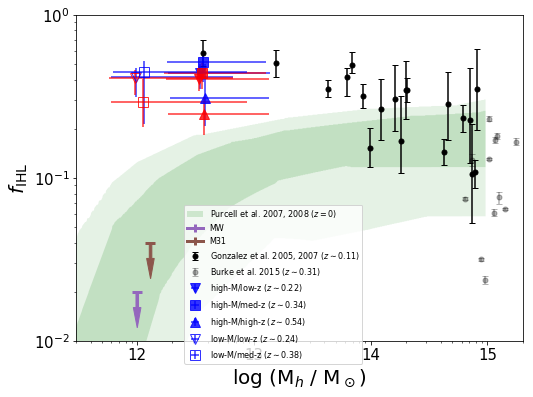

In [265]:
# from run_fit import *

fig, ax = plt.subplots(1,1,figsize=(8,6))

# Purcell
data = np.loadtxt('Illustris_frac/Purcell08_med.txt', delimiter=',')
data_h = np.loadtxt('Illustris_frac/Purcell08_68high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_68low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='g', alpha=0.15, label=r'Purcell et al. 2007, 2008 ($z=0$)')
data_h = np.loadtxt('Illustris_frac/Purcell08_95high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_95low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='g', alpha=0.1)

# MW, M31
plt.errorbar([1e12], [0.02], xerr=[1e12*0.1], yerr=[0],
             lw=3, color='C4', label='MW')
plt.errorbar([1.3e12], [0.04], xerr=[1.3e12*0.1], yerr=[0],
             lw=3, color='C5', label='M31')
plt.arrow(1e12, 0.02, 0, -0.02*0.4, width=0.5e11, length_includes_head=True, color='C4', 
         head_width=1.5e11, head_length=0.02*0.2, overhang=0)
plt.arrow(1.3e12, 0.04, 0, -0.04*0.4, width=0.5e11*1.3, length_includes_head=True, color='C5', 
         head_width=1.5e11*1.3, head_length=0.04*0.2, overhang=0)
 
# Gonzalez
Mh_arr,f_arr,f_low_arr, f_high_arr,z_arr = [],[],[],[],[]
for name,arr in Gonzalez_dict.items():
    z_arr.append(arr[0])
    Mh_arr.append(10**arr[1])
    L_BCGICL_L_tot = arr[5]
    L_ICL_L_BCGICL = 10**(-(arr[10] - arr[7])/2.5)
    f_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] - arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]+arr[11]+arr[12]) - arr[7])/2.5)
    f_low_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] + arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]-arr[11]-arr[13]) - arr[7])/2.5)
    f_high_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)

f_arr,f_low_arr, f_high_arr = np.array(f_arr),np.array(f_low_arr), np.array(f_high_arr)
plt.errorbar(Mh_arr, f_arr, yerr=[f_arr - f_low_arr,f_high_arr - f_arr], 
                            fmt='.',capsize=3, mfc=None, markersize=10, color='k',
            label='Gonzalez et al. 2005, 2007 '+r'($z\sim %.2f$)'%(np.median(z_arr)))
# Burke
plt.errorbar(Burke_dict['M200'], Burke_dict['f_ICL'], yerr=Burke_dict['f_ICL_err'], 
                fmt='.',capsize=3, mfc=None, markersize=10, color='k', alpha=0.3,
             label='Burke et al. 2015 '+r'($z\sim %.2f$)'%(np.median(Burke_dict['z'])))


r_arr = data_dict['rbins']
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
    Mh_low = 10**np.percentile(srcinfo[i]['logMh'], 16)
    Mh_high = 10**np.percentile(srcinfo[i]['logMh'], 84)

    for inst in [1,2]:
        
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        rkpc_arr = np.logspace(-1,3,100)
        sp = np.where((rkpc_arr > 10))[0]

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']
        
        fext = np.sum(p[sp]*rkpc_arr[sp]**2)/np.sum(p*rkpc_arr**2)
        fext_low = np.sum(p_low[sp]*rkpc_arr[sp]**2)/np.sum(p_low*rkpc_arr**2)
        fext_high = np.sum(p_high[sp]*rkpc_arr[sp]**2)/np.sum(p_high*rkpc_arr**2)
        
        Lgal = np.sum(data_dict[inst][i]['profgal_arr']*r_arr**2)
        Lgal_low = np.sum(data_dict[inst][i]['profgal_arr_low']*r_arr**2)
        Lgal_high = np.sum(data_dict[inst][i]['profgal_arr_high']*r_arr**2)
        L1h = np.sum(data_dict[inst][i]['prof1h']*r_arr**2)
        L1h_low = np.sum(data_dict[inst][i]['prof1h_low']*r_arr**2)
        L1h_high = np.sum(data_dict[inst][i]['prof1h_high']*r_arr**2)
        
        Neff = Neff1_all[i] if inst==1 else Neff2_all[i]
        f = fext / (1 + L1h/Lgal/Neff)
        f_low = fext_low / (1 + L1h_high/Lgal_low/Neff)
        f_high = fext_high / (1 + L1h_low/Lgal_high/Neff)
        if inst == 1:
            ax.errorbar([Mh*1.01], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' ($z\sim %.2f$)'%np.median(srcinfo[i]['z']))
        else:
            ax.errorbar([Mh*0.99], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')

ax.legend(fontsize=8, bbox_to_anchor=(0.65,0.43))
ax.set_ylim([1e-2,1])
ax.set_xlim([3e11,2e15])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('log (M$_h$ / M$_\odot$)', fontsize=20)
# ax.set_ylabel(r"$f_{\rm IHL} = \frac{L_{\rm gal} {\rm (r > 10 kpc)}}{(L_{\rm gal}+L_{\rm 1h})}$",
#               fontsize=20)
ax.set_ylabel(r"$f_{\rm IHL}$",
              fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks([1e12, 1e13, 1e14, 1e15])
ax.set_xticklabels(['12','13','14','15'])

plt.savefig('plots/paperfig/fIHL.pdf',
            dpi = 200, bbox_inches='tight')

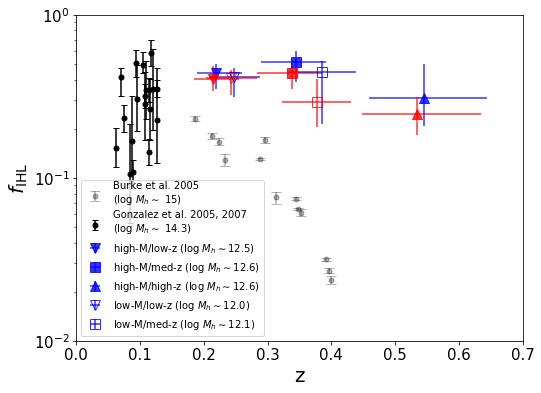

In [264]:
from run_fit import *

fig, ax = plt.subplots(1,1,figsize=(8,6))

# Burke
plt.errorbar(Burke_dict['z'], Burke_dict['f_ICL'], Burke_dict['f_ICL_err'],fmt='.',
             capsize=5, mfc=None, markersize=10, color='k', alpha=0.3, 
             label='Burke et al. 2005\n' + r'(log $M_h\sim$ 15)')

# Gonzalez
z_arr,Mh_arr,f_arr,f_low_arr, f_high_arr = [],[],[],[],[]
for name,arr in Gonzalez_dict.items():
    z_arr.append(arr[0])
    Mh_arr.append(10**arr[1])
    L_BCGICL_L_tot = arr[5]
    L_ICL_L_BCGICL = 10**(-(arr[10] - arr[7])/2.5)
    f_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] - arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]+arr[11]+arr[12]) - arr[7])/2.5)
    f_low_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] + arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]-arr[11]-arr[13]) - arr[7])/2.5)
    f_high_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)

f_arr,f_low_arr, f_high_arr = np.array(f_arr),np.array(f_low_arr), np.array(f_high_arr)
plt.errorbar(z_arr, f_arr, yerr=[f_arr - f_low_arr,f_high_arr - f_arr], 
                            fmt='.',capsize=3, mfc=None, markersize=10, color='k',
            label='Gonzalez et al. 2005, 2007\n'+r'(log $M_h\sim$ %.1f)'%(np.median(np.log10(Mh_arr))))


# # Illustris f_exsitu Rodriguez-Gomez
# data = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M11_med.txt', delimiter=',')
# data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M11_high.txt', delimiter=',')
# data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M11_low.txt', delimiter=',')
# plt.fill_between(np.arange(0,1,0.01),
#                  np.interp(np.arange(0,1,0.01),10**data_l[:,0]-1,10**data_l[:,1]),
#                  np.interp(np.arange(0,1,0.01),10**data_h[:,0]-1,10**data_h[:,1]),
#     facecolor='g', alpha=0.2, label='Rodriguez-Gomez et al. 2016\n'+\
#                  r'(log $M_*\sim$ 11)')

# data = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M12_med.txt', delimiter=',')
# data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M12_high.txt', delimiter=',')
# data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M12_low.txt', delimiter=',')
# plt.fill_between(np.arange(0,1,0.01),
#                  np.interp(np.arange(0,1,0.01),10**data_l[:,0]-1,10**data_l[:,1]),
#                  np.interp(np.arange(0,1,0.01),10**data_h[:,0]-1,10**data_h[:,1]),
#     facecolor='C5', alpha=0.2, label='Rodriguez-Gomez et al. 2016\n'+\
#                  r'(log $M_*\sim$ 12)')

r_arr = data_dict['rbins']
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    
    z = np.median(srcinfo[i]['z'])
    z_low = np.percentile(srcinfo[i]['z'], 16)
    z_high = np.percentile(srcinfo[i]['z'], 84)
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
   
    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        rkpc_arr = np.logspace(-1,3,100)
        sp = np.where((rkpc_arr > 10))[0]

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']
        
        fext = np.sum(p[sp]*rkpc_arr[sp]**2)/np.sum(p*rkpc_arr**2)
        fext_low = np.sum(p_low[sp]*rkpc_arr[sp]**2)/np.sum(p_low*rkpc_arr**2)
        fext_high = np.sum(p_high[sp]*rkpc_arr[sp]**2)/np.sum(p_high*rkpc_arr**2)
        
        Lgal = np.sum(data_dict[inst][i]['profgal_arr']*r_arr**2)
        Lgal_low = np.sum(data_dict[inst][i]['profgal_arr_low']*r_arr**2)
        Lgal_high = np.sum(data_dict[inst][i]['profgal_arr_high']*r_arr**2)
        L1h = np.sum(data_dict[inst][i]['prof1h']*r_arr**2)
        L1h_low = np.sum(data_dict[inst][i]['prof1h_low']*r_arr**2)
        L1h_high = np.sum(data_dict[inst][i]['prof1h_high']*r_arr**2)
        
        Neff = Neff1_all[i] if inst==1 else Neff2_all[i]
        f = fext / (1 + L1h/Lgal/Neff)
        f_low = fext_low / (1 + L1h_high/Lgal_low/Neff)
        f_high = fext_high / (1 + L1h_low/Lgal_high/Neff)
        
        if inst == 1:        
            ax.errorbar([z*1.01], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' (log $M_h\sim %.1f$)'%np.log10(Mh))
        else:
            ax.errorbar([z*0.99], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
            
ax.legend(fontsize=10, loc=3)#bbox_to_anchor=(1,1))
ax.set_ylim([0,1])
ax.set_yscale('log')
ax.set_ylim([1e-2,1e0])

ax.set_xlim([0,0.7])
ax.set_xlabel('z', fontsize=20)
ax.set_ylabel(r"$f_{\rm IHL}$",
              fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.savefig('plots/paperfig/fIHL_z.pdf',
            dpi = 200, bbox_inches='tight')

In [267]:
Neff1_all, Neff2_all

(array([3.3821985 , 4.9671869 , 2.45865801, 3.3490663 , 2.007185  ]),
 array([3.46945859, 5.23634164, 2.48396128, 3.52173992, 2.06472672]))

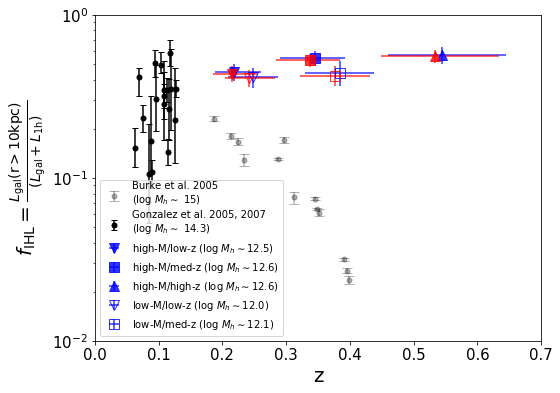

In [246]:
from run_fit import *

fig, ax = plt.subplots(1,1,figsize=(8,6))

# Burke
plt.errorbar(Burke_dict['z'], Burke_dict['f_ICL'], Burke_dict['f_ICL_err'],fmt='.',
             capsize=5, mfc=None, markersize=10, color='k', alpha=0.3, 
             label='Burke et al. 2005\n' + r'(log $M_h\sim$ 15)')

# Gonzalez
z_arr,Mh_arr,f_arr,f_low_arr, f_high_arr = [],[],[],[],[]
for name,arr in Gonzalez_dict.items():
    z_arr.append(arr[0])
    Mh_arr.append(10**arr[1])
    L_BCGICL_L_tot = arr[5]
    L_ICL_L_BCGICL = 10**(-(arr[10] - arr[7])/2.5)
    f_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] - arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]+arr[11]+arr[12]) - arr[7])/2.5)
    f_low_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] + arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]-arr[11]-arr[13]) - arr[7])/2.5)
    f_high_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)

f_arr,f_low_arr, f_high_arr = np.array(f_arr),np.array(f_low_arr), np.array(f_high_arr)
plt.errorbar(z_arr, f_arr, yerr=[f_arr - f_low_arr,f_high_arr - f_arr], 
                            fmt='.',capsize=3, mfc=None, markersize=10, color='k',
            label='Gonzalez et al. 2005, 2007\n'+r'(log $M_h\sim$ %.1f)'%(np.median(np.log10(Mh_arr))))


# # Illustris f_exsitu Rodriguez-Gomez
# data = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M11_med.txt', delimiter=',')
# data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M11_high.txt', delimiter=',')
# data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M11_low.txt', delimiter=',')
# plt.fill_between(np.arange(0,1,0.01),
#                  np.interp(np.arange(0,1,0.01),10**data_l[:,0]-1,10**data_l[:,1]),
#                  np.interp(np.arange(0,1,0.01),10**data_h[:,0]-1,10**data_h[:,1]),
#     facecolor='g', alpha=0.2, label='Rodriguez-Gomez et al. 2016\n'+\
#                  r'(log $M_*\sim$ 11)')

# data = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M12_med.txt', delimiter=',')
# data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M12_high.txt', delimiter=',')
# data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M12_low.txt', delimiter=',')
# plt.fill_between(np.arange(0,1,0.01),
#                  np.interp(np.arange(0,1,0.01),10**data_l[:,0]-1,10**data_l[:,1]),
#                  np.interp(np.arange(0,1,0.01),10**data_h[:,0]-1,10**data_h[:,1]),
#     facecolor='C5', alpha=0.2, label='Rodriguez-Gomez et al. 2016\n'+\
#                  r'(log $M_*\sim$ 12)')

r_arr = data_dict['rbins']
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    
    z = np.median(srcinfo[i]['z'])
    z_low = np.percentile(srcinfo[i]['z'], 16)
    z_high = np.percentile(srcinfo[i]['z'], 84)
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
   
    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        rkpc_arr = np.logspace(-1,3,100)
        sp = np.where((rkpc_arr > 10))[0]

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']
        
        fext = np.sum(p[sp]*rkpc_arr[sp]**2)/np.sum(p*rkpc_arr**2)
        fext_high = np.sum(p_low[sp]*rkpc_arr[sp]**2)/np.sum(p_low*rkpc_arr**2)
        fext_low = np.sum(p_high[sp]*rkpc_arr[sp]**2)/np.sum(p_high*rkpc_arr**2)
        
        Lgal = np.sum(data_dict[inst][i]['profgal_arr']*r_arr**2)
        Lgal_low = np.sum(data_dict[inst][i]['profgal_arr_low']*r_arr**2)
        Lgal_high = np.sum(data_dict[inst][i]['profgal_arr_high']*r_arr**2)
        L1h = np.sum(data_dict[inst][i]['prof1h']*r_arr**2)
        L1h_low = np.sum(data_dict[inst][i]['prof1h_low']*r_arr**2)
        L1h_high = np.sum(data_dict[inst][i]['prof1h_high']*r_arr**2)
        
        f = Lgal * fext / (Lgal)
        f_low = fext_low
        f_high = fext_high
        if f > f_high or f < f_low:
            f = (f_low + f_high) / 2

        if inst == 1:        
            ax.errorbar([z*1.01], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' (log $M_h\sim %.1f$)'%np.log10(Mh))
        else:
            ax.errorbar([z*0.99], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
            
ax.legend(fontsize=10, loc=3)#bbox_to_anchor=(1,1))
ax.set_ylim([0,1])
ax.set_yscale('log')
ax.set_ylim([1e-2,1e0])

ax.set_xlim([0,0.7])
ax.set_xlabel('z', fontsize=20)
ax.set_ylabel(r"$f_{\rm IHL} = \frac{L_{\rm gal} {\rm (r > 10 kpc)}}{(L_{\rm gal}+L_{\rm 1h})}$",
              fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# plt.savefig('plots/paperfig/fIHL_z.pdf',
#             dpi = 200, bbox_inches='tight')

## Color

In [249]:
from run_fit import *

data = {}
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    data[i] = {}
    
    profgal_arr1,profpsf_arr1,profgalint_arr1 = 0,0,0
    profgal_arr2,profpsf_arr2,profgalint_arr2 = 0,0,0
    profgal_arr1_low,profpsf_arr1_low,profgalint_arr1_low = 0,0,0
    profgal_arr2_low,profpsf_arr2_low,profgalint_arr2_low = 0,0,0
    profgal_arr1_high,profpsf_arr1_high,profgalint_arr1_high = 0,0,0
    profgal_arr2_high,profpsf_arr2_high,profgalint_arr2_high = 0,0,0

    savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
    for ifield in [4,5,6,7,8]:
        print(i, ifield)
        fitparamdat = get_mcmc_fit_params_3par(1,im, ifield=None,savename=savename)
        Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
        Re2_low, A1h_low, A2h_low \
        = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
        Re2_high, A1h_high, A2h_high \
        = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

        param_fit = fit_stacking_mcmc(1, ifield, im, m_min=m_min, m_max=m_max,
                                     Mabs_min=M_min, Mabs_max=M_max)

        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
        profgal_arr1 += modelprof['profgal']
        profpsf_arr1 += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr1 += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h, A2h=A2h)
        profgal_arr1_low += modelprof['profgal']
        profpsf_arr1_low += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2_low, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr1_low += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h, A2h=A2h)
        profgal_arr1_high += modelprof['profgal']
        profpsf_arr1_high += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2_high, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr1_high += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
        
        fitparamdat = get_mcmc_fit_params_3par(2,im, ifield=None,savename=savename)
        Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
        Re2_low, A1h_low, A2h_low \
        = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
        Re2_high, A1h_high, A2h_high \
        = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']
        param_fit = fit_stacking_mcmc(2, ifield, im, m_min=m_min, m_max=m_max,
                                     Mabs_min=M_min, Mabs_max=M_max)
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
        profgal_arr2 += modelprof['profgal']
        profpsf_arr2 += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr2 += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h, A2h=A2h)
        profgal_arr2_low += modelprof['profgal']
        profpsf_arr2_low += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2_low, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr2_low += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h, A2h=A2h)
        profgal_arr2_high += modelprof['profgal']
        profpsf_arr2_high += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2_high, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr2_high += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
    
    data[i]['profgal_arr1'] = profgal_arr1 / 5
    data[i]['profpsf_arr1'] = profpsf_arr1 / 5
    data[i]['profgalint_arr1'] = profgalint_arr1 / 5
    data[i]['profgal_arr2'] = profgal_arr2 / 5
    data[i]['profpsf_arr2'] = profpsf_arr2 / 5
    data[i]['profgalint_arr2'] = profgalint_arr2 / 5
    
    data[i]['profgal_arr1_high'] = profgal_arr1_high / 5
    data[i]['profpsf_arr1_high'] = profpsf_arr1_high / 5
    data[i]['profgalint_arr1_high'] = profgalint_arr1_high / 5
    data[i]['profgal_arr2_high'] = profgal_arr2_high / 5
    data[i]['profpsf_arr2_high'] = profpsf_arr2_high / 5
    data[i]['profgalint_arr2_high'] = profgalint_arr2_high / 5

    data[i]['profgal_arr1_low'] = profgal_arr1_low / 5
    data[i]['profpsf_arr1_low'] = profpsf_arr1_low / 5
    data[i]['profgalint_arr1_low'] = profgalint_arr1_low / 5
    data[i]['profgal_arr2_low'] = profgal_arr2_low / 5
    data[i]['profpsf_arr2_low'] = profpsf_arr2_low / 5
    data[i]['profgalint_arr2_low'] = profgalint_arr2_low / 5
    
    data[i]['profex1'] = data[i]['profgal_arr1']  - data[i]['profpsf_arr1']
    data[i]['profex2'] = data[i]['profgal_arr2']  - data[i]['profpsf_arr2']
    data[i]['profex1_low'] = data[i]['profgal_arr1_low']  - data[i]['profpsf_arr1_low']
    data[i]['profex2_low'] = data[i]['profgal_arr2_low']  - data[i]['profpsf_arr2_low']
    data[i]['profex1_high'] = data[i]['profgal_arr1_high']  - data[i]['profpsf_arr1_high']
    data[i]['profex2_high'] = data[i]['profgal_arr2_high']  - data[i]['profpsf_arr2_high']

data['rbins'] = param_fit.rbins
data['rbinedges'] = param_fit.rbinedges

clear_output()

In [250]:
weighted_avgc,weighted_varc,weighted_varhc,weighted_varlc = 0,0,0,0
weighted_avge,weighted_vare,weighted_varhe,weighted_varle = 0,0,0,0

rbins,rbinedges = data['rbins'], data['rbinedges']
drs = np.diff(rbinedges)

for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]

    for inst in [1,2]:
        Re2 = srcinfo[i]['Re2_'+str(inst)] 
        Re2_low =srcinfo[i]['Re2_low_'+str(inst)]
        Re2_high = srcinfo[i]['Re2_high_'+str(inst)]

        rkpc_arr = np.logspace(-1,3,100)
        sp = np.where((rkpc_arr > 10) )[0]

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2)
        p = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']

        galprofdat = gal_profile_model().Wang19_profile(rkpc_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']
        
        fext = np.sum(p[sp]*rkpc_arr[sp]**2)/np.sum(p*rkpc_arr**2)
        fext_high = np.sum(p_low[sp]*rkpc_arr[sp]**2)/np.sum(p_low*rkpc_arr**2)
        fext_low = np.sum(p_high[sp]*rkpc_arr[sp]**2)/np.sum(p_high*rkpc_arr**2)
        
        Ftot = np.sum(data[i]['profgal_arr'+str(inst)]*2*np.pi*rbins*drs)
        Ftot_low = np.sum(data[i]['profgal_arr'+str(inst)+'_low']*2*np.pi*rbins*drs)
        Ftot_high = np.sum(data[i]['profgal_arr'+str(inst)+'_high']*2*np.pi*rbins*drs)

        Fext = Ftot * fext
        Fgal = Ftot - Fext
        Fext_low = Ftot_low * fext_low
        Fgal_low = Ftot_low - Fext_low
        Fext_high = Ftot_high * fext_high
        Fgal_high = Ftot_high - Fext_high
        
        if inst == 1:
            Fgal1 = Fgal * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_gal1 = -2.5 * np.log10(Fgal1.to(u.Jy).value / 3631)
            Fext1 = Fext * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_ext1 = -2.5 * np.log10(Fext1.to(u.Jy).value / 3631)
            Fgal1_low = Fgal_low * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_gal1_low = -2.5 * np.log10(Fgal1_low.to(u.Jy).value / 3631)
            Fext1_low = Fext_low * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_ext1_low = -2.5 * np.log10(Fext1_low.to(u.Jy).value / 3631)
            Fgal1_high = Fgal_high * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_gal1_high = -2.5 * np.log10(Fgal1_high.to(u.Jy).value / 3631)
            Fext1_high = Fext_high * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_ext1_high = -2.5 * np.log10(Fext1_high.to(u.Jy).value / 3631)

        if inst == 2:
            Fgal2 = Fgal * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_gal2 = -2.5 * np.log10(Fgal2.to(u.Jy).value / 3631)
            Fext2 = Fext * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_ext2 = -2.5 * np.log10(Fext2.to(u.Jy).value / 3631)
            Fgal2_low = Fgal_low * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_gal2_low = -2.5 * np.log10(Fgal2_low.to(u.Jy).value / 3631)
            Fext2_low = Fext_low * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_ext2_low = -2.5 * np.log10(Fext2_low.to(u.Jy).value / 3631)
            Fgal2_high = Fgal_high * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_gal2_high = -2.5 * np.log10(Fgal2_high.to(u.Jy).value / 3631)
            Fext2_high = Fext_high * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
            m_ext2_high = -2.5 * np.log10(Fext2_high.to(u.Jy).value / 3631)

    dm_psf = m_gal1 - m_gal2 - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_psf_low = m_gal1_high - m_gal2_low - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_psf_high = m_gal1_low - m_gal2_high - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_ex = m_ext1 - m_ext2 - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_ex_high = m_ext1_high - m_ext2_low - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_ex_low = m_ext1_low - m_ext2_high - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    print('bin #%d, CorePSF (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'\
          %(i,dm_psf, dm_psf_high-dm_psf,  dm_psf-dm_psf_low))
    print('bin #%d, Ext_IHL (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'\
          %(i,dm_ex, dm_ex_high-dm_ex,  dm_ex-dm_ex_low))

    fc, fc_low, fc_high = dm_psf, dm_psf_high, dm_psf_low
    fe, fe_low, fe_high = dm_ex, dm_ex_high, dm_ex_low
    sigc = (fc_high - fc_low) / 2
    sige = (fe_high - fe_low) / 2
    weighted_avgc += fc / sigc**2
    weighted_varc += 1 / sigc**2
    weighted_avge += fe / sige**2
    weighted_vare += 1 / sige**2
    weighted_varhc += 1 / (fc_high-fc)**2
    weighted_varlc += 1 / (fc-fc_low)**2
    weighted_varhe += 1 / (fe_high-fe)**2
    weighted_varle += 1 / (fe-fe_low)**2
weighted_avgc /= weighted_varc
weighted_varc = np.sqrt(1 / weighted_varc)

weighted_varhc = np.sqrt(1 / weighted_varhc)
weighted_varlc = np.sqrt(1 / weighted_varlc)

weighted_avge /= weighted_vare
weighted_vare = np.sqrt(1 / weighted_vare)

weighted_varhe = np.sqrt(1 / weighted_varhe)
weighted_varle = np.sqrt(1 / weighted_varle)

print('CorePSF (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'%(weighted_avgc, weighted_varhc, weighted_varlc))
print('Ext_IHL (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'%(weighted_avge, weighted_varhe, weighted_varle))
print('extension is bluer at %.2f sigma significance'\
      %((weighted_avgc-weighted_avge)**2/(weighted_varlc**2+weighted_varhe**2)))

dm_ihl = -2.5*np.log10((7.0)/(11.4)) - 2.5 * np.log10(1.12/1.56)
dm_ihl_low = -2.5*np.log10((7.0+4.0)/(11.4-4.8)) - 2.5 * np.log10(1.12/1.56)
dm_ihl_high = -2.5*np.log10((7.0-3.5)/(11.4+5.4)) - 2.5 * np.log10(1.12/1.56)

dm_igl = -2.5*np.log10((9.7)/(9.0)) - 2.5 * np.log10(1.12/1.56)
dm_igl_low = -2.5*np.log10((9.7+3.0)/(9.0-1.7)) - 2.5 * np.log10(1.12/1.56)
dm_igl_high = -2.5*np.log10((9.7-1.9)/(9.0+2.6)) - 2.5 * np.log10(1.12/1.56)

print('IHL (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'\
      %(dm_ihl, dm_ihl_high-dm_ihl, dm_ihl-dm_ihl_low))
print('IGL (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'\
      %(dm_igl, dm_igl_high-dm_igl, dm_igl-dm_igl_low))

bin #0, CorePSF (m_1.1 - m_1.6) = 0.43 + 0.27 - 0.25
bin #0, Ext_IHL (m_1.1 - m_1.6) = 0.38 + 0.19 - 0.16
bin #1, CorePSF (m_1.1 - m_1.6) = 0.56 + 0.33 - 0.36
bin #1, Ext_IHL (m_1.1 - m_1.6) = 0.48 + 0.10 - 0.12
bin #2, CorePSF (m_1.1 - m_1.6) = 0.65 + 0.40 - 0.38
bin #2, Ext_IHL (m_1.1 - m_1.6) = 0.62 + 0.15 - 0.11
bin #3, CorePSF (m_1.1 - m_1.6) = 0.40 + 0.28 - 0.26
bin #3, Ext_IHL (m_1.1 - m_1.6) = 0.38 + 0.24 - 0.20
bin #4, CorePSF (m_1.1 - m_1.6) = 0.58 + 0.33 - 0.34
bin #4, Ext_IHL (m_1.1 - m_1.6) = 0.47 + 0.28 - 0.24
CorePSF (m_1.1 - m_1.6) = 0.50 + 0.14 - 0.14
Ext_IHL (m_1.1 - m_1.6) = 0.49 + 0.06 - 0.07
extension is bluer at 0.00 sigma significance
IHL (m_1.1 - m_1.6) = 0.89 + 1.17 - 1.08
IGL (m_1.1 - m_1.6) = 0.28 + 0.51 - 0.52


***

In [ ]:
# from run_fit import *

fig, ax = plt.subplots(1,1,figsize=(8,6))

# Purcell
data = np.loadtxt('Illustris_frac/Purcell08_med.txt', delimiter=',')
data_h = np.loadtxt('Illustris_frac/Purcell08_68high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_68low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='g', alpha=0.15, label=r'Purcell et al. 2007, 2008 ($z=0$)')
data_h = np.loadtxt('Illustris_frac/Purcell08_95high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_95low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='g', alpha=0.1)

# MW, M31
plt.errorbar([1e12], [0.02], xerr=[1e12*0.1], yerr=[0],
             lw=3, color='C4', label='MW')
plt.errorbar([1.3e12], [0.04], xerr=[1.3e12*0.1], yerr=[0],
             lw=3, color='C5', label='M31')
plt.arrow(1e12, 0.02, 0, -0.02*0.4, width=0.5e11, length_includes_head=True, color='C4', 
         head_width=1.5e11, head_length=0.02*0.2, overhang=0)
plt.arrow(1.3e12, 0.04, 0, -0.04*0.4, width=0.5e11*1.3, length_includes_head=True, color='C5', 
         head_width=1.5e11*1.3, head_length=0.04*0.2, overhang=0)
 
# Gonzalez
Mh_arr,f_arr,f_low_arr, f_high_arr,z_arr = [],[],[],[],[]
for name,arr in Gonzalez_dict.items():
    z_arr.append(arr[0])
    Mh_arr.append(10**arr[1])
    L_BCGICL_L_tot = arr[5]
    L_ICL_L_BCGICL = 10**(-(arr[10] - arr[7])/2.5)
    f_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] - arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]+arr[11]+arr[12]) - arr[7])/2.5)
    f_low_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] + arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]-arr[11]-arr[13]) - arr[7])/2.5)
    f_high_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)

f_arr,f_low_arr, f_high_arr = np.array(f_arr),np.array(f_low_arr), np.array(f_high_arr)
plt.errorbar(Mh_arr, f_arr, yerr=[f_arr - f_low_arr,f_high_arr - f_arr], 
                            fmt='.',capsize=3, mfc=None, markersize=10, color='k',
            label='Gonzalez et al. 2005, 2007 '+r'($z\sim %.2f$)'%(np.median(z_arr)))
# Burke
plt.errorbar(Burke_dict['M200'], Burke_dict['f_ICL'], yerr=Burke_dict['f_ICL_err'], 
                fmt='.',capsize=3, mfc=None, markersize=10, color='k', alpha=0.3,
             label='Burke et al. 2015 '+r'($z\sim %.2f$)'%(np.median(Burke_dict['z'])))


r_arr = data_dict['rbins']
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
    Mh_low = 10**np.percentile(srcinfo[i]['logMh'], 16)
    Mh_high = 10**np.percentile(srcinfo[i]['logMh'], 84)

    for inst in [1,2]:
        Ltot = np.sum((data_dict[inst][i]['profgal_arr']+data_dict[inst][i]['prof1h'])*r_arr**2)
        Lihl =  np.sum(data_dict[inst][i]['profex']*r_arr**2)
        Ltot_low = np.sum((data_dict[inst][i]['profgal_arr_low']+\
                           data_dict[inst][i]['prof1h_high'])*r_arr**2)
        Lihl_low =  np.sum(data_dict[inst][i]['profex_low']*r_arr**2)
        Ltot_high = np.sum((data_dict[inst][i]['profgal_arr_high']+\
                            data_dict[inst][i]['prof1h_low'])*r_arr**2)
        Lihl_high =  np.sum(data_dict[inst][i]['profex_high']*r_arr**2)
        f = Lihl/Ltot
        f_low = Lihl_low/Ltot_low
        f_high = Lihl_high/Ltot_high

        if inst == 1:
            
            ax.errorbar([Mh*1.01], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' ($z\sim %.2f$)'%np.median(srcinfo[i]['z']))
        else:
            ax.errorbar([Mh*0.99], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')

ax.legend(fontsize=8, bbox_to_anchor=(0.65,0.43))
ax.set_ylim([1e-2,1])
ax.set_xlim([3e11,2e15])
ax.set_xscale('log')
ax.set_yscale('log')
# ax.grid()
ax.set_xlabel('log (M$_h$ / M$_\odot$)', fontsize=20)
ax.set_ylabel(r"$f_{\rm IHL} = \frac{L_{\rm ext}}{(L_{\rm core}+L_{\rm ext}+L_{\rm 1h})}$",
              fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks([1e12, 1e13, 1e14, 1e15])
ax.set_xticklabels(['12','13','14','15'])

plt.savefig('plots/paperfig/fIHL.pdf',
            dpi = 200, bbox_inches='tight')

In [ ]:
# from run_fit import *

fig, ax = plt.subplots(1,1,figsize=(8,6))

# Purcell
data = np.loadtxt('Illustris_frac/Purcell08_med.txt', delimiter=',')
data_h = np.loadtxt('Illustris_frac/Purcell08_68high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_68low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='g', alpha=0.15, label=r'Purcell et al. 2007, 2008 ($z=0$)')
data_h = np.loadtxt('Illustris_frac/Purcell08_95high.txt', delimiter=',')
data_l = np.loadtxt('Illustris_frac/Purcell08_95low.txt', delimiter=',')
plt.fill_between(10**data[:,0],
                 10**np.interp(data[:,0],data_l[:,0],data_l[:,1]),
                 10**np.interp(data[:,0],data_h[:,0],data_h[:,1]),
                         facecolor='g', alpha=0.1)

# MW, M31
plt.errorbar([1e12], [0.02], xerr=[1e12*0.1], yerr=[0],
             lw=3, color='C4', label='MW')
plt.errorbar([1.3e12], [0.04], xerr=[1.3e12*0.1], yerr=[0],
             lw=3, color='C5', label='M31')
plt.arrow(1e12, 0.02, 0, -0.02*0.4, width=0.5e11, length_includes_head=True, color='C4', 
         head_width=1.5e11, head_length=0.02*0.2, overhang=0)
plt.arrow(1.3e12, 0.04, 0, -0.04*0.4, width=0.5e11*1.3, length_includes_head=True, color='C5', 
         head_width=1.5e11*1.3, head_length=0.04*0.2, overhang=0)
 
# Gonzalez
Mh_arr,f_arr,f_low_arr, f_high_arr,z_arr = [],[],[],[],[]
for name,arr in Gonzalez_dict.items():
    z_arr.append(arr[0])
    Mh_arr.append(10**arr[1])
    L_BCGICL_L_tot = arr[5]
    L_ICL_L_BCGICL = 10**(-(arr[10] - arr[7])/2.5)
    f_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] - arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]+arr[11]+arr[12]) - arr[7])/2.5)
    f_low_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] + arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]-arr[11]-arr[13]) - arr[7])/2.5)
    f_high_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)

f_arr,f_low_arr, f_high_arr = np.array(f_arr),np.array(f_low_arr), np.array(f_high_arr)
plt.errorbar(Mh_arr, f_arr, yerr=[f_arr - f_low_arr,f_high_arr - f_arr], 
                            fmt='.',capsize=3, mfc=None, markersize=10, color='k',
            label='Gonzalez et al. 2005, 2007 '+r'($z\sim %.2f$)'%(np.median(z_arr)))
# Burke
plt.errorbar(Burke_dict['M200'], Burke_dict['f_ICL'], yerr=Burke_dict['f_ICL_err'], 
                fmt='.',capsize=3, mfc=None, markersize=10, color='k', alpha=0.3,
             label='Burke et al. 2015 '+r'($z\sim %.2f$)'%(np.median(Burke_dict['z'])))


r_arr = data_dict['rbins']
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
    Mh_low = 10**np.percentile(srcinfo[i]['logMh'], 16)
    Mh_high = 10**np.percentile(srcinfo[i]['logMh'], 84)

    for inst in [1,2]:
        L1h = np.sum((data_dict[inst][i]['prof1h'])*r_arr**2)
        Lgal = np.sum((data_dict[inst][i]['profgal_arr'])*r_arr**2)
        Lext = np.sum((data_dict[inst][i]['profex'])*r_arr**2)
        Lcore = Lgal - Lext
        Ltot = Lcore + Lext + L1h
        print(inst, i, Lcore/Ltot, Lext/Ltot, L1h/Ltot)
        Ltot = np.sum((data_dict[inst][i]['profgal_arr']+data_dict[inst][i]['prof1h'])*r_arr**2)
        Lihl =  np.sum(data_dict[inst][i]['profex']*r_arr**2)
        Ltot_low = np.sum((data_dict[inst][i]['profgal_arr_low']+\
                           data_dict[inst][i]['prof1h_high'])*r_arr**2)
        Lihl_low =  np.sum(data_dict[inst][i]['profex_low']*r_arr**2)
        Ltot_high = np.sum((data_dict[inst][i]['profgal_arr_high']+\
                            data_dict[inst][i]['prof1h_low'])*r_arr**2)
        Lihl_high =  np.sum(data_dict[inst][i]['profex_high']*r_arr**2)
        f = Lihl/Ltot
        f_low = Lihl_low/Ltot_low
        f_high = Lihl_high/Ltot_high

        if inst == 1:
            
            ax.errorbar([Mh*1.01], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' ($z\sim %.2f$)'%np.median(srcinfo[i]['z']))
        else:
            ax.errorbar([Mh*0.99], [f], xerr=[[Mh-Mh_low],[Mh_high-Mh]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')

            
ax.legend(fontsize=8, bbox_to_anchor=(0.65,0.43))
ax.set_ylim([1e-2,1])
ax.set_xlim([3e11,2e15])
ax.set_xscale('log')
ax.set_yscale('log')
# ax.grid()
ax.set_xlabel('log (M$_h$ / M$_\odot$)', fontsize=20)
ax.set_ylabel(r"$f_{\rm IHL} = \frac{L_{\rm ext}}{(L_{\rm core}+L_{\rm ext}+L_{\rm 1h})}$",
              fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

In [ ]:
from run_fit import *

fig, ax = plt.subplots(1,1,figsize=(8,6))

# Burke
plt.errorbar(Burke_dict['z'], Burke_dict['f_ICL'], Burke_dict['f_ICL_err'],fmt='.',
             capsize=5, mfc=None, markersize=10, color='k', alpha=0.3, 
             label='Burke et al. 2005\n' + r'(log $M_h\sim$ 15)')

# Gonzalez
z_arr,Mh_arr,f_arr,f_low_arr, f_high_arr = [],[],[],[],[]
for name,arr in Gonzalez_dict.items():
    z_arr.append(arr[0])
    Mh_arr.append(10**arr[1])
    L_BCGICL_L_tot = arr[5]
    L_ICL_L_BCGICL = 10**(-(arr[10] - arr[7])/2.5)
    f_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] - arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]+arr[11]+arr[12]) - arr[7])/2.5)
    f_low_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)
    
    L_BCGICL_L_tot = arr[5] + arr[6]
    L_ICL_L_BCGICL = 10**(-((arr[10]-arr[11]-arr[13]) - arr[7])/2.5)
    f_high_arr.append(L_BCGICL_L_tot*L_ICL_L_BCGICL)

f_arr,f_low_arr, f_high_arr = np.array(f_arr),np.array(f_low_arr), np.array(f_high_arr)
plt.errorbar(z_arr, f_arr, yerr=[f_arr - f_low_arr,f_high_arr - f_arr], 
                            fmt='.',capsize=3, mfc=None, markersize=10, color='k',
            label='Gonzalez et al. 2005, 2007\n'+r'(log $M_h\sim$ %.1f)'%(np.median(np.log10(Mh_arr))))


# # Illustris f_exsitu Rodriguez-Gomez
# data = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M11_med.txt', delimiter=',')
# data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M11_high.txt', delimiter=',')
# data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M11_low.txt', delimiter=',')
# plt.fill_between(np.arange(0,1,0.01),
#                  np.interp(np.arange(0,1,0.01),10**data_l[:,0]-1,10**data_l[:,1]),
#                  np.interp(np.arange(0,1,0.01),10**data_h[:,0]-1,10**data_h[:,1]),
#     facecolor='g', alpha=0.2, label='Rodriguez-Gomez et al. 2016\n'+\
#                  r'(log $M_*\sim$ 11)')

# data = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M12_med.txt', delimiter=',')
# data_h = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M12_high.txt', delimiter=',')
# data_l = np.loadtxt('Illustris_frac/Illustris_fexsitu_z_M12_low.txt', delimiter=',')
# plt.fill_between(np.arange(0,1,0.01),
#                  np.interp(np.arange(0,1,0.01),10**data_l[:,0]-1,10**data_l[:,1]),
#                  np.interp(np.arange(0,1,0.01),10**data_h[:,0]-1,10**data_h[:,1]),
#     facecolor='C5', alpha=0.2, label='Rodriguez-Gomez et al. 2016\n'+\
#                  r'(log $M_*\sim$ 12)')

r_arr = data_dict['rbins']
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    
    z = np.median(srcinfo[i]['z'])
    z_low = np.percentile(srcinfo[i]['z'], 16)
    z_high = np.percentile(srcinfo[i]['z'], 84)
    
    Mh = 10**np.median(srcinfo[i]['logMh'])
   
    for inst in [1,2]:
        Ltot = np.sum((data_dict[inst][i]['profgal_arr']+data_dict[inst][i]['prof1h'])*r_arr**2)
        Lihl =  np.sum(data_dict[inst][i]['profex']*r_arr**2)
        Ltot_low = np.sum((data_dict[inst][i]['profgal_arr_low']+\
                           data_dict[inst][i]['prof1h_high'])*r_arr**2)
        Lihl_low =  np.sum(data_dict[inst][i]['profex_low']*r_arr**2)
        Ltot_high = np.sum((data_dict[inst][i]['profgal_arr_high']+\
                            data_dict[inst][i]['prof1h_low'])*r_arr**2)
        Lihl_high =  np.sum(data_dict[inst][i]['profex_high']*r_arr**2)
        f = Lihl/Ltot
        f_low = Lihl_low/Ltot_low
        f_high = Lihl_high/Ltot_high

        if inst == 1:
            
            ax.errorbar([z*1.01], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                            fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='b', 
                        label = name + r' (log $M_h\sim %.1f$)'%np.log10(Mh))
        else:
            ax.errorbar([z*0.99], [f], xerr=[[z-z_low],[z_high-z]],
                           yerr=[[f - f_low],[f_high - f]], alpha=0.8,
                    fmt=fmt,capsize=0, mfc=mfc, markersize=10, c='r')
            
ax.legend(fontsize=10, loc=1)#bbox_to_anchor=(1,1))
ax.set_ylim([0,1])
ax.set_yscale('log')
ax.set_ylim([1e-2,1e0])

ax.set_xlim([0,0.7])
ax.set_xlabel('z', fontsize=20)
ax.set_ylabel(r"$f_{\rm IHL} = \frac{L_{\rm ext}}{(L_{\rm core}+L_{\rm ext}+L_{\rm 1h})}$",
              fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.savefig('plots/paperfig/fIHL_z.pdf',
            dpi = 200, bbox_inches='tight')

## Core vs Extended Color

In [ ]:
from run_fit import *

data = {}
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    data[i] = {}
    
    profgal_arr1,profpsf_arr1,profgalint_arr1 = 0,0,0
    profgal_arr2,profpsf_arr2,profgalint_arr2 = 0,0,0
    profgal_arr1_low,profpsf_arr1_low,profgalint_arr1_low = 0,0,0
    profgal_arr2_low,profpsf_arr2_low,profgalint_arr2_low = 0,0,0
    profgal_arr1_high,profpsf_arr1_high,profgalint_arr1_high = 0,0,0
    profgal_arr2_high,profpsf_arr2_high,profgalint_arr2_high = 0,0,0

    savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
    for ifield in [4,5,6,7,8]:
        print(i, ifield)
        fitparamdat = get_mcmc_fit_params_3par(1,im, ifield=None,savename=savename)
        Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
        Re2_low, A1h_low, A2h_low \
        = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
        Re2_high, A1h_high, A2h_high \
        = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

        param_fit = fit_stacking_mcmc(1, ifield, im, m_min=m_min, m_max=m_max,
                                     Mabs_min=M_min, Mabs_max=M_max)

        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
        profgal_arr1 += modelprof['profgal']
        profpsf_arr1 += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr1 += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h, A2h=A2h)
        profgal_arr1_low += modelprof['profgal']
        profpsf_arr1_low += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2_low, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr1_low += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h, A2h=A2h)
        profgal_arr1_high += modelprof['profgal']
        profpsf_arr1_high += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2_high, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr1_high += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
        
        fitparamdat = get_mcmc_fit_params_3par(2,im, ifield=None,savename=savename)
        Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
        Re2_low, A1h_low, A2h_low \
        = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
        Re2_high, A1h_high, A2h_high \
        = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']
        param_fit = fit_stacking_mcmc(2, ifield, im, m_min=m_min, m_max=m_max,
                                     Mabs_min=M_min, Mabs_max=M_max)
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
        profgal_arr2 += modelprof['profgal']
        profpsf_arr2 += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr2 += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int

        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h, A2h=A2h)
        profgal_arr2_low += modelprof['profgal']
        profpsf_arr2_low += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2_low, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr2_low += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h, A2h=A2h)
        profgal_arr2_high += modelprof['profgal']
        profpsf_arr2_high += modelprof['profpsf']
        norm_int = param_fit.get_gal_profile_norm(Re2=Re2_high, A1h=A1h, A2h=A2h)
        profint = gal_profile_model().Wang19_profile(param_fit.rbins, im, Re2=Re2, A1h=A1h, A2h=A2h)
        profgalint_arr2_high += profint['I_arr']/profint['I_arr'][0] * modelprof['normg'] * norm_int
        
    
    data[i]['profgal_arr1'] = profgal_arr1 / 5
    data[i]['profpsf_arr1'] = profpsf_arr1 / 5
    data[i]['profgalint_arr1'] = profgalint_arr1 / 5
    data[i]['profgal_arr2'] = profgal_arr2 / 5
    data[i]['profpsf_arr2'] = profpsf_arr2 / 5
    data[i]['profgalint_arr2'] = profgalint_arr2 / 5
    
    data[i]['profgal_arr1_high'] = profgal_arr1_high / 5
    data[i]['profpsf_arr1_high'] = profpsf_arr1_high / 5
    data[i]['profgalint_arr1_high'] = profgalint_arr1_high / 5
    data[i]['profgal_arr2_high'] = profgal_arr2_high / 5
    data[i]['profpsf_arr2_high'] = profpsf_arr2_high / 5
    data[i]['profgalint_arr2_high'] = profgalint_arr2_high / 5

    data[i]['profgal_arr1_low'] = profgal_arr1_low / 5
    data[i]['profpsf_arr1_low'] = profpsf_arr1_low / 5
    data[i]['profgalint_arr1_low'] = profgalint_arr1_low / 5
    data[i]['profgal_arr2_low'] = profgal_arr2_low / 5
    data[i]['profpsf_arr2_low'] = profpsf_arr2_low / 5
    data[i]['profgalint_arr2_low'] = profgalint_arr2_low / 5
    
    data[i]['profex1'] = data[i]['profgal_arr1']  - data[i]['profpsf_arr1']
    data[i]['profex2'] = data[i]['profgal_arr2']  - data[i]['profpsf_arr2']
    data[i]['profex1_low'] = data[i]['profgal_arr1_low']  - data[i]['profpsf_arr1_low']
    data[i]['profex2_low'] = data[i]['profgal_arr2_low']  - data[i]['profpsf_arr2_low']
    data[i]['profex1_high'] = data[i]['profgal_arr1_high']  - data[i]['profpsf_arr1_high']
    data[i]['profex2_high'] = data[i]['profgal_arr2_high']  - data[i]['profpsf_arr2_high']

data['rbins'] = param_fit.rbins
data['rbinedges'] = param_fit.rbinedges

clear_output()

In [ ]:
weighted_avgc,weighted_varc,weighted_varhc,weighted_varlc = 0,0,0,0
weighted_avge,weighted_vare,weighted_varhe,weighted_varle = 0,0,0,0

for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    
    SNRnorm1, SNRnorm2 = 0, 0
    for ifield in [4,5,6,7,8]:
        stackdat = stacking(1, ifield, m_min=m_min, m_max=m_max, Mabs_min=M_min, Mabs_max=M_max,
                        load_from_file=True).stackdat
        SNRnorm1 += stackdat['profcb'][0]/np.sqrt(stackdat['cov']['profcb'][0][0])
        stackdat = stacking(2, ifield, m_min=m_min, m_max=m_max, Mabs_min=M_min, Mabs_max=M_max,
                        load_from_file=True).stackdat
        SNRnorm2 += stackdat['profcb'][0]/np.sqrt(stackdat['cov']['profcb'][0][0])
    
    SNRnorm1 /= 5
    SNRnorm2 /= 5

    rbins,rbinedges = data['rbins'], data['rbinedges']
    drs = np.diff(rbinedges)
    
    Fpsf1 = np.sum(data[i]['profpsf_arr1']*2*np.pi*rbins*drs)
    Fpsf1 = Fpsf1 * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_psf1 = -2.5 * np.log10(Fpsf1.to(u.Jy).value / 3631)
    Fpsf2 = np.sum(data[i]['profpsf_arr2']*2*np.pi*rbins*drs)
    Fpsf2 = Fpsf2 * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_psf2 = -2.5 * np.log10(Fpsf2.to(u.Jy).value / 3631)

    Fpsf1_low = Fpsf1 * (1-1/SNRnorm1)
    m_psf1_low = -2.5 * np.log10(Fpsf1_low.to(u.Jy).value / 3631)
    Fpsf2_low = Fpsf2 * (1-1/SNRnorm2)
    m_psf2_low = -2.5 * np.log10(Fpsf2_low.to(u.Jy).value / 3631)

    Fpsf1_high = Fpsf1 * (1+1/SNRnorm1)
    m_psf1_high = -2.5 * np.log10(Fpsf1_high.to(u.Jy).value / 3631)
    Fpsf2_high = Fpsf2 * (1+1/SNRnorm2)
    m_psf2_high = -2.5 * np.log10(Fpsf2_high.to(u.Jy).value / 3631)

    Fgal1 = np.sum(data[i]['profgal_arr1']*2*np.pi*rbins*drs)
    Fgal1 = Fgal1 * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal1 = -2.5 * np.log10(Fgal1.to(u.Jy).value / 3631)
    Fgal2 = np.sum(data[i]['profgal_arr2']*2*np.pi*rbins*drs)
    Fgal2 = Fgal2 * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal2 = -2.5 * np.log10(Fgal2.to(u.Jy).value / 3631)

    Fgal1_low = np.sum(data[i]['profgal_arr1_low']*2*np.pi*rbins*drs)
    Fgal1_low = Fgal1_low * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal1_low = -2.5 * np.log10(Fgal1_low.to(u.Jy).value / 3631)
    Fgal2_low = np.sum(data[i]['profgal_arr2_low']*2*np.pi*rbins*drs)
    Fgal2_low = Fgal2_low * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal2_low = -2.5 * np.log10(Fgal2_low.to(u.Jy).value / 3631)

    Fgal1_high = np.sum(data[i]['profgal_arr1_high']*2*np.pi*rbins*drs)
    Fgal1_high = Fgal1_high * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal1_high = -2.5 * np.log10(Fgal1_high.to(u.Jy).value / 3631)
    Fgal2_high = np.sum(data[i]['profgal_arr2_high']*2*np.pi*rbins*drs)
    Fgal2_high = Fgal2_high * (u.nW*u.arcsec**2/u.m**2/u.sr)/ (band_info(1).nu * u.GHz)
    m_gal2_high = -2.5 * np.log10(Fgal2_high.to(u.Jy).value / 3631)

    m_ex1 = -2.5 * np.log10((Fgal1-Fpsf1).to(u.Jy).value / 3631)
    m_ex2 = -2.5 * np.log10((Fgal2-Fpsf2).to(u.Jy).value / 3631)
    m_ex1_high = -2.5 * np.log10((Fgal1_low-Fpsf1).to(u.Jy).value / 3631)
    m_ex2_high = -2.5 * np.log10((Fgal2_low-Fpsf2).to(u.Jy).value / 3631)
    m_ex1_low = -2.5 * np.log10((Fgal1_high-Fpsf1).to(u.Jy).value / 3631)
    m_ex2_low = -2.5 * np.log10((Fgal2_high-Fpsf2).to(u.Jy).value / 3631)
    
    dm_psf = m_psf1 - m_psf2 - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_psf_low = m_psf1_high - m_psf2_low - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_psf_high = m_psf1_low - m_psf2_high - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_ex = m_ex1 - m_ex2 - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_ex_high = m_ex1_high - m_ex2_low - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    dm_ex_low = m_ex1_low - m_ex2_high - 2.5 * np.log10(band_info(1).wl/band_info(2).wl)
    
    print('bin #%d, CorePSF (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'\
          %(i,dm_psf, dm_psf_high-dm_psf,  dm_psf-dm_psf_low))
    print('bin #%d, Ext_IHL (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'\
          %(i,dm_ex, dm_ex_high-dm_ex,  dm_ex-dm_ex_low))

    fc, fc_low, fc_high = dm_psf, dm_psf_high, dm_psf_low
    fe, fe_low, fe_high = dm_ex, dm_ex_high, dm_ex_low
    sigc = (fc_high - fc_low) / 2
    sige = (fe_high - fe_low) / 2
    weighted_avgc += fc / sigc**2
    weighted_varc += 1 / sigc**2
    weighted_avge += fe / sige**2
    weighted_vare += 1 / sige**2
    weighted_varhc += 1 / (fc_high-fc)**2
    weighted_varlc += 1 / (fc-fc_low)**2
    weighted_varhe += 1 / (fe_high-fe)**2
    weighted_varle += 1 / (fe-fe_low)**2
weighted_avgc /= weighted_varc
weighted_varc = np.sqrt(1 / weighted_varc)

weighted_varhc = np.sqrt(1 / weighted_varhc)
weighted_varlc = np.sqrt(1 / weighted_varlc)

weighted_avge /= weighted_vare
weighted_vare = np.sqrt(1 / weighted_vare)

weighted_varhe = np.sqrt(1 / weighted_varhe)
weighted_varle = np.sqrt(1 / weighted_varle)

print('CorePSF (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'%(weighted_avgc, weighted_varhc, weighted_varlc))
print('Ext_IHL (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'%(weighted_avge, weighted_varhe, weighted_varle))
print('extension is bluer at %.2f sigma significance'\
      %((weighted_avgc-weighted_avge)**2/(weighted_varlc**2+weighted_varhe**2)))
dm_ihl = -2.5*np.log10((7.0)/(11.4)) - 2.5 * np.log10(1.12/1.56)
dm_ihl_low = -2.5*np.log10((7.0+4.0)/(11.4-4.8)) - 2.5 * np.log10(1.12/1.56)
dm_ihl_high = -2.5*np.log10((7.0-3.5)/(11.4+5.4)) - 2.5 * np.log10(1.12/1.56)

dm_igl = -2.5*np.log10((9.7)/(9.0)) - 2.5 * np.log10(1.12/1.56)
dm_igl_low = -2.5*np.log10((9.7+3.0)/(9.0-1.7)) - 2.5 * np.log10(1.12/1.56)
dm_igl_high = -2.5*np.log10((9.7-1.9)/(9.0+2.6)) - 2.5 * np.log10(1.12/1.56)

print('IHL (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'\
      %(dm_ihl, dm_ihl_high-dm_ihl, dm_ihl-dm_ihl_low))
print('IGL (m_1.1 - m_1.6) = %.2f + %.2f - %.2f'\
      %(dm_igl, dm_igl_high-dm_ex, dm_igl-dm_ex_low))

In [ ]:
# GISSEL (from lePHARE library)
z = 0.3
seddir = mypaths['ciberdir'] + 'lephare/lephare_dev/sed/GAL/42GISSEL/'
sednames = ['E_03_0.0_0.4zo.sed','E_03_0.0_zo.sed','E_07_0.0_0.4zo.sed',
            'E_07_0.0_zo.sed','E_12_0.0_0.4zo.sed','E_12_0.0_zo.sed']

filtdir = mypaths['ciberdir']  + 'lephare/lephare_dev/filt/'

cs = []
for band in ['I','H']:
    d = np.loadtxt(filtdir + 'ciber/' + band + '.pb',skiprows=1)
    wl_filt, filt = d[:,0]/1e4,d[:,1]
    wl_filt_avg = np.sum(wl_filt * filt) / np.sum(filt)
    plt.plot(wl_filt, filt, label='CIBER '+band)
    if band == 'I':
        wl_filt1, filt1, wl_filt_avg1 = wl_filt, filt, wl_filt_avg
    else:
        wl_filt2, filt2, wl_filt_avg2 = wl_filt, filt, wl_filt_avg

for sedname in sednames: 
    d = np.loadtxt(seddir+sedname)
    wl_r,f_lambda = d[:,0]/1e4, d[:,1]
    fnu = f_lambda * wl**2
    wl = wl_r * (1+z)
    wl_idx_norm = np.argmin(np.abs(wl-wl_filt_avg2))
    fnu /= fnu[wl_idx_norm]
    plt.plot(wl, fnu)

    fnuinterp = np.interp(wl_filt1, wl, fnu)
    fnu_filt1 = np.sum(fnuinterp * wl_filt1)/np.sum(wl_filt1)
    plt.plot([wl_filt_avg1], [fnu_filt1],'o')

    fnuinterp = np.interp(wl_filt2, wl, fnu)
    fnu_filt2 = np.sum(fnuinterp * wl_filt2)/np.sum(wl_filt2)
    plt.plot([wl_filt_avg2], [fnu_filt2],'o')
    
    c = -2.5 * np.log10(fnu_filt1/fnu_filt2)
    cs.append(c)
    print(c)
print(np.mean(cs), np.std(cs))

# plt.xlim([0.5,2.5])
# plt.ylim([0,2])

In [ ]:
# IGL from MICECAT

from micecat import *
# dfmc = get_micecat_df(0, add_Rvir=True, return_full=True)
weighted_avg, weighted_var = 0,0
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    dfi = dfmc.loc[(df['I']>=m_min) & (dfmc['I']<m_max) & (dfmc['M_I']>=M_min) & (dfmc['M_I']<M_max)]
    c = dfi['M_I'] - dfi['M_H']
    c_avg, c_std = np.mean(c),np.std(c)
    print(c_avg, c_std)
    weighted_avg += c_avg / c_std**2
    weighted_var += 1 / c_std**2

weighted_avg /= weighted_var
weighted_var = np.sqrt(1 / weighted_var)
print(weighted_avg, weighted_var) 

NGC5907 halo photometry https://www.nature.com/articles/387159a0

vega mag zero point: http://www.gemini.edu/sciops/instruments/magnitudes-and-fluxes

In [ ]:
r_arcsec = np.array([15, 25, 35, 45, 55, 65, 75, 90])
r_kpc = r * u.arcsec.to(u.rad) * (16.4*1e3) # NGC 5907 distance = 16.4 Mpc (wiki)
Jm = np.array([18.63, 20.05, 21.50, 22.80, 23.64, 24.16, 24.32, 24.59]) + 0.940
Im = np.array([20.45, 21.59, 22.86, 24.09, 24.87, 25.29, 25.67, 26.36]) + 0.366
Jp = np.array([18.74, 20.40, 21.63, 22.48, 23.11, 23.32, 23.39, 23.76]) + 0.940
Ip = np.array([19.62, 21.10, 22.79, 24.15, 25.05, 25.60, 25.99, 26.52]) + 0.366
plt.plot(r_arcsec, Im-Jm)
plt.plot(r_arcsec, Ip-Jp)

c_1arcsec = np.concatenate([Im[r_arcsec>60]-Jm[r_arcsec>60],Ip[r_arcsec>60]-Jp[r_arcsec>60]])
np.mean(c_1arcsec),np.std(c_1arcsec)

In [ ]:
from stack_ancillary import *
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

mI = np.array([])
mH = np.array([])
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    for ifield in [4,5,6,7,8]:
        mask_inst1, mask_inst2 = \
        load_processed_images(data_maps, 
                              return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
        field = fieldnamedict[ifield]
        srcdat = ps_src_select(1, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], Mabs_min=M_min, Mabs_max=M_max,sample_type='all')
        mI = np.concatenate([mI, srcdat['mg0_arr']])
        srcdat = ps_src_select(2, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], Mabs_min=M_min, Mabs_max=M_max,sample_type='all')
        mH = np.concatenate([mH, srcdat['mg0_arr']])
        
    print(np.mean(mI - mH), 10**(-np.mean(mI - mH)/2.5),np.std(mI - mH))

## frac of light outside SDSS aperture

In [ ]:
from run_fit import *
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}
srcinfo = {}
for i,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
    srcinfo[i] = {'im':im, 'm_min':m_min, 'm_max':m_max, 'M_min':M_min, 'M_max':M_max}
    srcinfo[i]['df'] = pd.DataFrame()
    for ifield in [4,5,6,7,8]:
        dfpetro = pd.read_csv('/Volumes/Drive/ciber/data/SDSScats/%s_petro.csv'\
                      %fieldnamedict[ifield],skiprows=1, low_memory=False)
        mask_inst1, mask_inst2 = load_processed_images(data_maps,
                              return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
        field = fieldnamedict[ifield]
        srcdat = ps_src_select(1, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], Mabs_min=M_min, Mabs_max=M_max, sample_type='all')
        dfpsi = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[ifield] + '.csv')
        dfpsi = dfpsi.iloc[srcdat['idxg_arr']]
        dfpsi, dfpetroi = match_catalog_by_coord(dfpsi,dfpetro)
        dfpsi=dfpsi.reset_index(drop=True)
        dfpetroi=dfpetroi.reset_index(drop=True)
        dfpsi = dfpsi.join(dfpetroi,lsuffix='_ps', rsuffix='_petro')
        srcinfo[i]['df'] = pd.concat([srcinfo[i]['df'], dfpsi])

In [ ]:
r_arr = np.logspace(-1,3,100)

weighted_avg1p,weighted_var1p,weighted_varh1p,weighted_varl1p = 0,0,0,0
weighted_avg2p,weighted_var2p,weighted_varh2p,weighted_varl2p = 0,0,0,0
weighted_avg1m,weighted_var1m,weighted_varh1m,weighted_varl1m = 0,0,0,0
weighted_avg2m,weighted_var2m,weighted_varh2m,weighted_varl2m = 0,0,0,0
for i,(im,M_min,M_max,c) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21],
                                         ['#ff0000','#ff5f00','#ffaf87','#0000ff','#0087ff'])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]

    df = srcinfo[i]['df']
    rbinedges = np.arange(0.2,10,0.2)
    rbins = (rbinedges[1:] + rbinedges[:-1]) / 2
    rps = df['petroRad_i'].loc[df['petroRad_i']>0]
    F_model_petro = 10**(-(df['r'] - df['petroMag_r'])/2.5)
    
    for inst in [1,2]:
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=None,savename=savename)
        Re2 = fitparamdat['Re2']
        Re2_low = fitparamdat['Re2_low']
        Re2_high = fitparamdat['Re2_high']

        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2)
        p = galprofdat['I_arr']
        p = p/np.sum(p*r_arr**2)
        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_high)
        p_high = galprofdat['I_arr']
        p_high = p_high/np.sum(p_high*r_arr**2)
        galprofdat = gal_profile_model().Wang19_profile(r_arr, im, Re2=Re2_low)
        p_low = galprofdat['I_arr']
        p_low = p_low/np.sum(p_low*r_arr**2)
        Fpetro = np.array([np.sum(p[r_arr<2*rp]*r_arr[r_arr<2*rp]**2) for rp in rps])
        Fpetro_low = np.array([np.sum(p_low[r_arr<2*rp]*r_arr[r_arr<2*rp]**2) for rp in rps])
        Fpetro_high = np.array([np.sum(p_high[r_arr<2*rp]*r_arr[r_arr<2*rp]**2) for rp in rps])
        Fmodel = Fpetro * F_model_petro
        Fmodel_low = Fpetro_low * F_model_petro
        Fmodel_high = Fpetro_high * F_model_petro        
        
        f, f_high,f_low = np.median(Fpetro),np.percentile(Fpetro_high,84),np.percentile(Fpetro_high,16)
        sig = (f_high - f_low) / 2
        if inst == 1:
            weighted_avg1p += f / sig**2
            weighted_var1p += 1 / sig**2
            weighted_varh1p += 1 / (f_high-f)**2
            weighted_varl1p += 1 / (f-f_low)**2
        else:
            weighted_avg2p += f / sig**2
            weighted_var2p += 1 / sig**2
            weighted_varh2p += 1 / (f_high-f)**2
            weighted_varl2p += 1 / (f-f_low)**2

        f, f_high,f_low = np.median(Fmodel),np.percentile(Fmodel_high,84),np.percentile(Fmodel_high,16)
        sig = (f_high - f_low) / 2
        if inst == 1:
            weighted_avg1m += f / sig**2
            weighted_var1m += 1 / sig**2
            weighted_varh1m += 1 / (f_high-f)**2
            weighted_varl1m += 1 / (f-f_low)**2
        else:
            weighted_avg2m += f / sig**2
            weighted_var2m += 1 / sig**2
            weighted_varh2m += 1 / (f_high-f)**2
            weighted_varl2m += 1 / (f-f_low)**2

        print('bin #%d, inst%d, petro frac = %.2f + %.2f - %.2f'\
              %(i,inst,np.median(Fpetro),np.percentile(Fpetro_high,84)-np.median(Fpetro),
                np.median(Fpetro)-np.percentile(Fpetro_high,16)))
        print('bin #%d, inst%d, model frac = %.2f + %.2f - %.2f'\
              %(i,inst,np.median(Fmodel),np.percentile(Fmodel_high,84)-np.median(Fmodel),
                np.median(Fmodel)-np.percentile(Fmodel_high,16)))
        print('---')
        
weighted_avg1p /= weighted_var1p
weighted_var1p = np.sqrt(1 / weighted_var1p)
weighted_varh1p = np.sqrt(1 / weighted_varh1p)
weighted_varl1p = np.sqrt(1 / weighted_varl1p)
weighted_avg2p /= weighted_var2p
weighted_var2p = np.sqrt(1 / weighted_var2p)
weighted_varh2p = np.sqrt(1 / weighted_varh2p)
weighted_varl2p = np.sqrt(1 / weighted_varl2p)
print('1.1 um, f_petro = %.2f + %.2f - %.2f'%(weighted_avg1p, weighted_varh1p, weighted_varl1p))
print('1.6 um, f_petro = %.2f + %.2f - %.2f'%(weighted_avg2p, weighted_varh2p, weighted_varl2p))
weighted_avg1m /= weighted_var1m
weighted_var1m = np.sqrt(1 / weighted_var1m)
weighted_varh1m = np.sqrt(1 / weighted_varh1m)
weighted_varl1m = np.sqrt(1 / weighted_varl1m)
weighted_avg2m /= weighted_var2m
weighted_var2m = np.sqrt(1 / weighted_var2m)
weighted_varh2m = np.sqrt(1 / weighted_varh2m)
weighted_varl2m = np.sqrt(1 / weighted_varl2m)
print('1.1 um, f_model = %.2f + %.2f - %.2f'%(weighted_avg1m, weighted_varh1m, weighted_varl1m))
print('1.6 um, f_model = %.2f + %.2f - %.2f'%(weighted_avg2m, weighted_varh2m, weighted_varl2m))

In [ ]:
# from run_fit import *
r_arr = data_dict['rbins']
weighted_avg1,weighted_var1,weighted_varh1,weighted_varl1 = 0,0,0,0
weighted_avg2,weighted_var2,weighted_varh2,weighted_varl2 = 0,0,0,0
for i,(fmt,mfc,name) in enumerate(zip(['v','s','^','v','s'],[None, None, None, 'none', 'none'],
                                        ['high-M/low-z','high-M/med-z','high-M/high-z',
                                         'low-M/low-z','low-M/med-z'])):
    im,m_min, m_max = srcinfo[i]['im'],srcinfo[i]['m_min'],srcinfo[i]['m_max']
    M_min, M_max = srcinfo[i]['M_min'],srcinfo[i]['M_max']    
    
    for inst in [1,2]:
        Lihl =  np.sum(data_dict[inst][i]['profex']*r_arr**2)
        Lcore = np.sum(data_dict[inst][i]['profgal_arr']*r_arr**2) - Lihl
        
        Lihl_high =  np.sum(data_dict[inst][i]['profex_low']*r_arr**2)
        Lcore_high = np.sum(data_dict[inst][i]['profgal_arr_low']*r_arr**2) - Lihl_high
        
        Lihl_low =  np.sum(data_dict[inst][i]['profex_high']*r_arr**2)
        Lcore_low = np.sum(data_dict[inst][i]['profgal_arr_high']*r_arr**2) - Lihl_low

        f = Lcore/(Lcore+Lihl)
        f_low = Lcore_low/(Lcore_low+Lihl_low)
        f_high = Lcore_high/(Lcore_high+Lihl_high)
        
        sig = (f_high - f_low) / 2
        if inst == 1:
            weighted_avg1 += f / sig**2
            weighted_var1 += 1 / sig**2
            weighted_varh1 += 1 / (f_high-f)**2
            weighted_varl1 += 1 / (f-f_low)**2
        else:
            weighted_avg2 += f / sig**2
            weighted_var2 += 1 / sig**2
            weighted_varh2 += 1 / (f_high-f)**2
            weighted_varl2 += 1 / (f-f_low)**2
            
        print('inst%d, bin #%d, f_core = %.2f + %.2f - %.2f'%(inst,i,f, f_high-f, f-f_low))
        
weighted_avg1 /= weighted_var1
weighted_var1 = np.sqrt(1 / weighted_var1)
weighted_varh1 = np.sqrt(1 / weighted_varh1)
weighted_varl1 = np.sqrt(1 / weighted_varl1)
weighted_avg2 /= weighted_var2
weighted_var2 = np.sqrt(1 / weighted_var2)
weighted_varh2 = np.sqrt(1 / weighted_varh2)
weighted_varl2 = np.sqrt(1 / weighted_varl2)
print('1.1 um, f_core = %.2f + %.2f - %.2f'%(weighted_avg1, weighted_varh1, weighted_varl1))
print('1.6 um, f_core = %.2f + %.2f - %.2f'%(weighted_avg2, weighted_varh2, weighted_varl2))


In [ ]:
# pointing misalignment
for ifield in [4,5,6,7,8]:
    catdir = mypaths['PScatdat']
    df = pd.read_csv(catdir + fieldnamedict[ifield] + '.csv')
    x1_arr, y1_arr = np.array(df['y1']), np.array(df['x1'])
    x2_arr, y2_arr = np.array(df['y2']), np.array(df['x2'])

    sp = np.where((x1_arr>-0.5) & (x1_arr<1023.5) & (x2_arr>-0.5) & (x2_arr<1023.5) & \
                 (y1_arr>-0.5) & (y1_arr<1023.5) & (y2_arr>-0.5) & (y2_arr<1023.5))[0]

    x1_arr, y1_arr, x2_arr, y2_arr = x1_arr[sp], y1_arr[sp], x2_arr[sp], y2_arr[sp]
    x2_arr = 1023 - x2_arr

    r_arr = np.sqrt((x1_arr - y2_arr)**2 + (y1_arr - x2_arr)**2)
    print(np.median(r_arr)*7,np.mean(r_arr)*7)

***
# Deprecated

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (25,5))

pixticks1 = np.linspace(0,511.5,13)
pixtick_labels1 = ['-60', '-55', '-50', '-45', '-40', '-35', 
                  '-30', '-25', '-20', '-15', '-10', '-5', '0']

ifield = 8
for inst in [1,2]:
    mask_inst, cbmap, psmap\
    = load_processed_images(data_maps, [(inst,ifield,'mask_inst'),
                                       (inst,ifield,'cbmap'),
                                       (inst,ifield,'psmap')],
                           rotate_TM2=True)
    
    axi = ax[inst*2-2]
    p = imageclip(cbmap*mask_inst, vmin=-500, vmax=500, ax=axi, return_objects=True)
    axi.set_xticks(pixticks1)
    axi.set_xticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
    axi.set_yticks(pixticks1)
    axi.set_yticklabels(pixtick_labels1, fontsize=12)
    axi.set_title('band %d, CIBER map'%inst)
    axi.set_xlim([350,450])
    axi.set_ylim([350,450])
    

    axi = ax[inst*2-1]
    p = imageclip(psmap, vmin=-500, vmax=500, ax=axi, return_objects=True)
    axi.set_xticks(pixticks1)
    axi.set_xticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
    axi.set_yticks(pixticks1)
    axi.set_yticklabels(pixtick_labels1, fontsize=12)
    axi.set_title('band %d, sim src map'%inst)
    axi.set_xlim([350,450])
    axi.set_ylim([350,450])

p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
ax[0].set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

# plt.savefig('plots/paperfig/srcmap.png', dpi = 200, bbox_inches='tight')

## Stacked Source Distribution

In [ ]:
from stack_ancillary import *
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

pixticks = np.linspace(0,1023,7)
pixtick_labels = ['-60', '-40', '-20', '0', '20', '40', '60']

inst = 1
for ifield in [4,5,6,7,8]:
    cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
    load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                        (inst,ifield,'psmap'),
                                       (inst,ifield,'strmask'), 
                                       (inst,ifield,'strnum'),
                                       (1,ifield,'mask_inst'),
                               (2,ifield,'mask_inst')])
    if inst==1:
        mask_inst = mask_inst1
    else:
        mask_inst = mask_inst2

    plt.close()
    fig, ax = plt.subplots(2, 4, figsize = (20,8))
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        srcdat = ps_src_select(inst, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], sample_type='all')
        xg, yg = srcdat['xg_arr'], srcdat['yg_arr']
        xs, ys = srcdat['xs_arr'], srcdat['ys_arr']
        
        ax[0][im].scatter(xg, yg, s=np.sqrt(5e3/len(xg)), c='k')
        ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[0][im].set_xlim([0,1023])
        ax[0][im].set_ylim([0,1023])
        ax[0][im].set_aspect('equal')   
        ax[0][im].set_xticks(pixticks)
        ax[0][im].set_xticklabels(pixtick_labels, fontsize=12)
        ax[0][im].set_yticks(pixticks)
        ax[0][im].set_yticklabels(pixtick_labels, fontsize=12)
        ax[0][im].set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
        
        ax[1][im].scatter(xs, ys, s=np.sqrt(5e3/len(xs)), c='k')
        ax[1][im].set_xlim([0,1023])
        ax[1][im].set_ylim([0,1023])
        ax[1][im].set_aspect('equal')   
        ax[1][im].set_xticks(pixticks)
        ax[1][im].set_xticklabels(pixtick_labels, fontsize=12)
        ax[1][im].set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        ax[1][im].set_yticks(pixticks)
        ax[1][im].set_yticklabels(pixtick_labels, fontsize=12)
        ax[1][im].set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
    
    plt.savefig('plots/paperfig/gal_scatter_%s.pdf'%(fieldnamedict[ifield]),
                dpi = 50, bbox_inches='tight')

### stacking maps

Need a new stacking run with 'savemaps=True'

In [ ]:
# from stack import *

# pixticks = np.linspace(0,2400,9)
# pixtick_labels = ['-14', '-10.5', '-7', '-3.5', '0', '3.5', '7', '10.5', '14']

# for ifield in [8]:
#     for inst in [1]:
#         filt_order = filt_order_dict[inst]
#         plt.close()
#         fig, ax = plt.subplots(3, 4, figsize = (27,15))
#         for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
# #             stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
# #                                 load_from_file=True, BGsub=False).stackdat

#             axi = ax[0][im]
#             stackmap = stackdat['cbmapstack']
#             if inst==2:
#                 stackmap = np.rot90(stackmap, k=3)
#             p = imageclip(stackmap, ax=axi, return_objects=True)
#             if im==3:
#                 p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
#             axi.set_xticks(pixticks)
#             axi.set_xticklabels(pixtick_labels, fontsize=12)
#             axi.set_yticks(pixticks)
#             axi.set_yticklabels(pixtick_labels, fontsize=12)
#             if im==0:
#                 axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
#             axi.set_title('%d < m < %d, stack %d galaxies'%(m_min, m_max, stackdat['Nsrc']))
#             vmin, vmax = p['vmin'], p['vmax']

#             axi = ax[1][im]
#             stackmap = stackdat['cbmapstackBG']
#             if inst==2:
#                 stackmap = np.rot90(stackmap, k=3)

#             p = imageclip(stackmap, ax=axi, 
#                           vmin=vmin/3, vmax=vmax/3, return_objects=True)
#             if im==3:
#                 p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
#             axi.set_xticks(pixticks/10)
#             axi.set_xticklabels(pixtick_labels, fontsize=12)
#             axi.set_yticks(pixticks/10)
#             axi.set_yticklabels(pixtick_labels, fontsize=12)
#             if im==0:
#                 axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

#             axi = ax[2][im]
#             stackmap = stackdat['cbmapstack'][1080:1321, 1080:1321]
#             if inst==2:
#                 stackmap = np.rot90(stackmap, k=3)
#             pixticks1 = np.linspace(0,240,5)
#             pixtick_labels1 = ['-1.4', '-0.7', '0', '0.7', '1.4']
#             p = imageclip(stackmap, ax=axi, return_objects=True, vmin=vmin, vmax=vmax*5)
#             if im==3:
#                 p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
#             axi.set_xticks(pixticks1)
#             axi.set_xticklabels(pixtick_labels1, fontsize=12)
#             axi.set_yticks(pixticks1)
#             axi.set_yticklabels(pixtick_labels1, fontsize=12)
#             axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
#             if im==0:
#                 axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

# #         plt.savefig('plots/paperfig/stackmaps_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
# #                     dpi = 200, bbox_inches='tight')

#### individual fields

In [ ]:
from stack import *

for ifield in [4,5,6,7,8]:
    for inst in [1,2]:
        plt.close()
        fig, ax = plt.subplots(2, 4, figsize = (20,6))
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            stackdat = stacking(inst, ifield, m_min, m_max,
                                load_from_file=True, BGsub=False).stackdat
            plot_err_log(stackdat['rbins'], 
                         stackdat['profcb'],
                         np.sqrt(np.diag(stackdat['cov']['profcb'])),
                         ax=ax[0][im], color='k',label='Stack %d galaxies'%stackdat['Nsrc'])
            ax[0][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                          'C1', alpha=0.6, lw=3, label=r'$PSF_{\rm stack}$ Model')
            ax[0][im].set_ylim([1e-1,2e3])
            ax[0][im].set_xlim([5e-1,1.5e3])
            ax[0][im].grid()    
            ax[0][im].set_title(r'%d < m$_1$ < %d'%(m_min, m_max), fontsize=15)
            ax[0][im].legend(fontsize=12)
            
            plot_err_log(stackdat['rbins'], 
                         stackdat['ex']['profcb'],
                         np.sqrt(np.diag(stackdat['excov']['profcb'])),
                         ax=ax[1][im], color='k',label='Excess')
            ax[1][im].set_ylim([1e-2,3e2])
            ax[1][im].set_xlim([5e-1,1.5e3])
            ax[1][im].grid()    
            ax[1][im].set_xlabel('r [arcsec]', fontsize=15)

        ax[0][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[1][-1].legend(fontsize=12)

        plt.savefig('plots/paperfig/profile_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
                    dpi = 150, bbox_inches='tight')

#### field-averaged

In [ ]:
from stack import *
from micecat import *
from micecat_auto import *

fig1, ax1 = plt.subplots(2, 4, figsize = (20,6))
fig2, ax2 = plt.subplots(2, 4, figsize = (20,6))

for inst in [1,2]:
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        profd_arr, profd_err = 0, 0
        profdsub_arr, profdsub_err = 0, 0
        for ifield in [4,5,6,7,8]:
            stackdat = stacking(inst, ifield, m_min, m_max,
                                load_from_file=True, BGsub=False).stackdat

            profd_arri = stackdat['ex']['profcb']
            profd_erri = np.sqrt(np.diag(stackdat['excov']['profcb']))
            profd_arr += profd_arri / profd_erri**2
            profd_err += 1 / profd_erri**2
            profdsub_arri = stackdat['ex']['profcbsub']
            profdsub_erri = np.sqrt(np.diag(stackdat['excov']['profcbsub']))
            profdsub_arr += profdsub_arri / profdsub_erri**2
            profdsub_err += 1 / profdsub_erri**2

        profd_arr /= profd_err
        profd_err = np.sqrt(1 / profd_err)
        profdsub_arr /= profdsub_err
        profdsub_err = np.sqrt(1 / profdsub_err)

        plot_err_log(stackdat['rbins'], 
                 profd_arr,profd_err,
                 ax=ax1[inst-1][im], color='k',label='Average Excess')
        plot_err_log(stackdat['rsubbins'], 
                 profdsub_arr,profdsub_err,
                 xedges = stackdat['rsubbinedges'],
                 ax=ax2[inst-1][im], color='k',label='Average Excess')
        
        _, mc_1h, _, _ = get_micecat_sim_1h(inst, im, Mhcut=1e14, 
                                            R200cut=0, zcut=0.15, sub=False)
        _, mc_2h,  = micecat_profile_fit(inst, im, filt_order=filt_order,
                                         sub=False, return_full=False)

        ax1[inst-1][im].plot(stackdat['rbins'], mc_1h, 'C0', lw=3, label='1-halo model')
        ax1[inst-1][im].plot(stackdat['rbins'], mc_2h, 'C2', lw=3, label='2-halo model')

        _, mc_1h, _, _ = get_micecat_sim_1h(inst, im, Mhcut=1e14, 
                                            R200cut=0, zcut=0.15, sub=True)
        _, mc_2h,  = micecat_profile_fit(inst, im, filt_order=filt_order,
                                         sub=True, return_full=False)

        ax2[inst-1][im].plot(stackdat['rsubbins'], mc_1h, 'C0', lw=3, label='1-halo model')
        ax2[inst-1][im].plot(stackdat['rsubbins'], mc_2h, 'C2', lw=3, label='2-halo model')

        ax1[inst-1][im].set_ylim([1e-2,3e2])
        ax1[inst-1][im].set_xlim([5e-1,1.5e3])
        ax1[0][im].set_title(r'%d < m$_1$ < %d'%(m_min, m_max), fontsize=15)
        ax1[inst-1][im].grid() 
        ax1[1][im].set_xlabel('r [arcsec]', fontsize=15)
        
        ax2[inst-1][im].set_ylim([1e-2,3e2])
        ax2[inst-1][im].set_xlim([1e0,1e3])
        ax2[inst-1][im].grid()    
        ax2[1][im].set_xlabel('r [arcsec]', fontsize=15)

    ax1[0][0].set_ylabel('band 1 \nI [$mW/m^2/sr$]', fontsize=15)
    ax2[0][0].set_ylabel('band 1 \nI [$mW/m^2/sr$]', fontsize=15)
    ax1[1][0].set_ylabel('band 2 \nI [$mW/m^2/sr$]', fontsize=15)
    ax2[1][0].set_ylabel('band 2 \nI [$mW/m^2/sr$]', fontsize=15)
    ax1[0][-1].legend(fontsize=12)
    ax2[0][-1].legend(fontsize=12)

    fig1.savefig('plots/paperfig/profile_avg.pdf',
                dpi = 150, bbox_inches='tight')

In [ ]:
from micecat import *
# df = get_micecat_df(0, add_Rvir=True, return_full=True)

fig, ax = plt.subplots(1,3,figsize=(15,3))
ax[0].plot(df['z_cgal'], df['lmhalo'],'.', markersize=0.1)
ax[1].plot(df['z_cgal'], df['lmhalo'],'.', markersize=0.1)
ax[2].plot(df['z_cgal'], df['I'],'.', markersize=0.1)
ax[0].set_xlabel('z',fontsize=15)
ax[1].set_xlabel('z',fontsize=15)
ax[2].set_xlabel('z',fontsize=15)
ax[0].set_ylabel(r'$M_h$',fontsize=15)
ax[1].set_ylabel(r'$M_*$',fontsize=15)
ax[2].set_ylabel(r'$m_{\rm AB}$',fontsize=15)

In [ ]:
from run_fit import *

fig, ax = plt.subplots(3,2, figsize = (15,9))
ci=68
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]

chi2Retot, chi2A1htot, chi2A2htot = 0, 0, 0
for j,inst in enumerate([1,2]):
    for i,(im,xpos) in enumerate(zip([0,1,2,3,None],[0,1,2,3,4])):
        subsub = True if im==0 else False
        
        ifield = None
        if im is None:
            savename='mcmc_3par_joint_m17_20.npy'
        else:
            m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
            fitparamdat = get_mcmc_fit_params_3par(inst, im, ifield=ifield, subsub=subsub, ci=ci)
        
        Re0  = fitparamdat['Re2']
        sigRe0_l = fitparamdat['Re2']-fitparamdat['Re2_low']
        sigRe0_h = fitparamdat['Re2_high']-fitparamdat['Re2']

        A1h0  = fitparamdat['A1h']
        sig1h0_l = fitparamdat['A1h']-fitparamdat['A1h_low']
        sig1h0_h = fitparamdat['A1h_high']-fitparamdat['A1h']

        A2h0  = fitparamdat['A2h']
        sig2h0_l = fitparamdat['A2h']-fitparamdat['A2h_low']
        sig2h0_h = fitparamdat['A2h_high']-fitparamdat['A2h']
        
        chi2Re, chi2A1h, chi2A2h = 0, 0, 0
        for ifield in [4,5,6,7,8]:
            if im is None:
                m_min ,m_max = 17, 20
                savename='mcmc_3par_%s_m17_20.npy'%(fieldnamedict[ifield])
                fitparamdat = get_mcmc_fit_params_3par(inst, 3, ifield=ifield,savename=savename, ci=ci)

            else:
                m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
                fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield, subsub=subsub, ci=ci)
                
            Re  = fitparamdat['Re2']
            sigRe_l = fitparamdat['Re2']-fitparamdat['Re2_low']
            sigRe_h = fitparamdat['Re2_high']-fitparamdat['Re2']

            A1h  = fitparamdat['A1h']
            sig1h_l = fitparamdat['A1h']-fitparamdat['A1h_low']
            sig1h_h = fitparamdat['A1h_high']-fitparamdat['A1h']

            A2h  = fitparamdat['A2h']
            sig2h_l = fitparamdat['A2h']-fitparamdat['A2h_low']
            sig2h_h = fitparamdat['A2h_high']-fitparamdat['A2h']
            
            if Re > Re0:
                chi2Re += (Re-Re0)**2/(sigRe_l**2+sigRe0_h**2)
            else:
                chi2Re += (Re-Re0)**2/(sigRe_h**2+sigRe0_l**2)
                
            if A1h > A1h0:
                chi2A1h += (A1h-A1h0)**2/(sig1h_l**2+sig1h0_h**2)
            else:
                chi2A1h += (A1h-A1h0)**2/(sig1h_h**2+sig1h0_l**2)

            if A2h > A2h0:
                chi2A2h += (A2h-A2h0)**2/(sig2h_l**2+sig2h0_h**2)
            else:
                chi2A2h += (A2h-A2h0)**2/(sig2h_h**2+sig2h0_l**2)
        
        pteRe = scipy.stats.distributions.chi2.sf(chi2Re, 5)
        pteA1h = scipy.stats.distributions.chi2.sf(chi2A1h, 5)
        pteA2h = scipy.stats.distributions.chi2.sf(chi2A2h, 5)
        
        ax[0][j].plot([xpos], [pteRe], 'ko')
        ax[1][j].plot([xpos], [pteA1h], 'ko')
        ax[2][j].plot([xpos], [pteA2h], 'ko')
        
        print(chi2A1h)
        print(i, pteRe, pteA1h, pteA2h)
        
        chi2Retot+=chi2Re
        chi2A1htot+=chi2A1h
        chi2A2htot+=chi2A2h
    for i,(im,M_min,M_max, xpos) in enumerate(zip([1,2,3,2,3],
                                            [-23,-23,-23,-22,-22],
                                            [-22,-22,-22,-21,-21],
                                            [5,6,7,8,9])):
        m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]

        ifield = None
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat = get_mcmc_fit_params_3par(inst, im, ifield=ifield, subsub=subsub, ci=ci)
        
        Re0  = fitparamdat['Re2']
        sigRe0_l = fitparamdat['Re2']-fitparamdat['Re2_low']
        sigRe0_h = fitparamdat['Re2_high']-fitparamdat['Re2']

        A1h0  = fitparamdat['A1h']
        sig1h0_l = fitparamdat['A1h']-fitparamdat['A1h_low']
        sig1h0_h = fitparamdat['A1h_high']-fitparamdat['A1h']

        A2h0  = fitparamdat['A2h']
        sig2h0_l = fitparamdat['A2h']-fitparamdat['A2h_low']
        sig2h0_h = fitparamdat['A2h_high']-fitparamdat['A2h']
        
        chi2Re, chi2A1h, chi2A2h = 0, 0, 0
        for ifield in [4,5,6,7,8]:
            savename='mcmc_3par_%s_m%d_%d_Mabs%d_%d.npy'%(fieldnamedict[ifield],
                                                          m_min,m_max,M_min,M_max)
            fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield, subsub=subsub, ci=ci)
                
            Re  = fitparamdat['Re2']
            sigRe_l = fitparamdat['Re2']-fitparamdat['Re2_low']
            sigRe_h = fitparamdat['Re2_high']-fitparamdat['Re2']

            A1h  = fitparamdat['A1h']
            sig1h_l = fitparamdat['A1h']-fitparamdat['A1h_low']
            sig1h_h = fitparamdat['A1h_high']-fitparamdat['A1h']

            A2h  = fitparamdat['A2h']
            sig2h_l = fitparamdat['A2h']-fitparamdat['A2h_low']
            sig2h_h = fitparamdat['A2h_high']-fitparamdat['A2h']
            
            if Re > Re0:
                chi2Re += (Re-Re0)**2/(sigRe_l**2+sigRe0_h**2)
            else:
                chi2Re += (Re-Re0)**2/(sigRe_h**2+sigRe0_l**2)
                
            if A1h > A1h0:
                chi2A1h += (A1h-A1h0)**2/(sig1h_l**2+sig1h0_h**2)
            else:
                chi2A1h += (A1h-A1h0)**2/(sig1h_h**2+sig1h0_l**2)

            if A2h > A2h0:
                chi2A2h += (A2h-A2h0)**2/(sig2h_l**2+sig2h0_h**2)
            else:
                chi2A2h += (A2h-A2h0)**2/(sig2h_h**2+sig2h0_l**2)
        
        pteRe = scipy.stats.distributions.chi2.sf(chi2Re, 5)
        pteA1h = scipy.stats.distributions.chi2.sf(chi2A1h, 5)
        pteA2h = scipy.stats.distributions.chi2.sf(chi2A2h, 5)
        ax[0][j].plot([xpos], [pteRe], 'ko')
        ax[1][j].plot([xpos], [pteA1h], 'ko')
        ax[2][j].plot([xpos], [pteA2h], 'ko')

#         print(i, pteRe, pteA1h, pteA2h)
        chi2Retot+=chi2Re
        chi2A1htot+=chi2A1h
        chi2A2htot+=chi2A2h        

    ax[0][j].axvspan(3.5, 4.5, alpha=0.15, facecolor='k')
    ax[1][j].axvspan(3.5, 4.5, alpha=0.15, facecolor='k')
    ax[2][j].axvspan(3.5, 4.5, alpha=0.15, facecolor='k')
    
#     ax[0][j].set_ylim([1e-3,1])
#     ax[1][j].set_ylim([1e-2,1])
#     ax[2][j].set_ylim([1e-4,1])
#     ax[0][j].set_yscale('log')
#     ax[1][j].set_yscale('log')
#     ax[2][j].set_yscale('log')
    ax[0][j].set_ylim([0,1])
    ax[1][j].set_ylim([0,1])
    ax[2][j].set_ylim([0,1])

print('---------')
print(chi2Retot, chi2A1htot, chi2A2htot)
pteRetot = scipy.stats.distributions.chi2.sf(chi2Retot, 100)
pteA1htot = scipy.stats.distributions.chi2.sf(chi2A1htot, 100)
pteA2htot = scipy.stats.distributions.chi2.sf(chi2A2htot, 100)

ax[0][j].plot([xpos], [pteRe], 'ko', label='$\chi^2$/dof = %.2f/100, PTE=%.4f'%(chi2Retot,pteRetot))
ax[1][j].plot([xpos], [pteA1h], 'ko', label='$\chi^2$/dof = %.2f/100, PTE=%.4f'%(chi2A1htot,pteA1htot))
ax[2][j].plot([xpos], [pteA2h], 'ko', label='$\chi^2$/dof = %.2f/100, PTE=%.4f'%(chi2A2htot,pteA2htot))
ax[0][j].legend(fontsize=10)
ax[1][j].legend(fontsize=10)
ax[2][j].legend(fontsize=10)
print('---------')

ax[0][0].set_ylabel(r"$R_{e_2}$ [arcsec]", fontsize=15)
ax[1][0].set_ylabel(r"$A_{\rm 1h}$", fontsize=15)
ax[2][0].set_ylabel(r"$A_{\rm 2h}$", fontsize=15)
ax[0][1].set_xticklabels([])
ax[1][1].set_xticklabels([])
ax[2][1].set_xticklabels([])
ax[0][0].set_xticklabels([])
ax[1][0].set_xticklabels([])
ax[2][0].set_xticklabels([])
names = ['mag bin #1', 'mag bin #2', 'mag bin #3', 'mag bin #4', 'total',
        'high-M/low-z', 'high-M/med-z', 'high-M/high-z', 'low-M/low-z', 'low-M/med-z']
ax[-1][0].set_xticks(np.arange(10))
ax[-1][1].set_xticks(np.arange(10))
ax[-1][0].set_xticklabels(names,rotation = 90)
ax[-1][1].set_xticklabels(names,rotation = 90)
ax[0][0].set_title(r'1.1 $\mu$m', fontsize=15)
ax[0][1].set_title(r'1.6 $\mu$m', fontsize=15)
plt.subplots_adjust(wspace=0.1)

plt.savefig('/Users/ytcheng/Desktop/params_pte.png', dpi = 150, bbox_inches='tight')

In [ ]:
from run_fit import *

fig, ax = plt.subplots(3,2, figsize = (15,9))
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
for j,inst in enumerate([1,2]):
    ax[1][j].axhline(1, c='C5',lw=4, ls='-',alpha=0.5)
    ax[2][j].axhline(1, c='C5',lw=4, ls='-',alpha=0.5)
    
    msize = 10
    alpha = 1
    xoff = 0
    ifield = None
    fieldname = 'joint'
    c = 'k'
    xpos = 5
    
    savename='mcmc_3par_joint_m17_20.npy'
    fitparamdat = get_mcmc_fit_params_3par(inst,3, ifield=ifield, savename=savename)
    ax[0][j].errorbar([xpos+xoff], [fitparamdat['Re2']],
                      [[fitparamdat['Re2'] - fitparamdat['Re2_low']],
                       [fitparamdat['Re2_high'] - fitparamdat['Re2']]],
                  fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha)
    ax[1][j].errorbar([xpos+xoff], [fitparamdat['A1h']],
                      [[fitparamdat['A1h'] - fitparamdat['A1h_low']],
                       [fitparamdat['A1h_high'] - fitparamdat['A1h']]],
                  fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha)
    ax[2][j].errorbar([xpos+xoff], [fitparamdat['A2h']],
                      [[fitparamdat['A2h'] - fitparamdat['A2h_low']],
                       [fitparamdat['A2h_high'] - fitparamdat['A2h']]],
                  fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha)


    for i,(im,M_min,M_max,xpos) in enumerate(zip([1,2,3,2,3],
                                            [-23,-23,-23,-22,-22],
                                            [-22,-22,-22,-21,-21],
                                            [0,1,2,3,4])):
        m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
        savename='mcmc_3par_joint_m%d_%d_Mabs%d_%d.npy'%(m_min,m_max,M_min,M_max)
        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield,savename=savename)

        ax[0][j].errorbar([xpos+xoff], [fitparamdat['Re2']],
                          [[fitparamdat['Re2'] - fitparamdat['Re2_low']],
                           [fitparamdat['Re2_high'] - fitparamdat['Re2']]],
                      fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha)
        ax[1][j].errorbar([xpos+xoff], [fitparamdat['A1h']],
                          [[fitparamdat['A1h'] - fitparamdat['A1h_low']],
                           [fitparamdat['A1h_high'] - fitparamdat['A1h']]],
                      fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha)
        ax[2][j].errorbar([xpos+xoff], [fitparamdat['A2h']],
                          [[fitparamdat['A2h'] - fitparamdat['A2h_low']],
                           [fitparamdat['A2h_high'] - fitparamdat['A2h']]],
                      fmt='.', capsize=5, markersize=msize, c=c,alpha=alpha)

#     ax[0][j].axvline(4.5, c='k',lw=2, ls='--',alpha=0.5)
#     ax[1][j].axvline(4.5, c='k',lw=2, ls='--',alpha=0.5)
#     ax[2][j].axvline(4.5, c='k',lw=2, ls='--',alpha=0.5)
    
    ax[0][j].set_ylim([0.5,4])
    ax[1][j].set_ylim([1e-1,1e1])
    ax[2][j].set_ylim([1e-1,1e1])
    ax[1][j].set_yscale('log')
    ax[2][j].set_yscale('log')
ax[0][0].set_ylabel('gal profile', fontsize=35)
ax[1][0].set_ylabel('1-halo', fontsize=35)
ax[2][0].set_ylabel('2-halo', fontsize=35)
ax[0][1].set_xticklabels([])
ax[1][1].set_xticklabels([])
ax[2][1].set_xticklabels([])
ax[0][1].set_yticklabels([])
ax[1][1].set_yticklabels([])
ax[2][1].set_yticklabels([])
ax[0][0].set_xticklabels([])
ax[1][0].set_xticklabels([])
ax[2][0].set_xticklabels([])
names = ['high-M/low-z', 'high-M/med-z', 'high-M/high-z', 'low-M/low-z', 'low-M/med-z','total']
ax[-1][0].set_xticks(np.arange(6))
ax[-1][1].set_xticks(np.arange(6))
ax[-1][0].set_xticklabels(names,rotation = 90, fontsize=30)
ax[-1][1].set_xticklabels(names,rotation = 90, fontsize=30)
ax[0][0].set_title(r'1.1 $\mu$m', fontsize=35)
ax[0][1].set_title(r'1.6 $\mu$m', fontsize=35)
plt.subplots_adjust(wspace=0.1)
plt.savefig('plots/slides/params_best.png', dpi = 150, bbox_inches='tight')

***
# Plot for MZ's Proposal

In [ ]:
from stack import *

inst = 1
ifield = 6

fig, ax = plt.subplots(3, 4, figsize = (20,12))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True, BGsub=False).stackdat
    plot_err_log(stackdat['rbins'], 
                 stackdat['profcb'],
                 np.sqrt(np.diag(stackdat['cov']['profcb'])),
                 ax=ax[1][im], color='k',label='Source Stack')
    ax[1][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                  'C1', alpha=0.6, lw=3, label='PSF Model')
    ax[1][im].set_ylim([1e-1,2e3])
    ax[1][im].set_xlim([5e-1,1.5e3])
    ax[1][im].grid()    

    plot_err_log(stackdat['rbins'], 
                 stackdat['ex']['profcb'],
                 np.sqrt(np.diag(stackdat['excov']['profcb'])),
                 ax=ax[2][im], color='k',label='Excess')
    ax[2][im].set_ylim([1e-2,3e2])
    ax[2][im].set_xlim([5e-1,1.5e3])
    ax[2][im].grid()    
    ax[2][im].set_xlabel('r [arcsec]', fontsize=15)

    axi = ax[0][im]
    p = imageclip(stackdat['cbmapstack'], ax=axi, return_objects=True)
    p['cbar'].remove()
    vmin, vmax = p['vmin'], p['vmax']
    stackmap = stackdat['cbmapstack'][1080:1321, 1080:1321]
    pixticks1 = np.linspace(0,240,5)
    pixtick_labels1 = ['-1.4', '-0.7', '0', '0.7', '1.4']
    p = imageclip(stackmap, ax=axi, return_objects=True, vmin=vmin, vmax=vmax*5)
    if im==3:
        p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
    axi.set_xticks(pixticks1)
    axi.set_xticklabels(pixtick_labels1, fontsize=12)
    axi.set_yticks(pixticks1)
    axi.set_yticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
    if im==0:
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
    axi.set_title('%d < m < %d'%(m_min, m_max), fontsize=15)

ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[2][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[1][-1].legend(fontsize=12)
ax[2][-1].legend(fontsize=12)

plt.savefig('/Users/sers/ytcheng/ciber/doc/MZ_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
            dpi = 200, bbox_inches='tight')

In [ ]:
# from stack import *
# stacking(1,4, 17, 18, savemaps=True, srctype='g',
#          savename='./stack_data/stackdat_TM1_elat10_17_18_filt5_g_map')
# stacking(1,4, 17, 18, savemaps=True, srctype='s',
#          savename='./stack_data/stackdat_TM1_elat10_17_18_filt5_s_map')

# stacking(1,4, 18, 19, savemaps=True, srctype='g',
#          savename='./stack_data/stackdat_TM1_elat10_18_19_filt5_g_map')
# stacking(1,4, 18, 19, savemaps=True, srctype='s',
#          savename='./stack_data/stackdat_TM1_elat10_18_19_filt5_s_map')

In [ ]:
from stack import *

inst = 1
ifield = 4
m_min, m_max = 18, 19

fig, ax = plt.subplots(1,2,figsize=(13,4))

axi = ax[0]
stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True,
                savename='./stack_data/stackdat_TM1_elat10_%d_%d_filt5_s_map'%(m_min, m_max)).stackdat
m = stackdat['cbmapstack']
p = imageclip(m, ax=axi, return_objects=True)
p['cbar'].remove()
vmin, vmax = p['vmin'], p['vmax']
m = m[1140:1261, 1140:1261]
pixticks1 = np.linspace(0,120,3)
pixtick_labels1 = ['-0.7', '0', '0.7']
p = imageclip(m, ax=axi, return_objects=True, vmin=vmin, vmax=vmax*2)
p['cbar'].remove()

axi.set_xticks(pixticks1)
axi.set_xticklabels(pixtick_labels1, fontsize=12)
axi.set_yticks(pixticks1)
axi.set_yticklabels(pixtick_labels1, fontsize=12)
axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
axi.set_title('star stack', fontsize=20)

axi = ax[1]
stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True,
                savename='./stack_data/stackdat_TM1_elat10_%d_%d_filt5_g_map'%(m_min, m_max)).stackdat
m = stackdat['cbmapstack']
m = m[1140:1261, 1140:1261]
pixticks1 = np.linspace(0,120,3)
pixtick_labels1 = ['-0.7', '0', '0.7']
p = imageclip(m, ax=axi, return_objects=True, vmin=vmin, vmax=vmax*2)
p['cbar'].ax.set_ylabel('nW m $^{-2}$ sr$^{-2}$', rotation=90, fontsize=15)
axi.set_xticks(pixticks1)
axi.set_xticklabels(pixtick_labels1, fontsize=12)
axi.set_yticks(pixticks1)
axi.set_yticklabels(pixtick_labels1, fontsize=12)
axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
axi.set_title('galaxy stack', fontsize=20)
plt.savefig('/Users/ytcheng/Desktop/stackmaps.png',
            dpi = 200, bbox_inches='tight')

In [ ]:
from stack import *

inst = 1
ifield = 4
m_min, m_max = 18, 19

fig, ax = plt.subplots(1,2,figsize=(10,5))

axi = ax[0]
stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True,
                savename='./stack_data/stackdat_TM1_elat10_%d_%d_filt5_s_map'%(m_min, m_max)).stackdat
m = stackdat['cbmapstack']
k = np.median(m[1200-10:1200+10, 1200-10:1200+10])/20
m = 1/(1 + np.exp(-m/k))
p = imageclip(m, ax=axi, return_objects=True)
p['cbar'].remove()
vmin, vmax = p['vmin'], p['vmax']
m = m[1140:1261, 1140:1261]
pixticks1 = np.linspace(0,120,3)
pixtick_labels1 = ['-0.7', '0', '0.7']
p = imageclip(m, ax=axi, return_objects=True, vmin=0.1,vmax=1.2)#vmin=vmin, vmax=vmax*1.2)
p['cbar'].remove()

axi.set_xticks(pixticks1)
axi.set_xticklabels(pixtick_labels1, fontsize=12)
axi.set_yticks(pixticks1)
axi.set_yticklabels(pixtick_labels1, fontsize=12)
axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
axi.set_title('stars %d < m < %d'%(m_min, m_max), fontsize=15)

axi = ax[1]
stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True,
                savename='./stack_data/stackdat_TM1_elat10_%d_%d_filt5_g_map'%(m_min, m_max)).stackdat
m = stackdat['cbmapstack']
k = np.median(m[1200-10:1200+10, 1200-10:1200+10])/20
m = 1/(1 + np.exp(-m/k))
m = m[1140:1261, 1140:1261]
pixticks1 = np.linspace(0,120,3)
pixtick_labels1 = ['-0.7', '0', '0.7']
p = imageclip(m, ax=axi, return_objects=True, vmin=0.1,vmax=1.2)#vmin=vmin, vmax=vmax*1.2)
p['cbar'].ax.set_ylabel('sigmoid transform nW m $^{-2}$ sr$^{-2}$', rotation=90, fontsize=15)
axi.set_xticks(pixticks1)
axi.set_xticklabels(pixtick_labels1, fontsize=12)
axi.set_yticks(pixticks1)
axi.set_yticklabels(pixtick_labels1, fontsize=12)
axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
axi.set_title('galaxies %d < m < %d'%(m_min, m_max), fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/stackmaps_sigmoid.png',
            dpi = 200, bbox_inches='tight')